# Enzyme Kinetic Parameter Inference
> Supposing you observe a timeseries of concentrations of metabolites, can you infer the kinetic parameters for the enzyme? 

In [3]:
#collapse
# imports
import os, sys, pickle
from itertools import combinations_with_replacement, product
from collections import Counter, namedtuple
from io import StringIO
import h5py
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as patches
from matplotlib.colors import to_hex
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import scipy.stats
from scipy.stats import multivariate_normal

from ipywidgets import interact, IntSlider, SelectionSlider, fixed
from IPython.display import display, clear_output

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')

plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['figure.dpi'] = 140
plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['hatch.linewidth'] = 0.3

exp = np.exp
sqrt = np.sqrt
Π = np.prod
π = np.pi
N = np.random.normal

def hex_to_rgb(h): return [int(h.lstrip('#')[i:i+2], 16)/256 for i in (0, 2, 4)]
matplotlib_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings(action='once')

In [2]:
#collapse
# resize figure special function
from IPython.core.display import Image, HTML
import io
import binascii

def resize_fig(width, height):

    s = io.BytesIO()
    plt.savefig(s, format='png', bbox_inches="tight", dpi=200)
    plt.close()

    return f'<img width="{width}" height="{height}" class="keep_dims" src="data:image/png;base64,{binascii.b2a_base64(s.getvalue()).decode()}&#10;">'


## 1. Background

$$\newcommand{\kon}{k_{\mathrm{on}}}
\newcommand{\koff}{k_{\mathrm{off}}}
\newcommand{\kcat}{k_{\mathrm{cat}}}
\newcommand{\kuncat}{k_{\mathrm{uncat}}}
\newcommand{\kms}{k_{m,\mathrm{S}}}
\newcommand{\kmp}{k_{m,\mathrm{P}}}
\newcommand{\dSdt}{\frac{d[\mathrm{S}]}{dt}}
\newcommand{\dEdt}{\frac{d[\mathrm{E}]}{dt}}
\newcommand{\dESdt}{\frac{d[\mathrm{ES}]}{dt}}
\newcommand{\dPdt}{\frac{d[\mathrm{P}]}{dt}}$$

### 1.1 Enzyme Kinetics
Enzymes catalyze many critical chemical reactions in cells. 

Describing a cell with a mathematical model (a long-standing goal of computational biologists) would entail modelling each enzyme-catalyzed chemical reaction. 

However, although we may know the _scheme_ for many enzymatic reactions (the responsible enzyme, the associated substrates, and resultant products) we are often missing many of the details needed to construct a faithful mathematical model of the reaction. 

Let's begin by introducing the mathematical model used to describe enzymatic reaction schemes. Consider the following enzymatically-catalyzed (uni uni) chemical reaction scheme:

$$ E+S \underset{\koff}{\overset{\kon}{\rightleftarrows}} ES \underset{\kuncat}{\overset{\kcat}{\rightleftarrows}}E+P $$

In this scheme E is an enzyme, S is its substrate, ES is the enzyme-substrate complex, which is an intermediate, and P is the product of the reaction. Each of those chemical species has a concentration in a fixed volume, which we denote with brackets (e.g. $[\mathrm{E}]$ = enzyme concentration). 

If we make the simplifying assumption that the 4 molecular species are 'well-mixed' in solution, we can invoke the '[Law of Mass Action](https://en.wikipedia.org/wiki/Law_of_mass_action)' under which the rate of each of the four included reactions is linear in the concentrations of the reactants (with an associated coefficient called the rate constant). The reactions in the above scheme are: enzyme-substrate association ($\kon$), dissociation ($\koff$), enzyme catalysis of substrate into product ($\kcat$), and enzyme-product re-association ("uncatalysis", $\kuncat$). The designation of 'substrate' and 'product' is our choice -- the model is entirely symmetric, which is reflected in the associated ODEs:

$$\begin{aligned}
    \frac{d[\mathrm{S}]}{dt} &= k_{\mathrm{off}}[\mathrm{ES}] - k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] \\
    \frac{d[\mathrm{E}]}{dt} &= k_{\mathrm{off}}[\mathrm{ES}] - k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] + k_{\mathrm{cat}}[\mathrm{ES}] - k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\
    \frac{d[\mathrm{ES}]}{dt} &= - k_{\mathrm{off}}[\mathrm{ES}] + k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] - k_{\mathrm{cat}}[\mathrm{ES}] + k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\
    \frac{d[\mathrm{P}]}{dt} &= k_{\mathrm{cat}}[\mathrm{ES}] - k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] 
\end{aligned}$$

This differential equation model describing the (deterministic) chemical kinetics for an enzymatically-catalyzed reaction in well-mixed conditions contains 4 kinetic parameters, i.e. 4 degrees of freedom, which we do not know _a priori_. These will be the subject of inference.

> Note: the intracellular environment is not best described as well-mixed, and models of '[Macromolecular Crowding](https://en.wikipedia.org/wiki/Macromolecular_crowding)' have led to more accurate rate laws for these reactions _in vivo_. However, we will retain the well-mixed assumption for now.

### 1.2 Parameter Inference

There are 3 typical problems associated with ODE models:

- Supplied with a complete specification of the system, the **forward problem** is to integrate the differential equations from some initial conditions forwards in time and predict the trajectory of the system. This is what is typically meant by "solving" the ODE system, but exact analytical solutions are rare, and [numerical methods](https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations) are often brought to bear to approximate system trajectories.
- Supplied with one or more trajectories (data) but incomplete specification of the system, the **inverse problem** is to estimate parameters of the system (coefficients in the ODE expressions). 
- Finally, given some manipulable inputs, the **control problem** is to drive the system towards some desired state.

This post will explore a range of approaches for the inverse problem. Our goal will be to estimate the kinetic parameters of enzymatically-catalyzed chemical reactions from timeseries of concentrations of the molecular species. 

> Note: enzyme kinetic parameters are typically not inferred from metabolite timeseries data using the methods we will describe, but instead from specific [enzyme assays](https://en.wikipedia.org/wiki/Enzyme_assay). However, at the moment, these assays are limited to studying one enzyme at a time. The inference approaches described in this post can leverage data from emerging high-throughput assays. 


The determination of the kinetic parameters for the enzymatic reactions of life is a major project, and reported values have been tabulated in databases such as [BRENDA](https://www.brenda-enzymes.org/). However, my experience with these databases has been that the reported kinetic parameters are not internally consistent. 


### 1.3 The Michaelis-Menten/Briggs-Haldane Approximation

Two assumptions commonly made at this point are:
1. to assume the initial substrate concentration is much larger than the enzyme concentration ($[\mathrm{S_0}] \gg [\mathrm{E_0}]$). 
2. to suppose that the rates of enzyme-substrate association ($\kon$) and dissociation ($\koff$) are greater than the rates of catalysis and uncatalysis (i.e. $\kon$, $\koff$ $\gg$ $\kcat$, $\kuncat$). 


These assumptions permit a [timescale separation argument](http://www.bio-physics.at/wiki/index.php?title=Separation_of_Timescales) called the "Quasi-Steady-State Approximation" (QSSA) in which we set $\dESdt = 0$, which enables the [derivation](http://www.bio-physics.at/wiki/index.php?title=Reversible_Michaelis_Menten_Kinetics) of the traditional Reversible Michaelis-Menten/Briggs-Haldane expression:

$$\begin{aligned}
\frac{d[\mathrm{P}]}{dt} &= 
\frac{
\frac{\kcat \, [\mathrm{E_T}] [\mathrm{S}]}{K_{m,\mathrm{S}}} - 
\frac{\koff \, [\mathrm{E_T}] [\mathrm{P}]}{K_{m,\mathrm{P}}}}
{1+\frac{[\mathrm{S}]}{K_{m,\mathrm{S}}} + \frac{[\mathrm{P}]}{K_{m,\mathrm{P}}}} \\ \\
\frac{d[\mathrm{S}]}{dt} &= -\frac{d[\mathrm{P}]}{dt}
\end{aligned}$$

in which we have introduced the "Michaelis Constants": $K_{m,\mathrm{S}} = \frac{\koff + \kcat}{\kon}$ and $K_{m,\mathrm{P}} = \frac{\koff + \kcat}{\kuncat}$. 

The QSSA reduces the system from 4 variables to 2. However, there are still 4 kinetic parameters to estimate in this reduced model. 

> Note: _another_ assumption typically made at this point is to assume that catalysis is irreversible ($\kuncat = 0$), leading to a further simplified expression for the rate of product formation $\frac{d[\mathrm{P}]}{dt}$. However, this assumption is quite often inaccurate, so we will not make it. 

## 2. Exploring the Forward Model

### 2.1 A Standard Example

Before we explore techniques to estimate enzyme kinetic parameters from timeseries data, we need to generate timeseries data to begin with. We can accomplish that by fixing kinetic parameters, then solving the forward problem. It will turn out that integrating the differential equations forwards is a subroutine of both approaches to the inverse problem we'll see in this post, so developing a method for the forward problem is hardly wasted effort.

In order to produce a trajectory, we need to set **initial conditions**. We'll integrate the reaction kinetics of a hypothetical _in vitro_ experiment, in which a fixed quantity of enzyme and substrate are added to the reaction at the outset, then left to react. 

> Note:  _in vivo_ we would expect the concetration of enzyme to vary over time, and the substrate to be replenished. We will generalize this approach to a more biologically-relevant setting in a future post.  


Our initial conditions are:

- $[E]_0$, the initial enzyme concentration, is set to 1mM (miliMolar, i.e. 1000μM). 
- $[S]_0$, the initial substrate concentration is set to 10mM.  

In [4]:
default_initial_conditions = {
    'S_0': 10e3,
    'E_0': 1e3,
    'ES_0': 0.0,
    'P_0': 0.0
}

Next, let's fix some generic rate constants:
- $\kon \,$  of $10^6$ events per Mol per second, or 1 per μM per second, is a typical rate for enzyme-substrate binding.
- $\koff \,$  of 500/s results in a $\koff$/$\kon$ = $k_d$ of 500 μM, which is a typical $k_d$.
- $\kcat \,$  is 30/s, a fairly slow but respectable $\kcat$.
- $\kuncat \,$  of $\frac{\kon}{10}$ is often considered as the boundary for the QSSA to hold (so 0.1 per μM per second). Let's use $\kuncat = \frac{\kon}{100} = $ 0.01/μM for good measure.

Our units are μM and seconds. 

In [5]:
# Set default kinetic parameters
default_kinetic_params = {
    'k_on': 1,
    'k_off': 500,
    'k_cat': 30,
    'k_uncat': 0.01
}

def k_ms(p): return (p['k_off'] + p['k_cat']) / p['k_on']
def k_mp(p): return (p['k_off'] + p['k_cat']) / p['k_uncat']

default_kinetic_params['k_ms'] = k_ms(default_kinetic_params)
default_kinetic_params['k_mp'] = k_mp(default_kinetic_params)


To simulate the kinetics with little derivative steps, we need a step size, and a number of total steps:

In [6]:
dt = 1e-6
steps = 5e5

There are a variety of numerical methods to integrate systems of differential equations. The most straightforward is [Euler's method](https://en.wikipedia.org/wiki/Euler_method), which we've written down explicitly for this system below: 

In [7]:
#collapse
# define euler_full(), which integrates the full kinetics with Euler's Method, and returns a trajectory
def integrate_euler_full(kinetic_params, dt=dt, steps=steps, initial_conditions=default_initial_conditions):

    S, E, ES, P = initial_conditions.values()
    k_on, k_off, k_cat, k_uncat, k_ms, k_mp = kinetic_params.values()
    traj = [[S, E, ES, P]]

    for _ in range(int(steps)):

        dS = k_off * ES - k_on * E * S
        dE = k_off * ES - k_on * E * S + k_cat * ES - k_uncat * E * P
        dES = k_on * E * S - k_off * ES - k_cat * ES + k_uncat * E * P
        dP = k_cat * ES - k_uncat * E * P

        S += dS * dt
        E += dE * dt
        ES += dES * dt
        P += dP * dt

        traj.append([S, E, ES, P])

    return pd.DataFrame(traj, columns=['S', 'E', 'ES', 'P'], index=np.around(np.linspace(0, dt*steps, int(steps)+1), 6))

We'll also write down Euler's method for the Michaelis-Menten/Briggs-Haldane kinetics

In [8]:
#collapse
# define euler_MM(), which integrates the Michaelis-Menten/Briggs-Haldane kinetics
def integrate_euler_MM(kinetic_params, dt=dt, steps=steps, initial_conditions=default_initial_conditions):

    S, E, ES, P = initial_conditions.values()
    k_on, k_off, k_cat, k_uncat, k_ms, k_mp = kinetic_params.values()
    traj = [P]

    for _ in range(int(steps)):

        dP = ((k_cat * E * S) / k_ms - (k_off * E * P) / k_mp) / (1 + S / k_ms + P / k_mp)
        dS = -dP

        P += dP * dt
        S += dS * dt

        traj.append(P)

    return pd.Series(traj, name='P_MM', index=np.around(np.linspace(0, dt*steps, int(steps)+1), 6)).to_frame()

Now we can integrate the reaction kinetics, and plot the trajectory. We'll overlay the Michaelis-Menten/Briggs-Haldane kinetics with dotted lines on top of the full kinetics (solid). 

In [9]:
traj_euler_full = integrate_euler_full(default_kinetic_params)
traj_euler_mm = integrate_euler_MM(default_kinetic_params)

In [10]:
#collapse
# figure styles
def fig_style(ax):
    for side in ["right","top"]: ax.spines[side].set_visible(False)
    ax.set_xlabel('time (s)',  weight='bold')
    ax.set_ylabel('concentration (μM)',  weight='bold')

def param_string(E_0=None, S_0=None, k_on=None, k_off=None, k_cat=None, k_uncat=None, k_ms=None, k_mp=None, **kwargs):
    return f'[k_on= {k_on}/μM/s]   [k_off = {k_off}/s]   [k_cat = {k_cat}/s]   [k_uncat = {k_uncat}/μM/s]   [E₀ = {int(E_0)}μM]   [S₀ = {int(S_0)}μM]'

c = {
    'S': 'dodgerblue',
    'E': 'sienna',
    'ES': 'blue',
    'P': 'darkblue',
    'S_MM': 'steelblue',
    'P_MM': 'slateblue',
    'k_on': 'mediumseagreen',
    'k_off': 'olive',
    'k_cat': 'darkgreen',
    'k_uncat': 'darkgoldenrod',
    'k_m': 'olivedrab',
    'k_ms': 'forestgreen',
    'k_mp': 'darkkhaki',
}

c = {k:to_hex(v) for k,v in c.items()}

def color(columns): return [c[col] for col in columns]

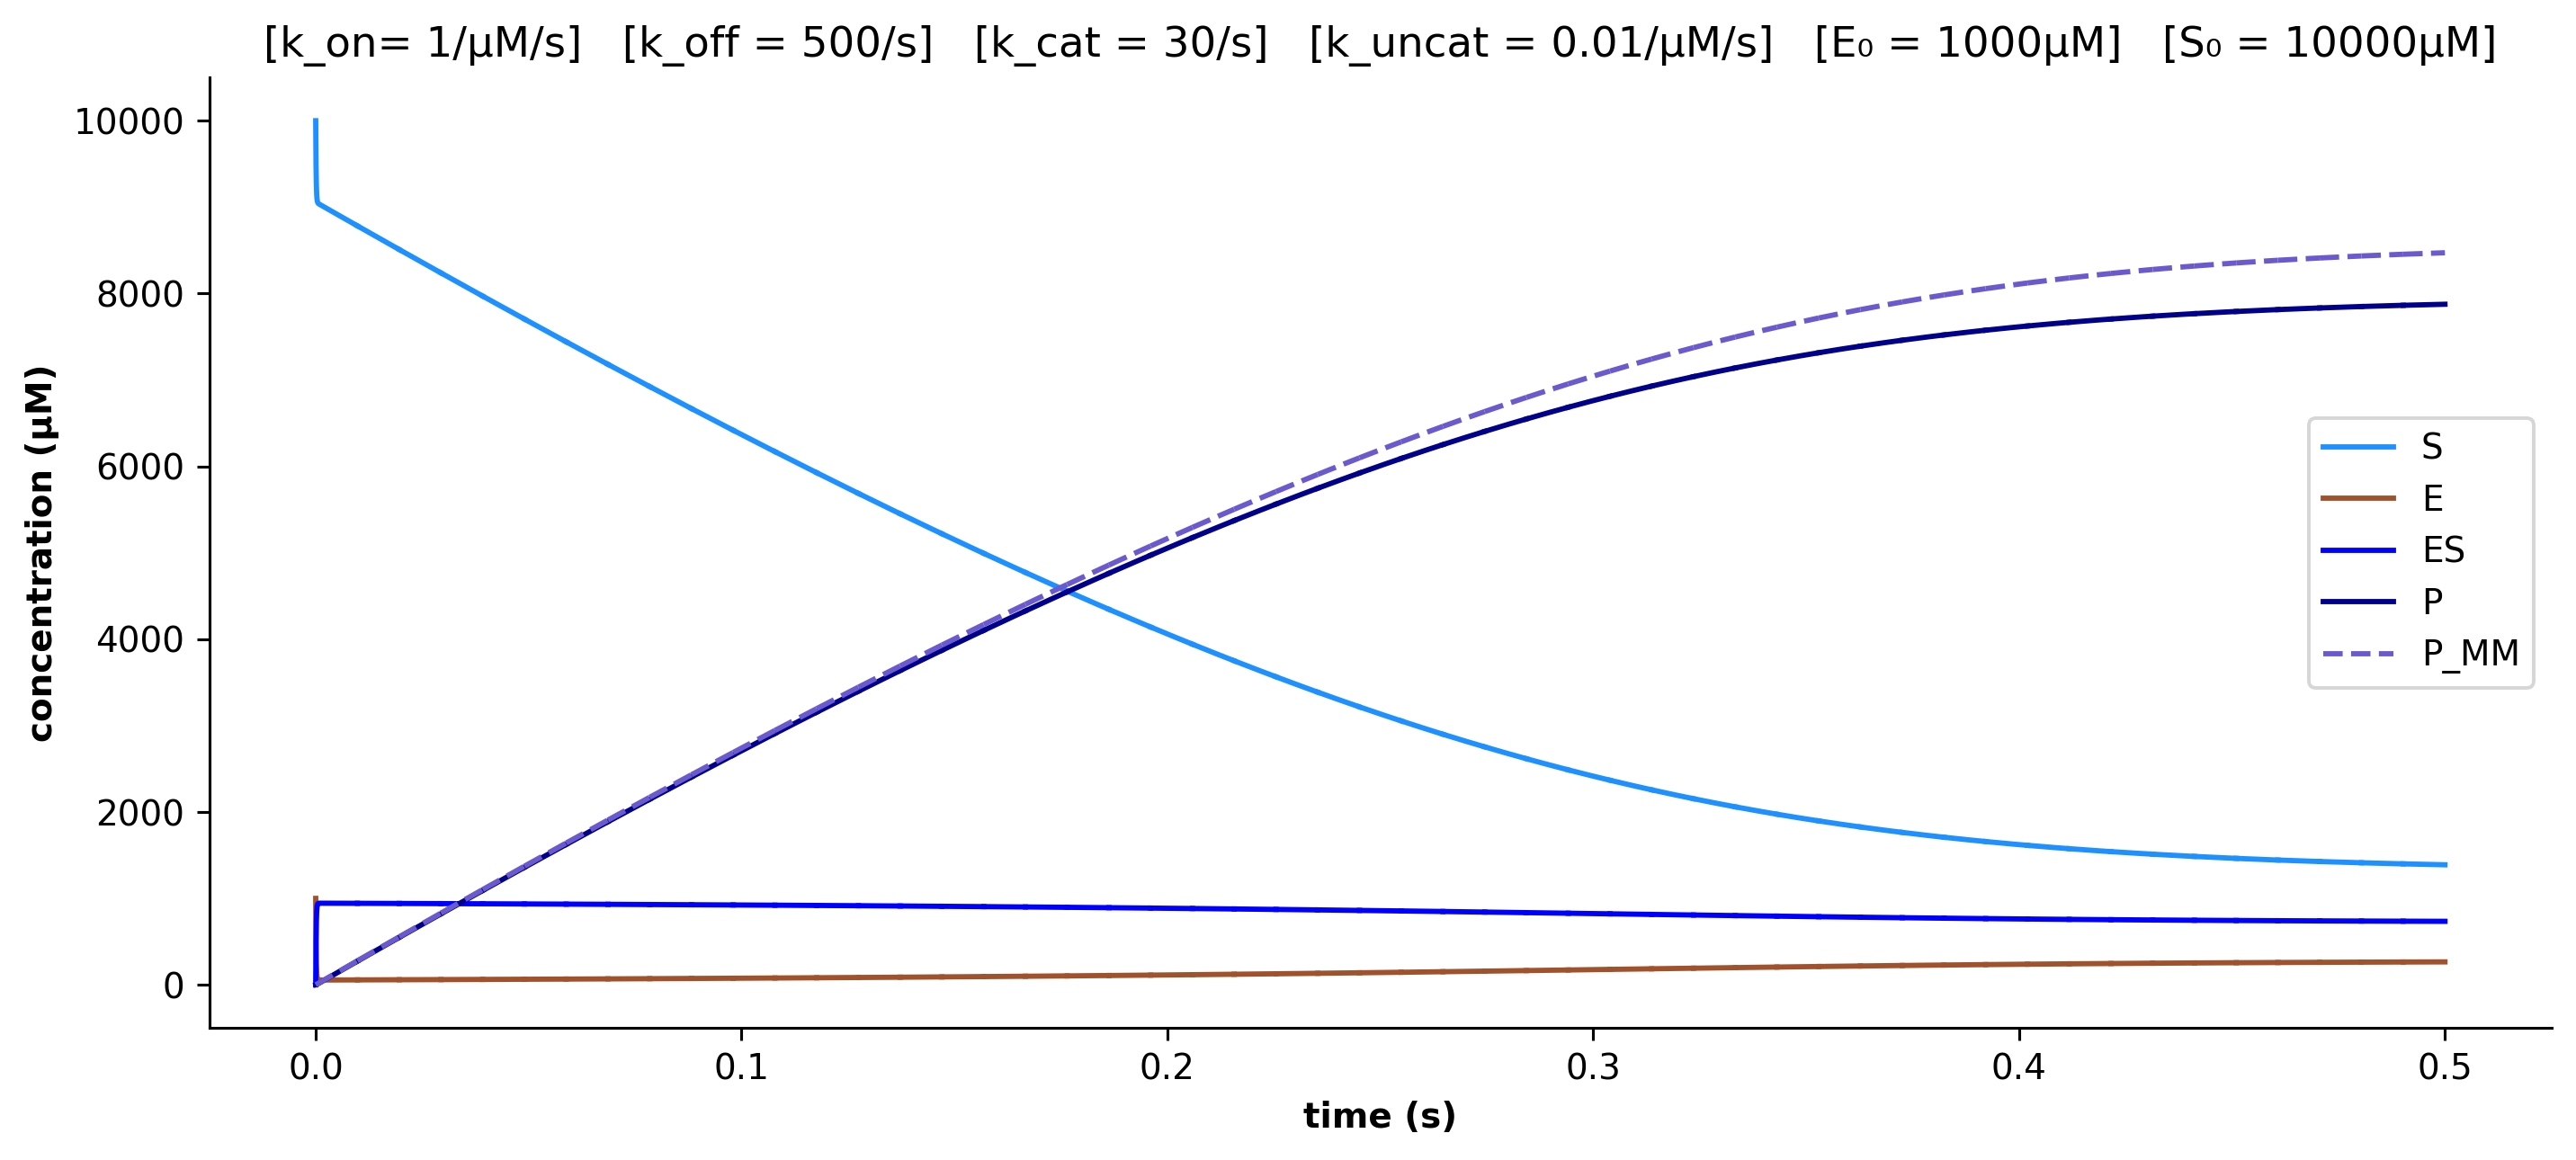

In [11]:
ax = traj_euler_full.plot.line(title=param_string(**default_initial_conditions, **default_kinetic_params), color=color(traj_euler_full.columns))
traj_euler_mm.plot.line(ax=ax, color=color(traj_euler_mm.columns), linestyle='--')

fig_style(ax)

We can plainly see the validity of the Quasi-Steady-State Approximation (QSSA) in action in the trajectory: <span style='color:#a0522d'>Enzyme <b>E</b></span> and <span style='color:#1e90ff'>Substrate <b>S</b></span> rapidly form <span style='color:#0000ff'>Enzyme-Substrate complex <b>ES</b></span>, the concentration of which remains relatively constant throughout the course of the reaction (recall the QSSA is the approximation that $\dESdt = 0$). Thus, the Michaelis-Menten/Briggs-Haldane product concentration trajectory <span style='color:#6a5acd'><b>P_MM</b></span> well approximates the full kinetics trajectory for the concentration of <span style='color:#00008b'>product <b>P</b></span>, since the requisite assumptions are valid, namely, (1) $[\mathrm{S_0}] \gg [\mathrm{E_0}]$ and (2) $\kon$, $\koff$ $\gg$ $\kcat$, $\kuncat$. 

In practice, Michaelis-Menten/Briggs-Haldane kinetics are often assumed by default, risking the possibility of their misapplication. Let's take this opportunity to explore how the MM/BH kinetics diverge from the full kinetics when we violate the requisite assumptions. 

### 2.2: Breaking the Michaelis-Menten/Briggs-Haldane Assumptions: <br /> &nbsp; &nbsp; &nbsp; Initial Substrate:Enzyme Ratio

Suppose first the number of molecules of substrate is _not_ much greater than the number of molecules of enzyme, which is a plausible regime for certain reactions _in vivo_. 

In [12]:
# Set initial enzyme and substrate concentrations: 2 molecules of substrate for each molecule of enzyme.
initial_conditions = {
    'S_0': 2e3,
    'E_0': 1e3,
    'ES_0': 0.0,
    'P_0': 0.0
}

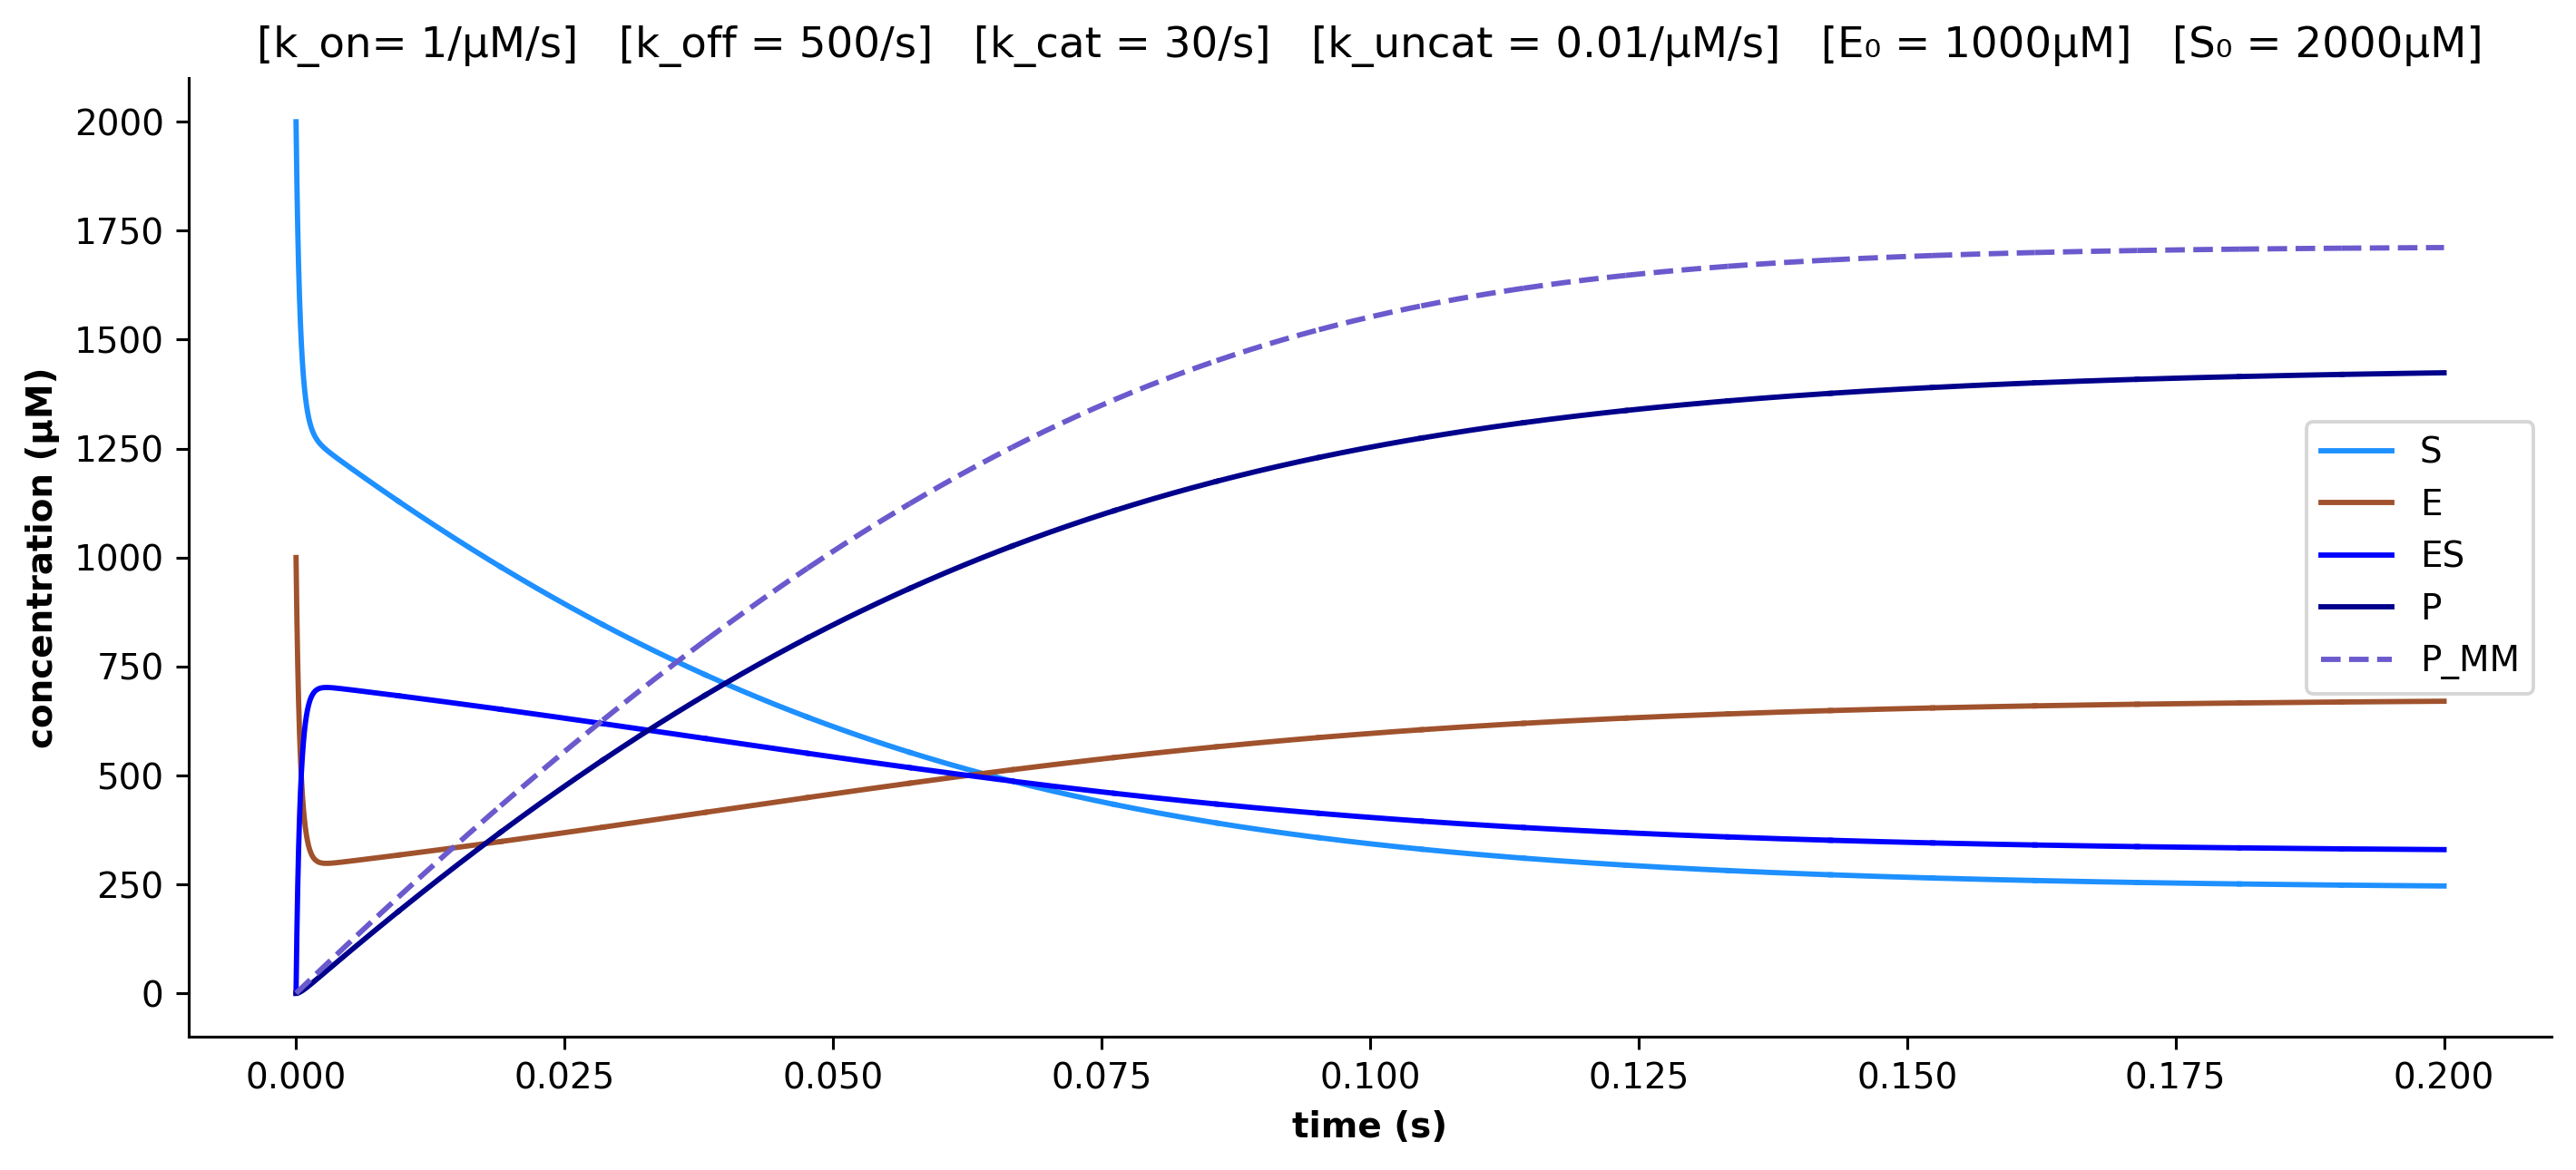

In [13]:
#collapse
traj_euler_full_2 = integrate_euler_full(default_kinetic_params, steps=2e5, initial_conditions=initial_conditions)
traj_euler_mm_2 = integrate_euler_MM(default_kinetic_params, steps=2e5, initial_conditions=initial_conditions)

ax = traj_euler_full_2.plot.line(title=param_string(**initial_conditions, **default_kinetic_params), color=color(traj_euler_full_2.columns))
traj_euler_mm_2.plot.line(ax=ax, color=color(traj_euler_mm_2.columns), linestyle='--')

fig_style(ax)

Then <span style='color:#6a5acd'><b>P_MM</b></span> worsens significantly as an estimate of <span style='color:#00008b'><b>P</b></span>.


### 2.3: Breaking the Michaelis-Menten/Briggs-Haldane Assumptions: <br /> &nbsp; &nbsp; &nbsp; Fast Enzyme-Substrate Complex Kinetics

Suppose further that the rates of association and dissociation of enzyme with subtstrate are _not_ substantially faster than those of enzyme and product. 

In [14]:
kinetic_params = {
    'k_on': 0.05,
    'k_off': 1,
    'k_cat': 50,
    'k_uncat': 0.5
}

kinetic_params['k_ms'] = k_ms(kinetic_params)
kinetic_params['k_mp'] = k_mp(kinetic_params)

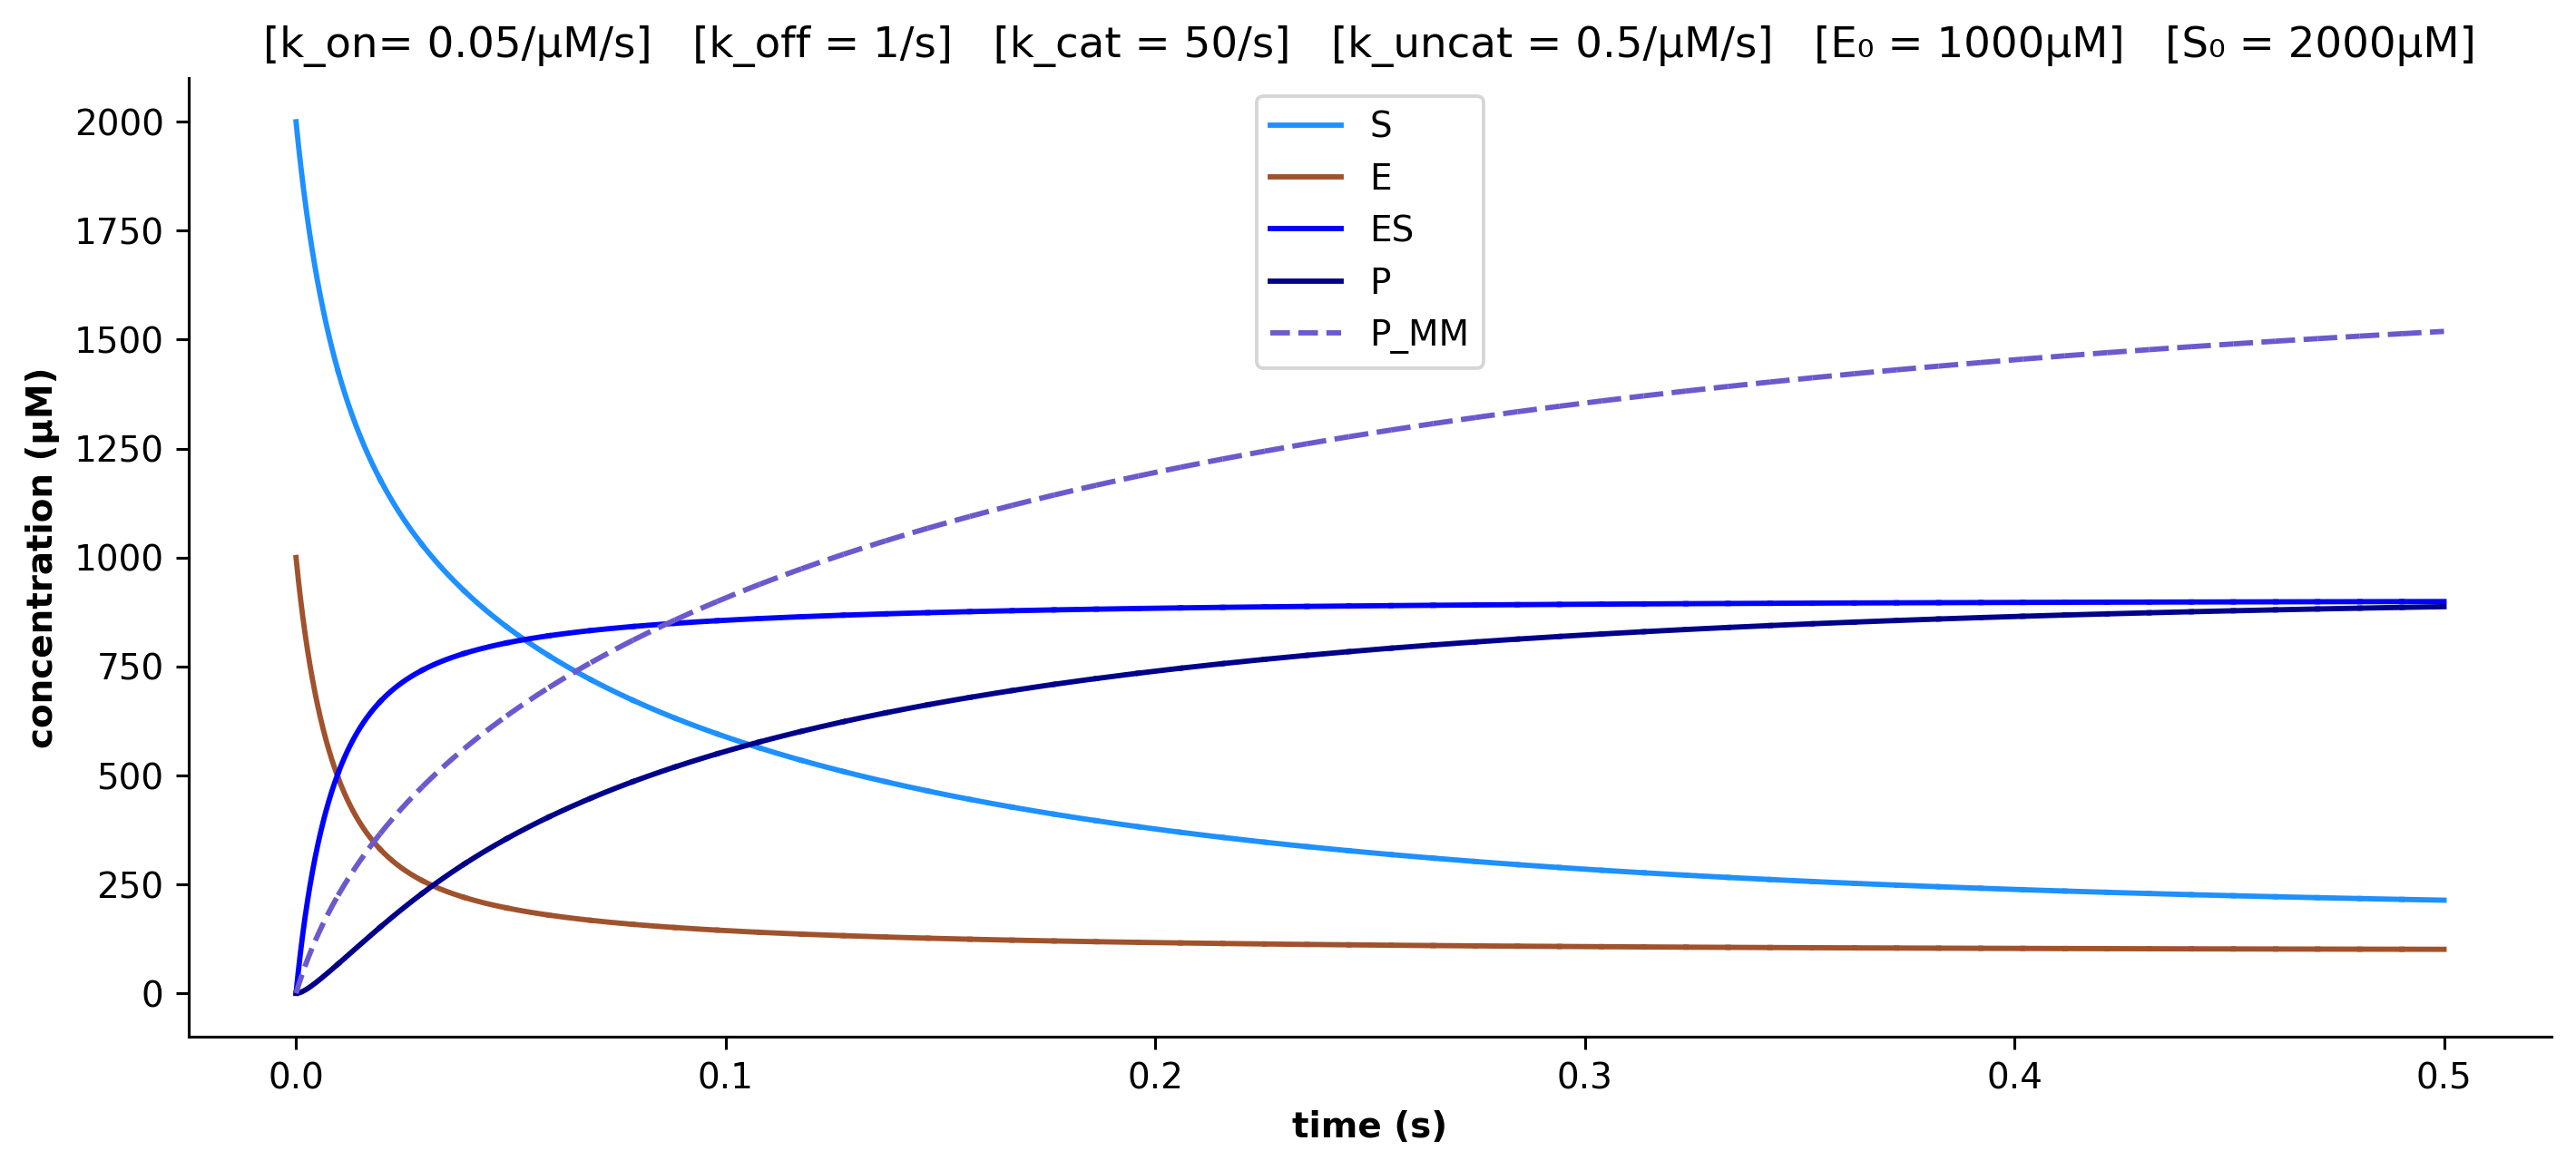

In [15]:
#collapse
traj_euler_full_3 = integrate_euler_full(kinetic_params, initial_conditions=initial_conditions)
traj_euler_mm_3 = integrate_euler_MM(kinetic_params, initial_conditions=initial_conditions)

ax = traj_euler_full_3.plot.line(title=param_string(**initial_conditions, **kinetic_params), color=color(traj_euler_full_3.columns))
traj_euler_mm_3.plot.line(ax=ax, color=color(traj_euler_mm_3.columns), linestyle='--')

fig_style(ax)

Then the Michaelis-Menten/Briggs-Haldane kinetics diverge further.

In each of these latter trajectories, the criteria to make the Michaelis-Menten/Briggs-Haldane approximation are violated, leading to poor approximations to the full kinetics. We belabor this point here because in the following, we will seek to infer the parameters of the kinetics, and our inference will fit poorly if we fit to inappropriate kinetic expressions.

### 2.4: Comparing Integrators

All of the above trajectories are generated by Euler's Method, the most intuitive ODE integration technique. Unfortunately, Euler's Method's naïvete has drawbacks: 
- The order of the error is large with respect to the timestep size.
- The method is slow, due to the uniformity of the timestep sizes.

A variety of faster and more accurate (albeit more complicated) integrators have been proposed, many of which have implementations in scipy's <code><a href="https://docs.scipy.org/doc/scipy/reference/integrate.html">integrate</a></code> package. Due to their superior speeds and accuracies, we'll use these methods during inference. As a sanity check, we compare our basic Euler Method solver to scipy's:


In [16]:
#collapse
# define scipy_full and scipy_MM functions (and helpers) to integrate chemical kinetics with scipy
from scipy.integrate import solve_ivp

def dy_full(t, y, S_0, E_0, ES_0, P_0, k_on, k_off, k_cat, k_uncat, *args):
    # Y ordered S,E,ES,P
    dy = np.zeros(4)
    dy[0] = k_off * y[2] - k_on * y[1] * y[0]
    dy[1] = k_off * y[2] - k_on * y[1] * y[0] + k_cat * y[2] - k_uncat * y[1] * y[3]
    dy[2] = k_on * y[1] * y[0] - k_off * y[2] - k_cat * y[2] + k_uncat * y[1] * y[3]
    dy[3] = k_cat * y[2] - k_uncat * y[1] * y[3]
    return dy


def dy_MM(t, y, S_0, E_0, ES_0, P_0, k_on, k_off, k_cat, k_uncat, k_ms, k_mp):
    # Y ordered S,P
    dy = np.zeros(2)
    dy[1] = ((k_cat * E_0 * y[0]) / k_ms - (k_off * E_0 * y[1]) / k_mp) / (1 + y[0] / k_ms + y[1] / k_mp)
    dy[0] = -dy[1]

    return dy


def integrate_scipy_full(kinetic_params, initial_conditions=default_initial_conditions, dt=dt, steps=steps, atol=1e-6):

    t_span = (0, dt*steps)
    t_eval = np.around(np.linspace(t_span[0],t_span[1],1001), decimals=5)
    y0 = list(initial_conditions.values())

    try:
        sol = solve_ivp(dy_full, t_span, y0, args=(*initial_conditions.values(), *kinetic_params.values()), t_eval=t_eval, first_step=dt, method='LSODA', atol=atol)
        return pd.DataFrame(sol.y.T, index=sol.t, columns=['S', 'E', 'ES', 'P'])
    except:
        return pd.DataFrame(columns=['S', 'E', 'ES', 'P'])


def integrate_scipy_MM(kinetic_params, initial_conditions=default_initial_conditions, dt=dt, steps=steps):

    t_span = (0, dt*steps)
    t_eval = np.around(np.linspace(t_span[0],t_span[1],1001), decimals=5)
    y0 = [initial_conditions['S_0'], initial_conditions['P_0']]

    try:
        sol = solve_ivp(dy_MM, t_span, y0, args=(*initial_conditions.values(), *kinetic_params.values()), t_eval=t_eval, first_step=dt)
        return pd.DataFrame(sol.y.T, index=sol.t, columns=['S_MM', 'P_MM'])
    except:
        return pd.DataFrame(columns=['S_MM', 'P_MM'])


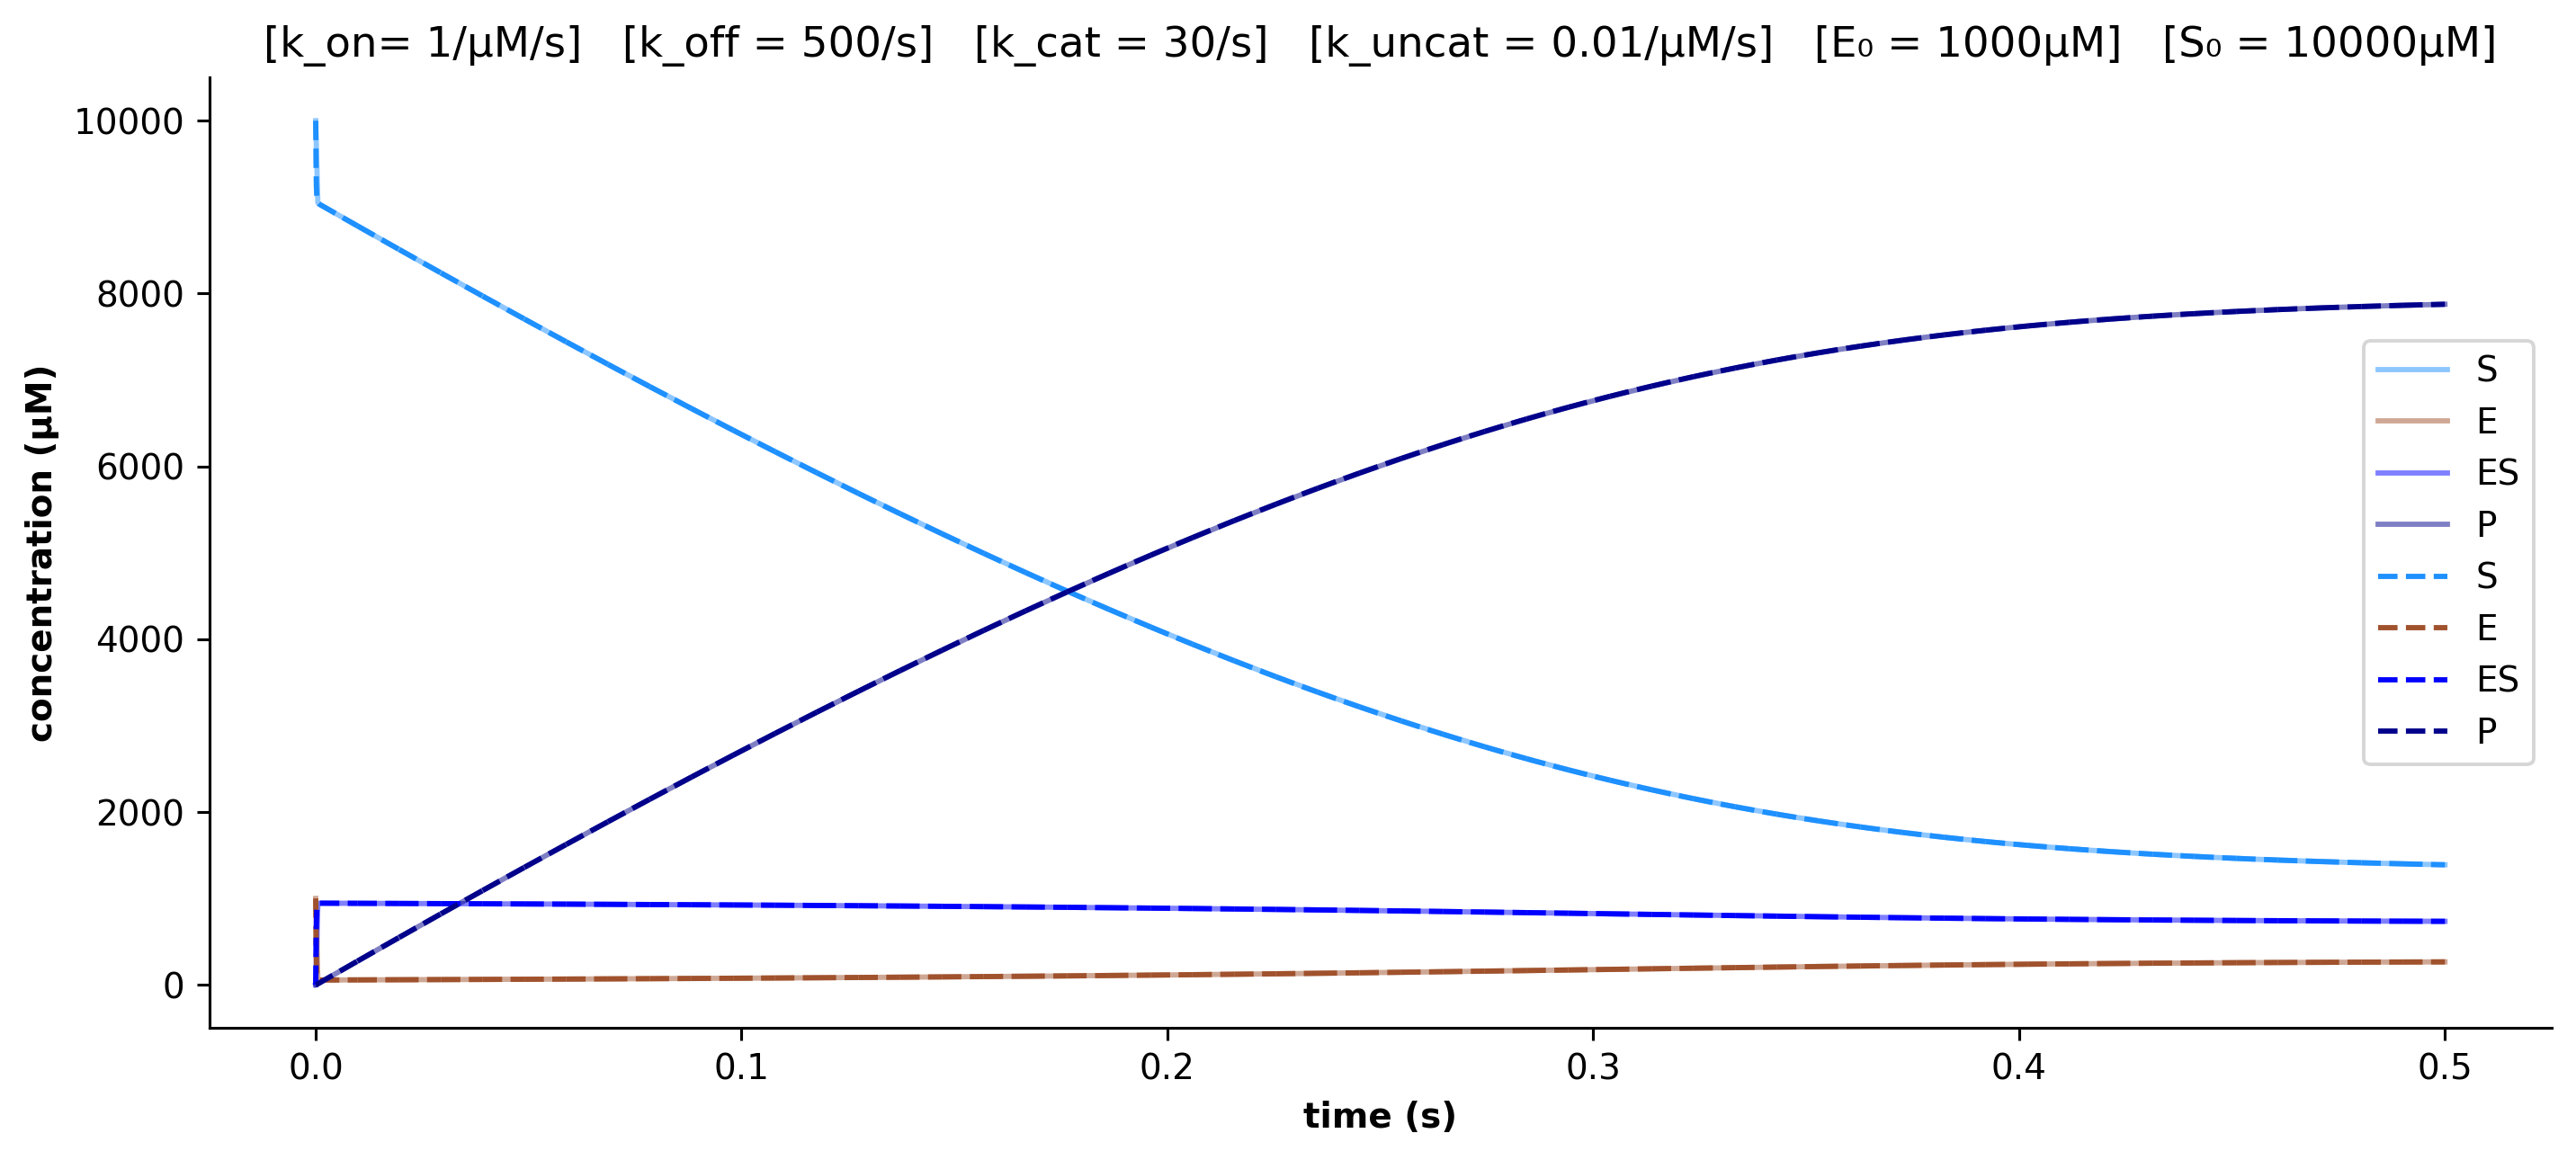

In [17]:
#collapse
# solve the system with both integrators, for default parameters
traj_scipy_full = integrate_scipy_full(default_kinetic_params)

ax = traj_scipy_full.plot.line(title=param_string(**default_initial_conditions, **default_kinetic_params), color=color(traj_scipy_full.columns), alpha=0.5)
traj_euler_full.plot.line(ax=ax, color=color(traj_euler_full.columns), linestyle='--')

fig_style(ax)

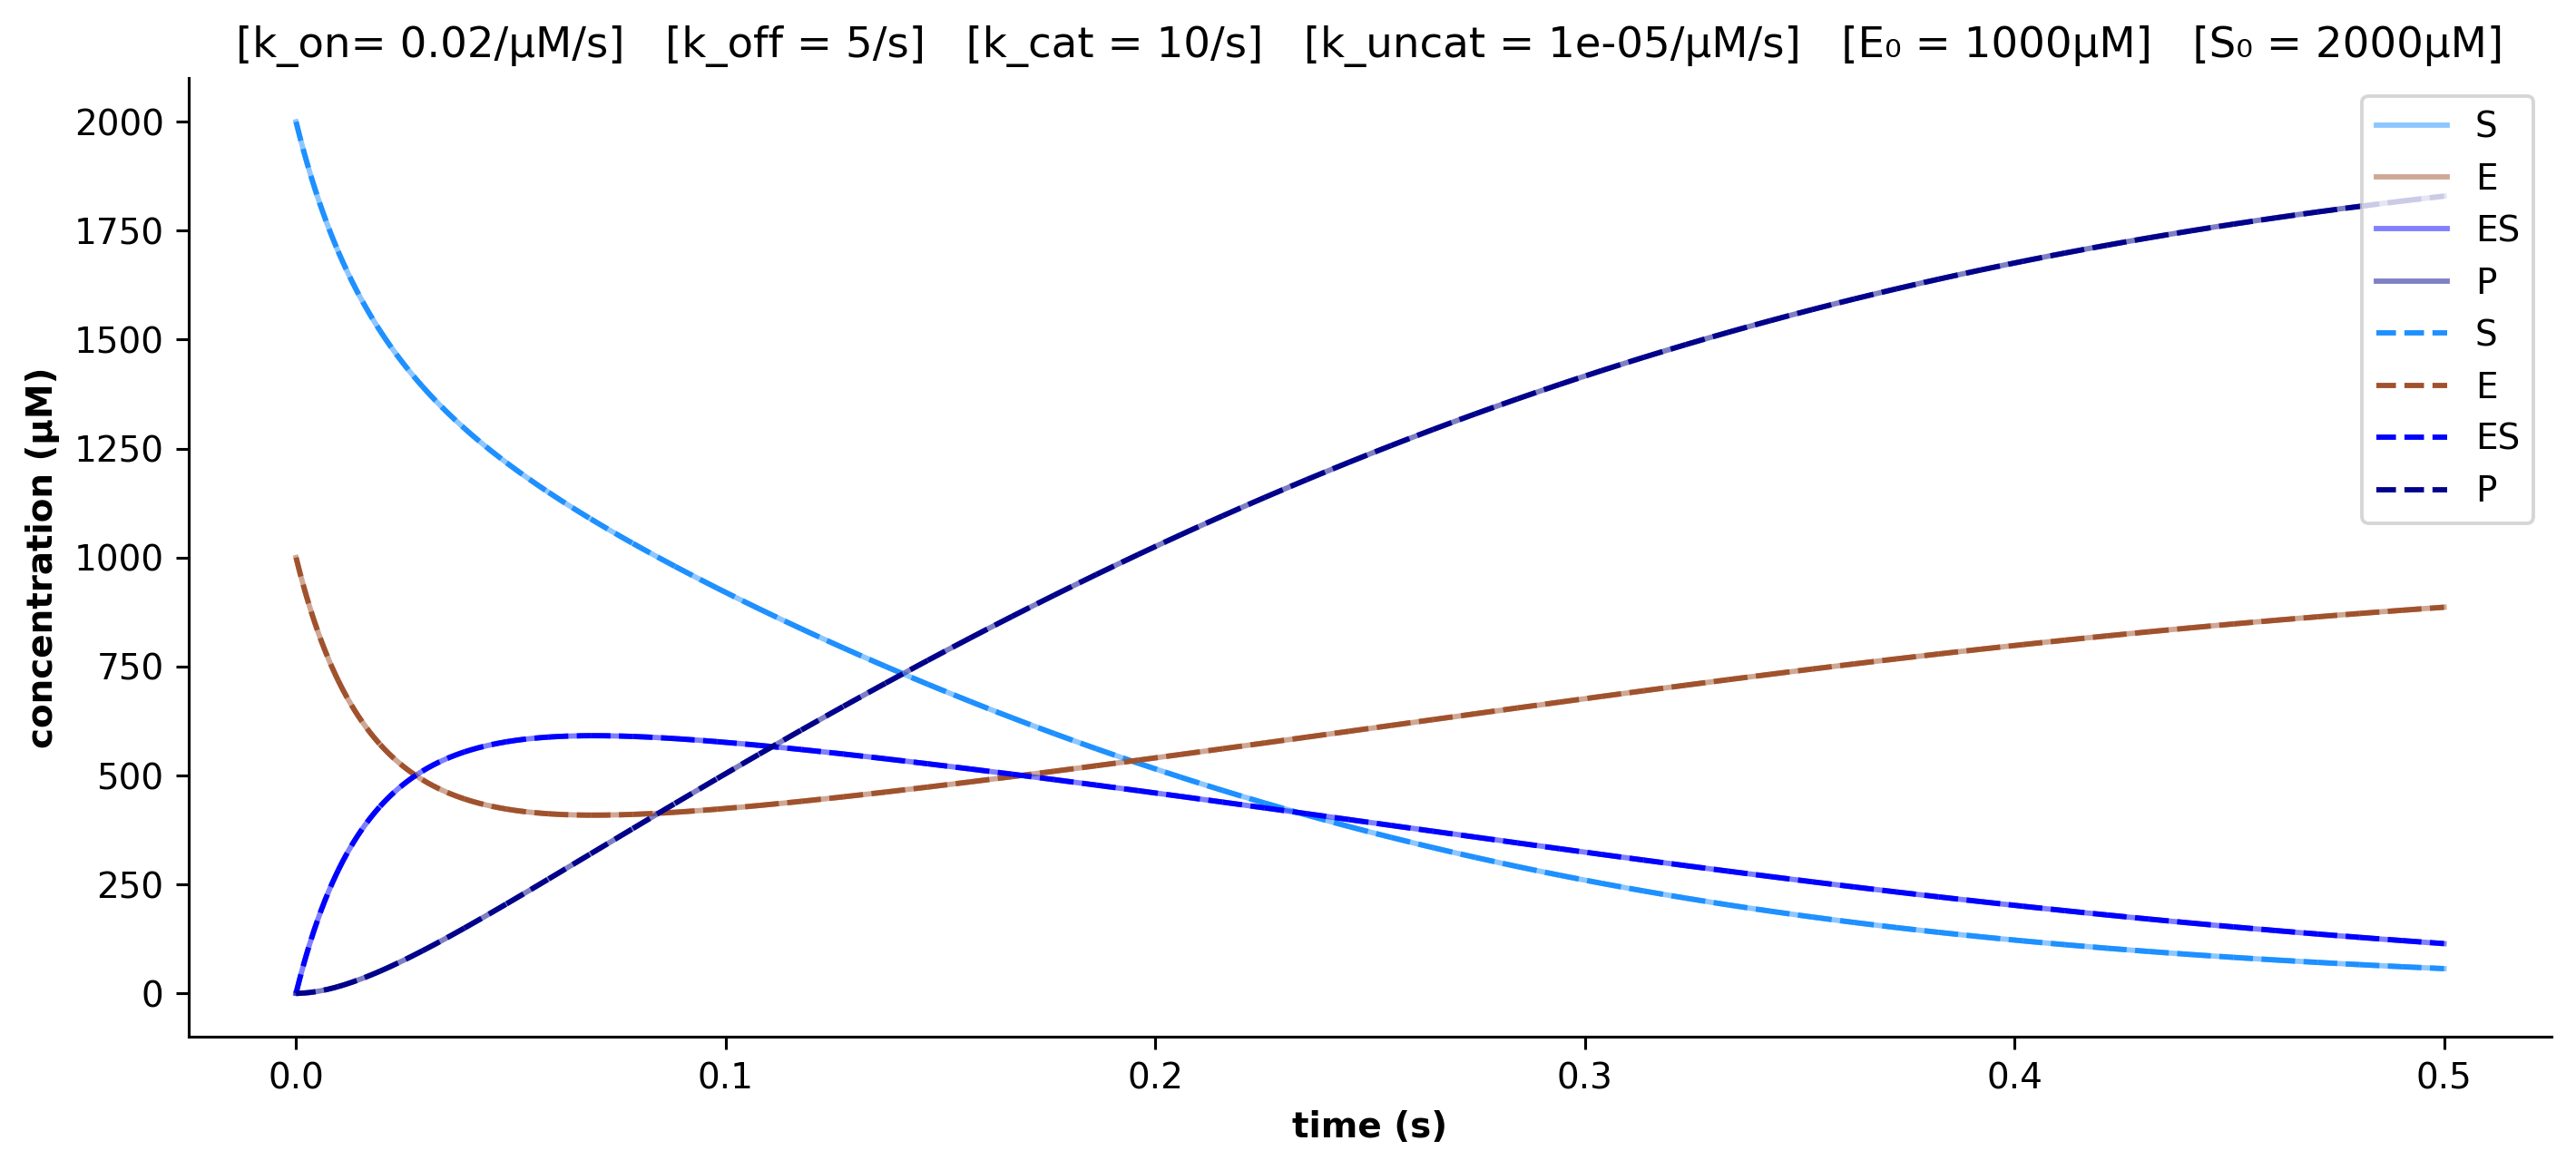

In [18]:
#collapse
# solve the system with both integrators, for unusual parameters
kinetic_params = {
    'k_on': 0.02,
    'k_off': 5,
    'k_cat': 10,
    'k_uncat': 0.00001,
}

kinetic_params['k_ms'] = k_ms(kinetic_params)
kinetic_params['k_mp'] = k_mp(kinetic_params)

import time
start = time.process_time()
traj_scipy_full_4 = integrate_scipy_full(kinetic_params, initial_conditions=initial_conditions)
scipy_time = time.process_time() - start

start = time.process_time()
traj_euler_full_4 = integrate_euler_full(kinetic_params, initial_conditions=initial_conditions)
euler_time = time.process_time() - start

ax = traj_scipy_full_4.plot.line(title=param_string( **initial_conditions,**kinetic_params), color=color(traj_scipy_full_4.columns), alpha=0.5)
traj_euler_full_4.plot.line(ax=ax, color=color(traj_euler_full_4.columns), linestyle='--')

fig_style(ax)

The lack of deviation gives us confidence both integration techniques are accurate. Meanwhile,

In [19]:
f'our naïve code takes {round(euler_time, 2)}s, whereas the optimized scipy code takes {round(scipy_time, 4)}s to generate the same trajectory.'

'our naïve code takes 1.15s, whereas the optimized scipy code takes 0.0109s to generate the same trajectory.'

## 3. Inference

We have seen how the trajectory of the chemical system is a function of the kinetic parameters. We would now like to invert that function to recover the kinetic parameters from an observed trajectory.

Suppose we know the initial concentrations of <span style='color:#a0522d'>Enzyme <b>E</b></span> and <span style='color:#1e90ff'>Substrate <b>S</b></span>, and we measure the concentration of <span style='color:#00008b'>product <b>P</b></span> over the course of the reaction, which yields the following dataset: 

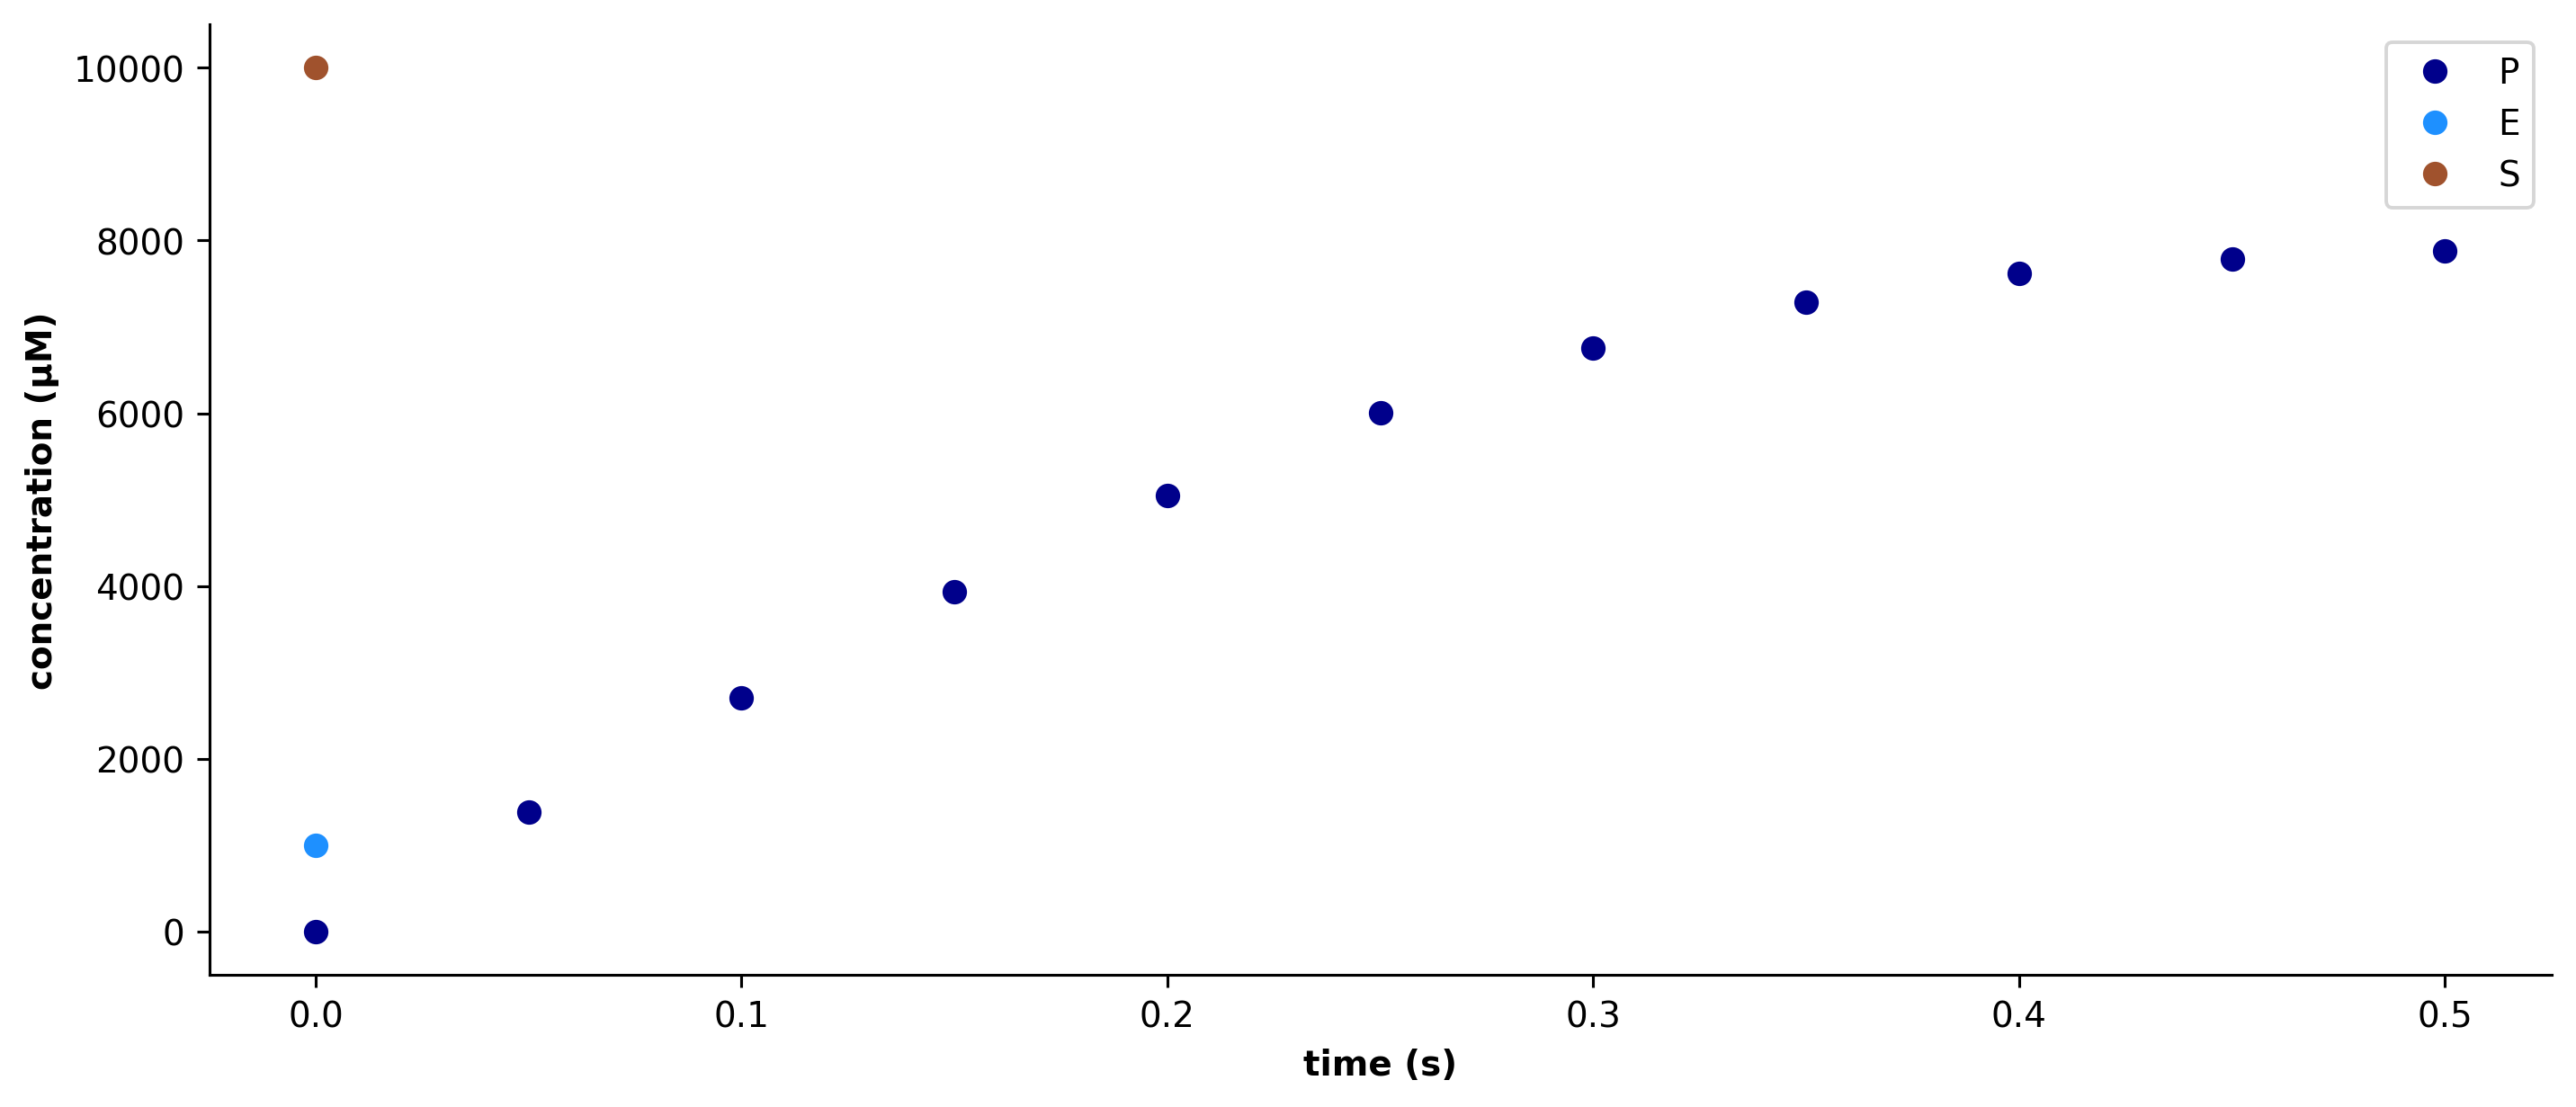

In [20]:
#collapse
# plot inverse problem setting
measurement_times = np.arange(10+1)/20
observations = traj_scipy_full.loc[measurement_times, 'P']

ax = observations.plot.line(marker='o', lw=0, color=color(['P']), legend=True)
traj_scipy_full.loc[0, ['E', 'S']].to_frame().T.plot.line(ax=ax, marker='o', lw=0, color=color(traj_scipy_full.columns), legend=True)

fig_style(ax)

We will supply noiseless measurements to our inference algorithms. However, our inference procedures will assume noise in the measurements. 

<div class="flash"><strong>Note:</strong>
    
If we had measured $\dPdt$ for various (linearly independent) concentrations of $[\mathrm{S}]$, $[\mathrm{P}]$, and $[\mathrm{E}]_0$ (as in an <i>in vitro</i> enzyme assay) we could use a nonlinear regression with the Michaelis-Menten/Briggs-Haldane expression for $\dPdt$. Concretely, supposing we had a set of measurements for the variables in <span style="color:blue">blue</span>, a nonlinear regression would permit us to fit the constants in <span style="color:red">red</span>:

$$\color{blue}{\dPdt} = 
\frac{
\frac{\color{red}{\kcat} \, 
\color{blue}{[\mathrm{E_T}]}
\color{blue}{[\mathrm{S}]}}
{\color{red}{K_{m,\mathrm{S}}}} - 
\frac{\color{red}{\koff} \, \color{blue}{[\mathrm{E_T}]} \color{blue}{[\mathrm{P}]}}{\color{red}{K_{m,\mathrm{P}}}}}
{1+\frac{\color{blue}{[\mathrm{S}]}}{\color{red}{K_{m,\mathrm{S}}}} + \frac{\color{blue}{[\mathrm{P}]}}{\color{red}{K_{m,\mathrm{P}}}}} 
$$

If we had assumed the reaction were irreversible, the Michaelis-Menten/Briggs-Haldane expression would have simplified to

$$\color{blue}{\dPdt} = 
\frac{
\color{red}{\kcat} \, \color{blue}{[\mathrm{E_T}]} \color{blue}{[\mathrm{S}]}}
{\color{red}{K_{m,\mathrm{S}}} + \color{blue}{[\mathrm{S}]}}
$$

Where $\color{red}{\kcat} \, \color{blue}{[\mathrm{E_T}]}$ is often consolidated as $\color{red}{V_{max}}$.


To recap, we take a different approach because:
<ol>
<li> Simultaneous measurements of the activity many enzymes in cells might inform us about $[\mathrm{S}]$, $[\mathrm{P}]$, and perhaps $[\mathrm{E}]$ but not $\dPdt$. We would also presumably not be able to approximate $\dPdt$ via finite differences, due to the relative sparsity of the measurement in time compared to the rates of the reactions. </li>

<li> This approach would produce spurious estimates of the kinetic parameters in cases in which the Quasi-Steady-State Approximation is invalid (see <a href="#2.2:-Breaking-the-Michaelis-Menten/Briggs-Haldane-Assumptions:--%C2%A0-%C2%A0-%C2%A0-Initial-Substrate:Enzyme-Ratio">§2.2</a>, <a href="#2.3:-Breaking-the-Michaelis-Menten/Briggs-Haldane-Assumptions:--%C2%A0-%C2%A0-%C2%A0-Fast-Enzyme-Substrate-Complex-Kinetics">§2.3</a>) which may often be the case <i>in vivo</i>. </li>
</ol>

At the moment, I believe there are no methods for the inverse problem which are not variants of the two methods I will describe, and importantly, no methods which do not iterate a loop, solving the forward problem at each iteration.

</div>

There are two types of approaches to solving this inverse problem. We will explore the simplest variant of each type. 

### 3.1 Bayesian Approach: Inference by Sampling 
<small>[We assume the reader is familiar with Bayesian Inference in other settings.]</small>

<!-- For an introduction to the topic, we recommend <a href="https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-438-algorithms-for-inference-fall-2014/">the 6.438 course notes</a> -->

The goal of the Bayesian approach is to characterize a distribution of kinetic parameters which could plausibly have generated the data, called the posterior distribution. Bayes Theorem defines the posterior as the product of the prior and likelihood (up to a constant factor). Thus the Bayesian approach entails _defining_ a prior and a likelihood for our problem. 

#### 3.1.1. Prior

If the kinetic parameters of our enzyme are not unlike the kinetic parameters of other enzymes, then the empirical distribution of kinetic parameters of other enzymes is a good prior for the parameters of our enzyme. 

Since databases of observed enzyme kinetic parameters (e.g. [BRENDA](https://www.brenda-enzymes.org/), [SabioRK](http://sabio.h-its.org/)) appear to be unreliable, we'll use a previously curated set of kinetic parameters (from the supplement of <a href="https://pubs.acs.org/doi/10.1021/bi2002289">Bar-Even et. al.</a>). 

This database lists $k_{\mathrm{m}}$ and $\kcat$ for both "forwards" and "reverse" reactions with respect to which direction biologists believe is "productive", from which we can parlay distributions for $\kms$ and $\kcat$ from reactions in the forwards direction, and $\kmp$ and $\koff$ from reverse reactions. 

In [21]:
#collapse
# import kinetic parameter database
df = pd.read_excel('../data/Enzyme_Kinetic_Parameter_Inference/Moderately_Efficient_Enzyme/bi2002289_si_003.xls', 1)[['Reaction direction (KEGG)','KM (µM)','kcat (1/sec)']]

empirical_kms = df.loc[df['Reaction direction (KEGG)'] == 1, 'KM (µM)'].dropna().rename('k_ms')
empirical_kmp = df.loc[df['Reaction direction (KEGG)'] == -1, 'KM (µM)'].dropna().rename('k_mp')
empirical_kcat = df.loc[df['Reaction direction (KEGG)'] == 1, 'kcat (1/sec)'].dropna().rename('k_cat')
empirical_koff = df.loc[df['Reaction direction (KEGG)'] == -1, 'kcat (1/sec)'].dropna().rename('k_off')

empirical_joint_forward_params = df.loc[df['Reaction direction (KEGG)'] == 1, ['KM (µM)','kcat (1/sec)']].dropna().rename(columns={'KM (µM)':'k_ms', 'kcat (1/sec)':'k_cat'})
empirical_joint_reverse_params = df.loc[df['Reaction direction (KEGG)'] == -1, ['KM (µM)','kcat (1/sec)']].dropna().rename(columns={'KM (µM)':'k_mp', 'kcat (1/sec)':'k_off'})

In [22]:
#collapse
# figure styles
def fig_style_2(ax):
    for side in ["right","top","left"]: ax.spines[side].set_visible(False)
    ax.get_yaxis().set_visible(False)


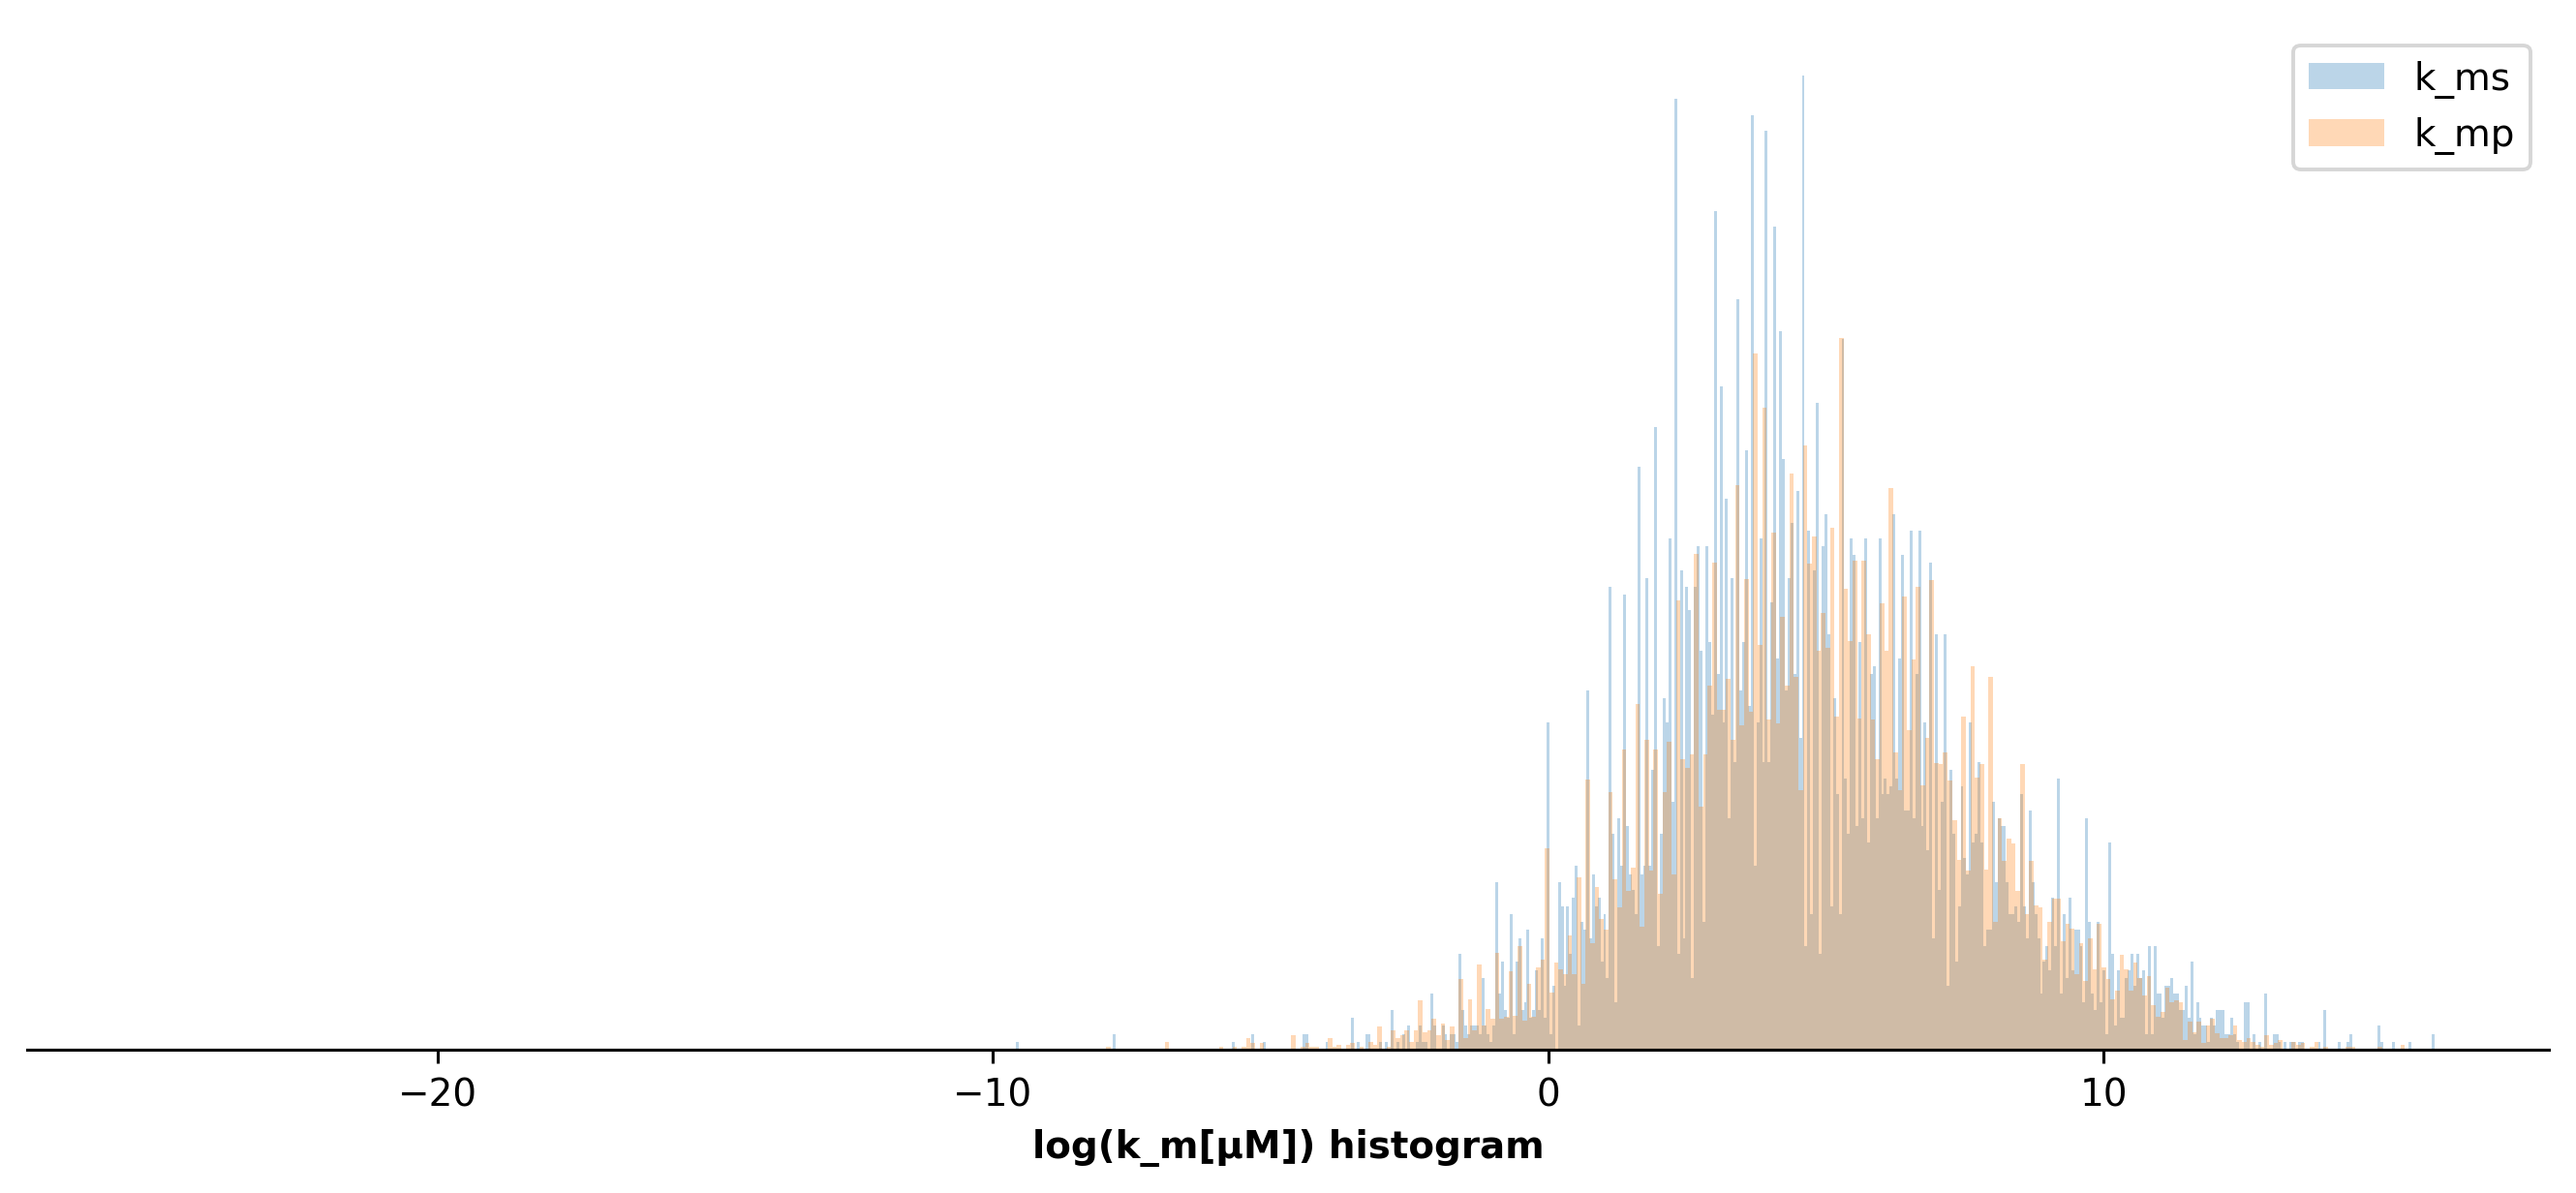

In [23]:
#collapse
# plot km distribution in log-space
log_empirical_kms = np.log(empirical_kms)
log_empirical_kmp = np.log(empirical_kmp)

log_kms_normal = scipy.stats.norm(loc=log_empirical_kms.mean(), scale=log_empirical_kms.std())
log_kmp_normal = scipy.stats.norm(loc=log_empirical_kmp.mean(), scale=log_empirical_kmp.std())

ax = log_empirical_kms.plot.hist(bins=500, alpha=0.3, density=1, legend=True)
log_empirical_kmp.plot.hist(bins=500, ax=ax, alpha=0.3, density=1, legend=True)

ax.set_xlabel('log(k_m[µM]) histogram',  weight='bold')
fig_style_2(ax)

# x1 = np.linspace(log_kms_normal.ppf(0.01), log_kms_normal.ppf(0.99), 100)
# ax.plot(x1, log_kms_normal.pdf(x1)*ax.get_ylim()[1]*3, '-', lw=0.6, color='dodgerblue')

# x2 = np.linspace(log_kmp_normal.ppf(0.01), log_kmp_normal.ppf(0.99), 100)
# ax.plot(x2, log_kmp_normal.pdf(x2)*ax.get_ylim()[1]*3, '-', lw=0.8, color='peru')

This plot is surprising: according to this database, enzymes appear to have roughly equal binding affinity for their substrates and products. 

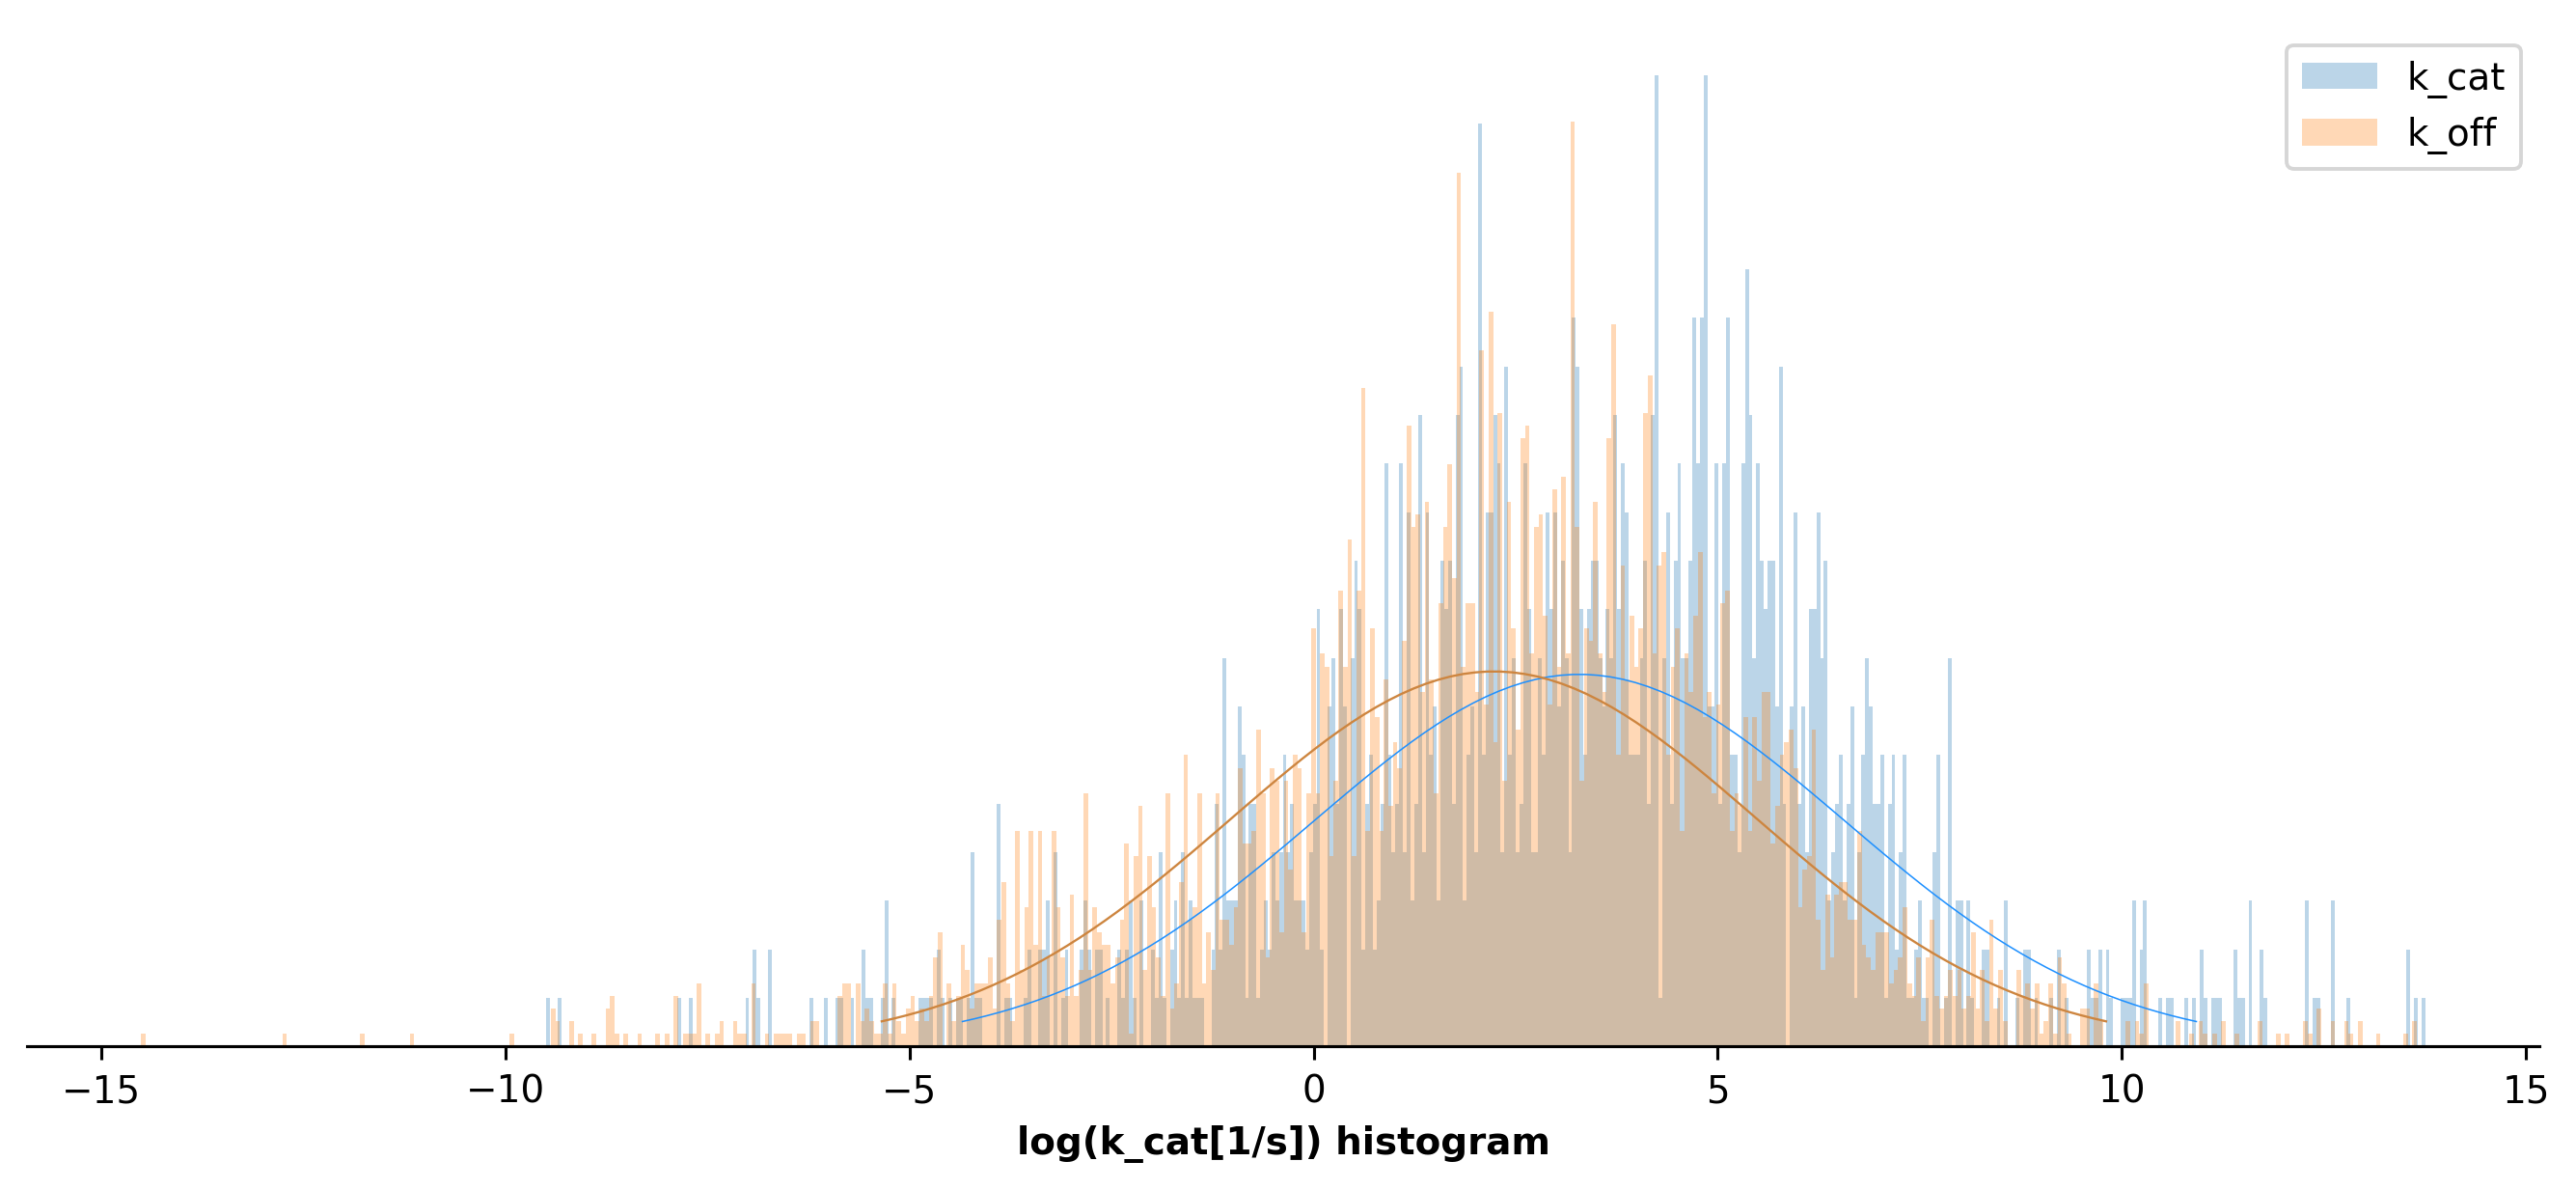

In [24]:
#collapse
# plot kcat distribution in log-space
log_empirical_kcat = np.log(empirical_kcat)
log_empirical_koff = np.log(empirical_koff)

log_kcat_normal = scipy.stats.norm(loc=log_empirical_kcat.mean(), scale=log_empirical_kcat.std())
log_koff_normal = scipy.stats.norm(loc=log_empirical_koff.mean(), scale=log_empirical_koff.std())

ax = log_empirical_kcat.plot.hist(bins=500, alpha=0.3, density=1, legend=True)
log_empirical_koff.plot.hist(bins=500, ax=ax, alpha=0.3, density=1, legend=True)

x1 = np.linspace(log_kcat_normal.ppf(0.01), log_kcat_normal.ppf(0.99), 100)
ax.plot(x1, log_kcat_normal.pdf(x1)*ax.get_ylim()[1]*3, '-', lw=0.4, color='dodgerblue')

x2 = np.linspace(log_koff_normal.ppf(0.01), log_koff_normal.ppf(0.99), 100)
ax.plot(x2, log_koff_normal.pdf(x2)*ax.get_ylim()[1]*3, '-', lw=0.6, color='peru')

ax.set_xlabel('log(k_cat[1/s]) histogram',  weight='bold')
fig_style_2(ax)

On the other hand, they have a fairly strong preference for catalyzing the reaction biologists think of as forwards (~10x).

Since these empirical distributions over $\kms$ and $\kcat$ in the forwards direction and $\kmp$ and $\koff$ in the reverse direction look sufficiently like normals in log space, so we'll treat them as lognormals. However, we would like our inference procedure to estimate the semantic parameters $\kon$, $\koff$, $\kcat$, and $\kuncat$. We can rearrange the expressions for $\kms$ and $\kmp$ to get expressions for the two parameters we're missing:

$$ \kon = \frac{\koff + \kcat}{\kms} \quad \mathrm{and} \quad \kuncat = \frac{\koff + \kcat}{\kmp}$$

Conveniently, the ratio of lognormal variables $\frac{X_1}{X_2}$ is also lognormal with $\mu_{1/2} = \mu_1 - \mu_2$ and $ \sigma^2_{1/2} = \sigma^2_1 + \sigma^2_2 - \sigma_{x_1, x_2}$. In order to use that fact, we say the sum of the random variables $\koff + \kcat$ is also log-normally distributed. We compute its mean and variance empirically.



In [25]:
kcat_plus_koff = pd.Series(np.repeat(empirical_kcat.values, len(empirical_koff)) +
                           np.tile(empirical_koff.values, len(empirical_kcat)))

log_kcat_plus_koff_mean = np.log(kcat_plus_koff).mean()
log_kcat_plus_koff_var = np.log(kcat_plus_koff).var()

This permits us to produce empirical distributions for $\kon$ and $\kuncat$,

In [26]:
log_kon_normal = scipy.stats.norm(loc=log_kcat_plus_koff_mean-log_empirical_kms.mean(),
                                  scale=sqrt(log_kcat_plus_koff_var+log_empirical_kms.var()))

log_kuncat_normal = scipy.stats.norm(loc=log_kcat_plus_koff_mean-log_empirical_kmp.mean(),
                                     scale=sqrt(log_kcat_plus_koff_var+log_empirical_kmp.var()))


which, along with our empirical distributions for $\koff$ and $\kcat$, define a prior over the 4 kinetic parameters we wish to infer.

We might ask whether these are correlated lognormals...


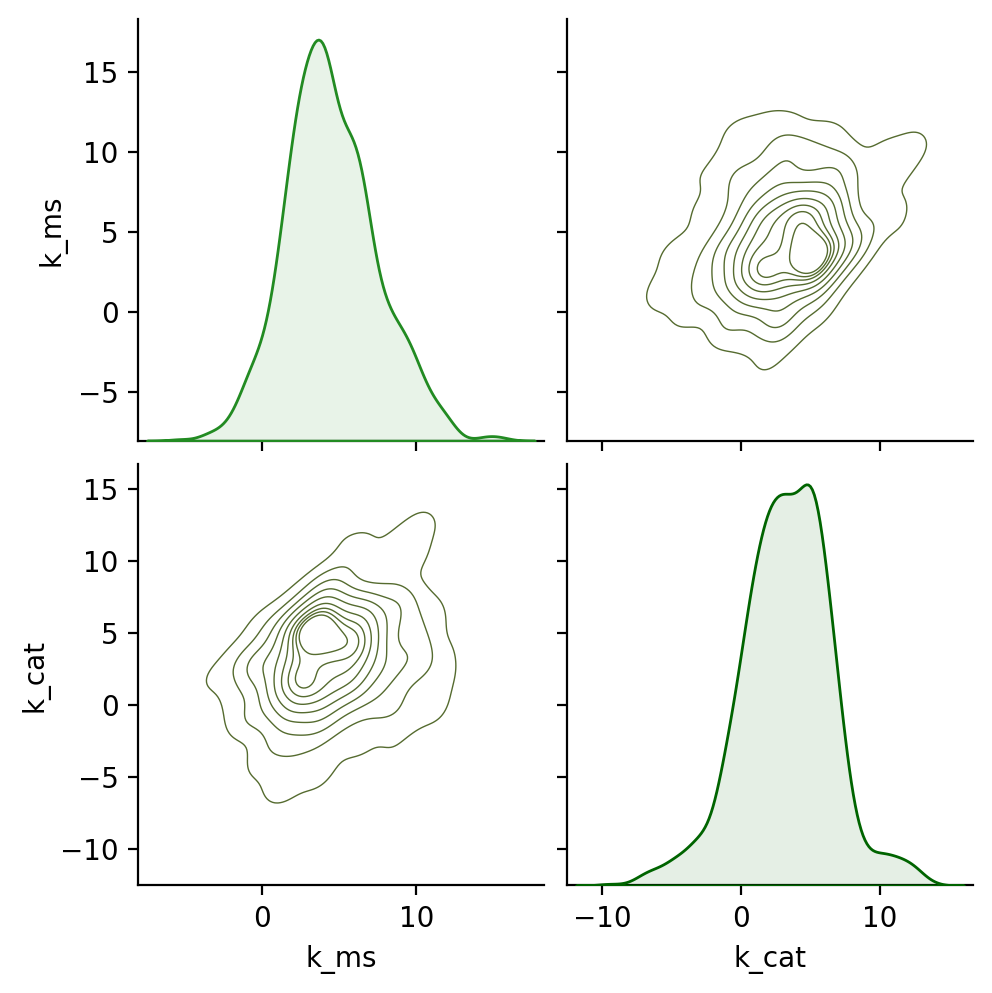
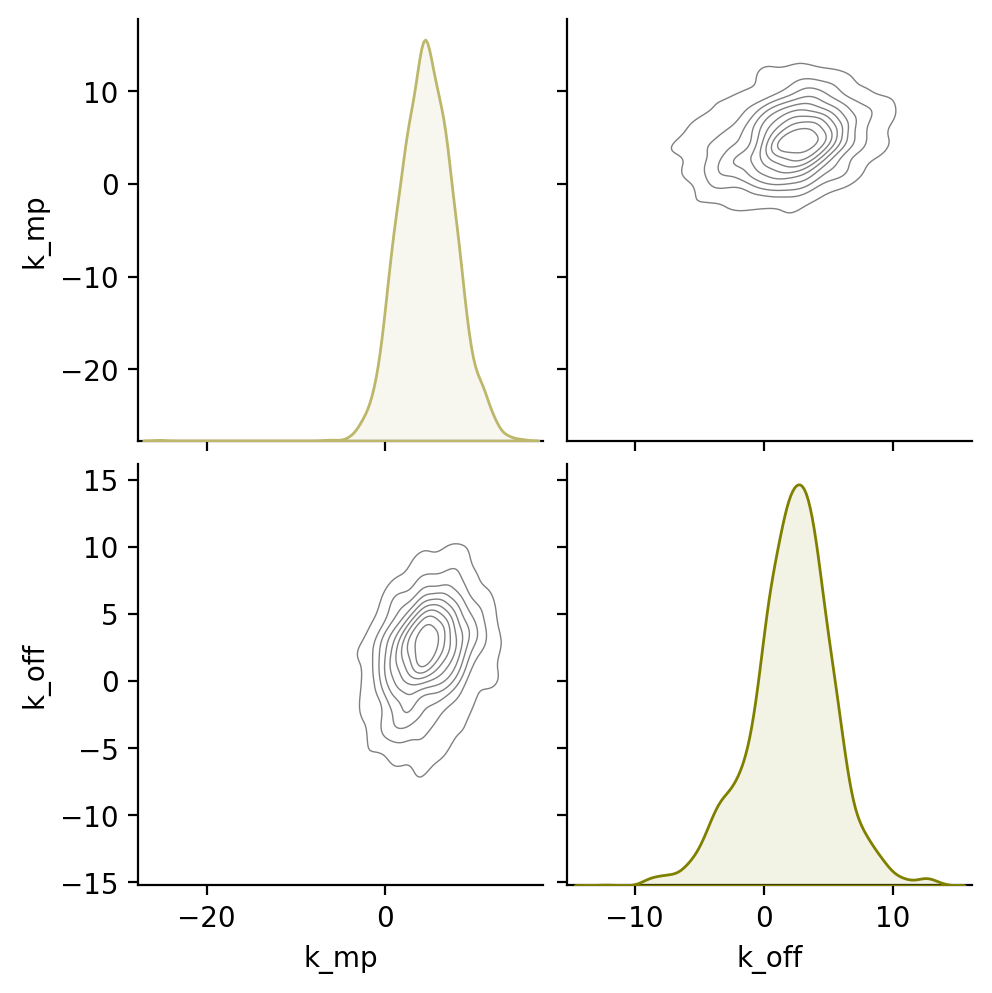

In [27]:
#collapse
pp = sns.pairplot(np.log(empirical_joint_forward_params), kind="kde", plot_kws={'linewidths':0.5, 'color':'darkolivegreen'})

k_ms_univariate_density = pp.diag_axes[0].get_children()[0]
k_ms_univariate_density.set_edgecolor(c['k_ms'])
k_ms_univariate_density.set_facecolor(hex_to_rgb(c['k_ms']) + [0.1])

k_cat_univariate_density = pp.diag_axes[1].get_children()[0]
k_cat_univariate_density.set_edgecolor(c['k_cat'])
k_cat_univariate_density.set_facecolor(hex_to_rgb(c['k_cat']) + [0.1])

fig1 = resize_fig(400, 400)

pp = sns.pairplot(np.log(empirical_joint_reverse_params), kind="kde", plot_kws={'linewidths':0.5, 'color':'grey'})

k_mp_univariate_density = pp.diag_axes[0].get_children()[0]
k_mp_univariate_density.set_edgecolor(c['k_mp'])
k_mp_univariate_density.set_facecolor(hex_to_rgb(c['k_mp']) + [0.1])

k_off_univariate_density = pp.diag_axes[1].get_children()[0]
k_off_univariate_density.set_edgecolor(c['k_off'])
k_off_univariate_density.set_facecolor(hex_to_rgb(c['k_off']) + [0.1])

fig2 = resize_fig(400, 400)

HTML('<style>.keep_dims{float:left;}</style>'+fig1+fig2+'<div style="clear: both;"></div>')

...Not enough to include covariances in the prior. We set the prior covariance to be a diagonal matrix: 

In [28]:
#collapse
# define prior_cov to be a diagonal covariance matrix
prior_cov = np.diag([log_kon_normal.var(),
                     log_koff_normal.var(),
                     log_kcat_normal.var(),
                     log_kuncat_normal.var()])

In [29]:
#collapse
# define functions relating to the prior distribution
def prior_pdf(k_on=None, k_off=None, k_cat=None, k_uncat=None, **kwargs):
    return (
    log_kon_normal.pdf(k_on) *
    log_koff_normal.pdf(k_off) *
    log_kcat_normal.pdf(k_cat) *
    log_kuncat_normal.pdf(k_uncat))

def prior_logpdf(k_on=None, k_off=None, k_cat=None, k_uncat=None, **kwargs):
    return (
    log_kon_normal.logpdf(k_on) +
    log_koff_normal.logpdf(k_off) +
    log_kcat_normal.logpdf(k_cat) +
    log_kuncat_normal.logpdf(k_uncat))

def sample_prior():
    # returns [k_on, k_off, k_cat, k_uncat]
    return {
    'k_on': log_kon_normal.rvs(),
    'k_off': log_koff_normal.rvs(),
    'k_cat': log_kcat_normal.rvs(),
    'k_uncat': log_kuncat_normal.rvs()}

Now that we have a prior, let's examine where the default parameters introduced in [§2.1](#2.1-A-Standard-Example) land in this distribution. I had claimed they were "typical". 

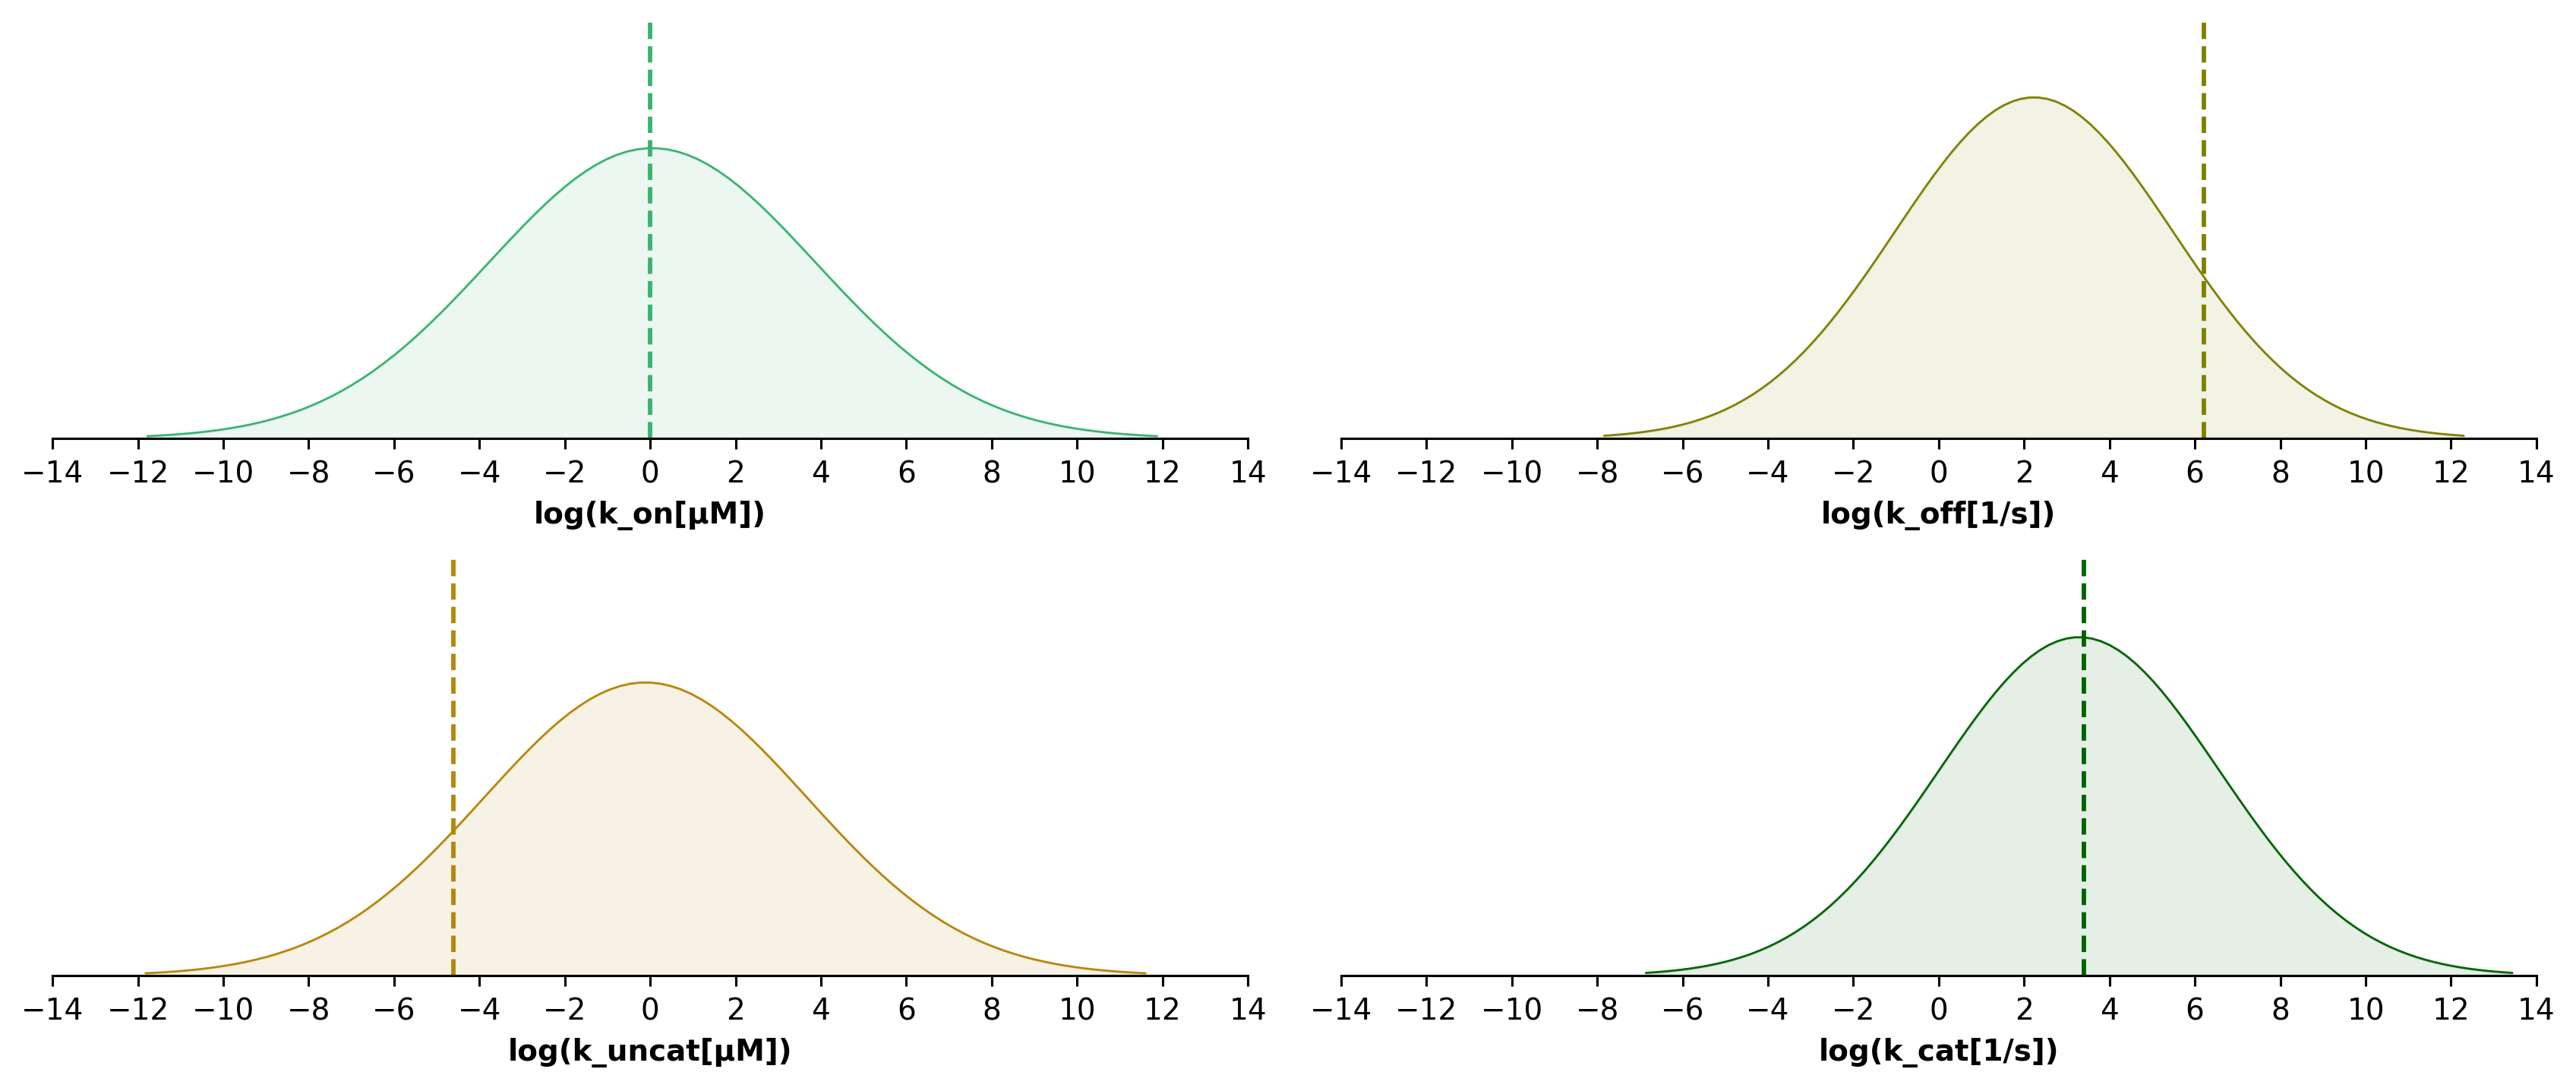

In [30]:
#collapse
# plot log-space kinetic parameter distributions, with default parameters presented previously overlaid
fig, axs = plt.subplots(2,2,constrained_layout=True)

def plot_distrib(distrib, ax, title, param):
    ax.set_xlim(-14,14)
    ax.set_ylim(0,0.15)

    x = np.linspace(distrib.ppf(0.001), distrib.ppf(0.999), 100)
    y = distrib.pdf(x)
    color = c[param]

    ax.plot(x, y, '-', lw=0.7, color=color)
    ax.fill_between(x, 0, y, color=color, alpha=0.1)
    ax.axvline(np.log(default_kinetic_params[param]), 0, 1, linestyle='--', color=color)

    ax.xaxis.set_ticks(np.arange(-14, 14.01, 2))
    ax.set_xlabel(title,  weight='bold')
    fig_style_2(ax)

plot_distrib(log_kon_normal, axs[0][0], 'log(k_on[µM])', 'k_on')
plot_distrib(log_koff_normal, axs[0][1], 'log(k_off[1/s])', 'k_off')
plot_distrib(log_kuncat_normal, axs[1][0], 'log(k_uncat[µM])', 'k_uncat')
plot_distrib(log_kcat_normal, axs[1][1], 'log(k_cat[1/s])', 'k_cat')

#### 3.1.2. Likelihood

We need to define a likelihood $p(D|\theta)$ which measures the probability of producing the observed data given settings of the kinetic parameters $\theta = \{\kon, \koff, \kcat, \kuncat\}$. Our data $D = \{\mathrm{obs}_{[\mathrm{P}]}(t) \, ; t \in 0...0.5\}$ are an observed trajectory of concentrations of reaction <span style='color:#00008b'>product <b>P</b></span>. Each setting of the kinetic parameters corresponds to a trajectory of concentrations of P (via a numerical integration). Intuitively, parameter sets which result in trajectories very near the observed trajectory are more likely. Therefore, our likelihood should measure the distance between the observed $\{\mathrm{obs}_{[\mathrm{P}]}(t) \, ; t \in 0...0.5 \}$ and predicted $\{ u_{[\mathrm{P}]}(t, \theta) \, ; t \in 0...0.5\}$. 

How far should the predicted trajectory be allowed to stray from the measured $\{\mathrm{obs}_{[\mathrm{P}]}(t)  \}$? The likelihood is really our statement about the presumed noise in our measurements. If we believe our measurements to be noiseless, then our likelihood should concentrate tightly around our measurements (a [dirac $\delta$](https://en.wikipedia.org/wiki/Dirac_delta_function) in the limit), and we would only admit kinetic parameters that interpolate the observed $\{\mathrm{obs}_{[\mathrm{P}]}(t) \}$ almost exactly. In reality, no measurement is noiseless, so we propose the following noise model: 

Supposing the detection of each molecule of P is an independent binary random variable with error rate $\sigma$ then the aggregate random variable $\mathrm{N}_{[\mathrm{P}]}(t)$ is gaussian-distributed $\sim \mathcal{N}( \mathrm{obs}_{[\mathrm{P}]}(t), \, \sigma \cdot \sqrt{ \mathrm{obs}_{[\mathrm{P}]}(t)} )$. The variance of the gaussian grows as the square root of the mean, via a Central Limit Theorem argument. We can represent this noise model (and consequently, likelihood) visually as: 


In [31]:
σ = 5 # arbitrary magic number represents detection noise level

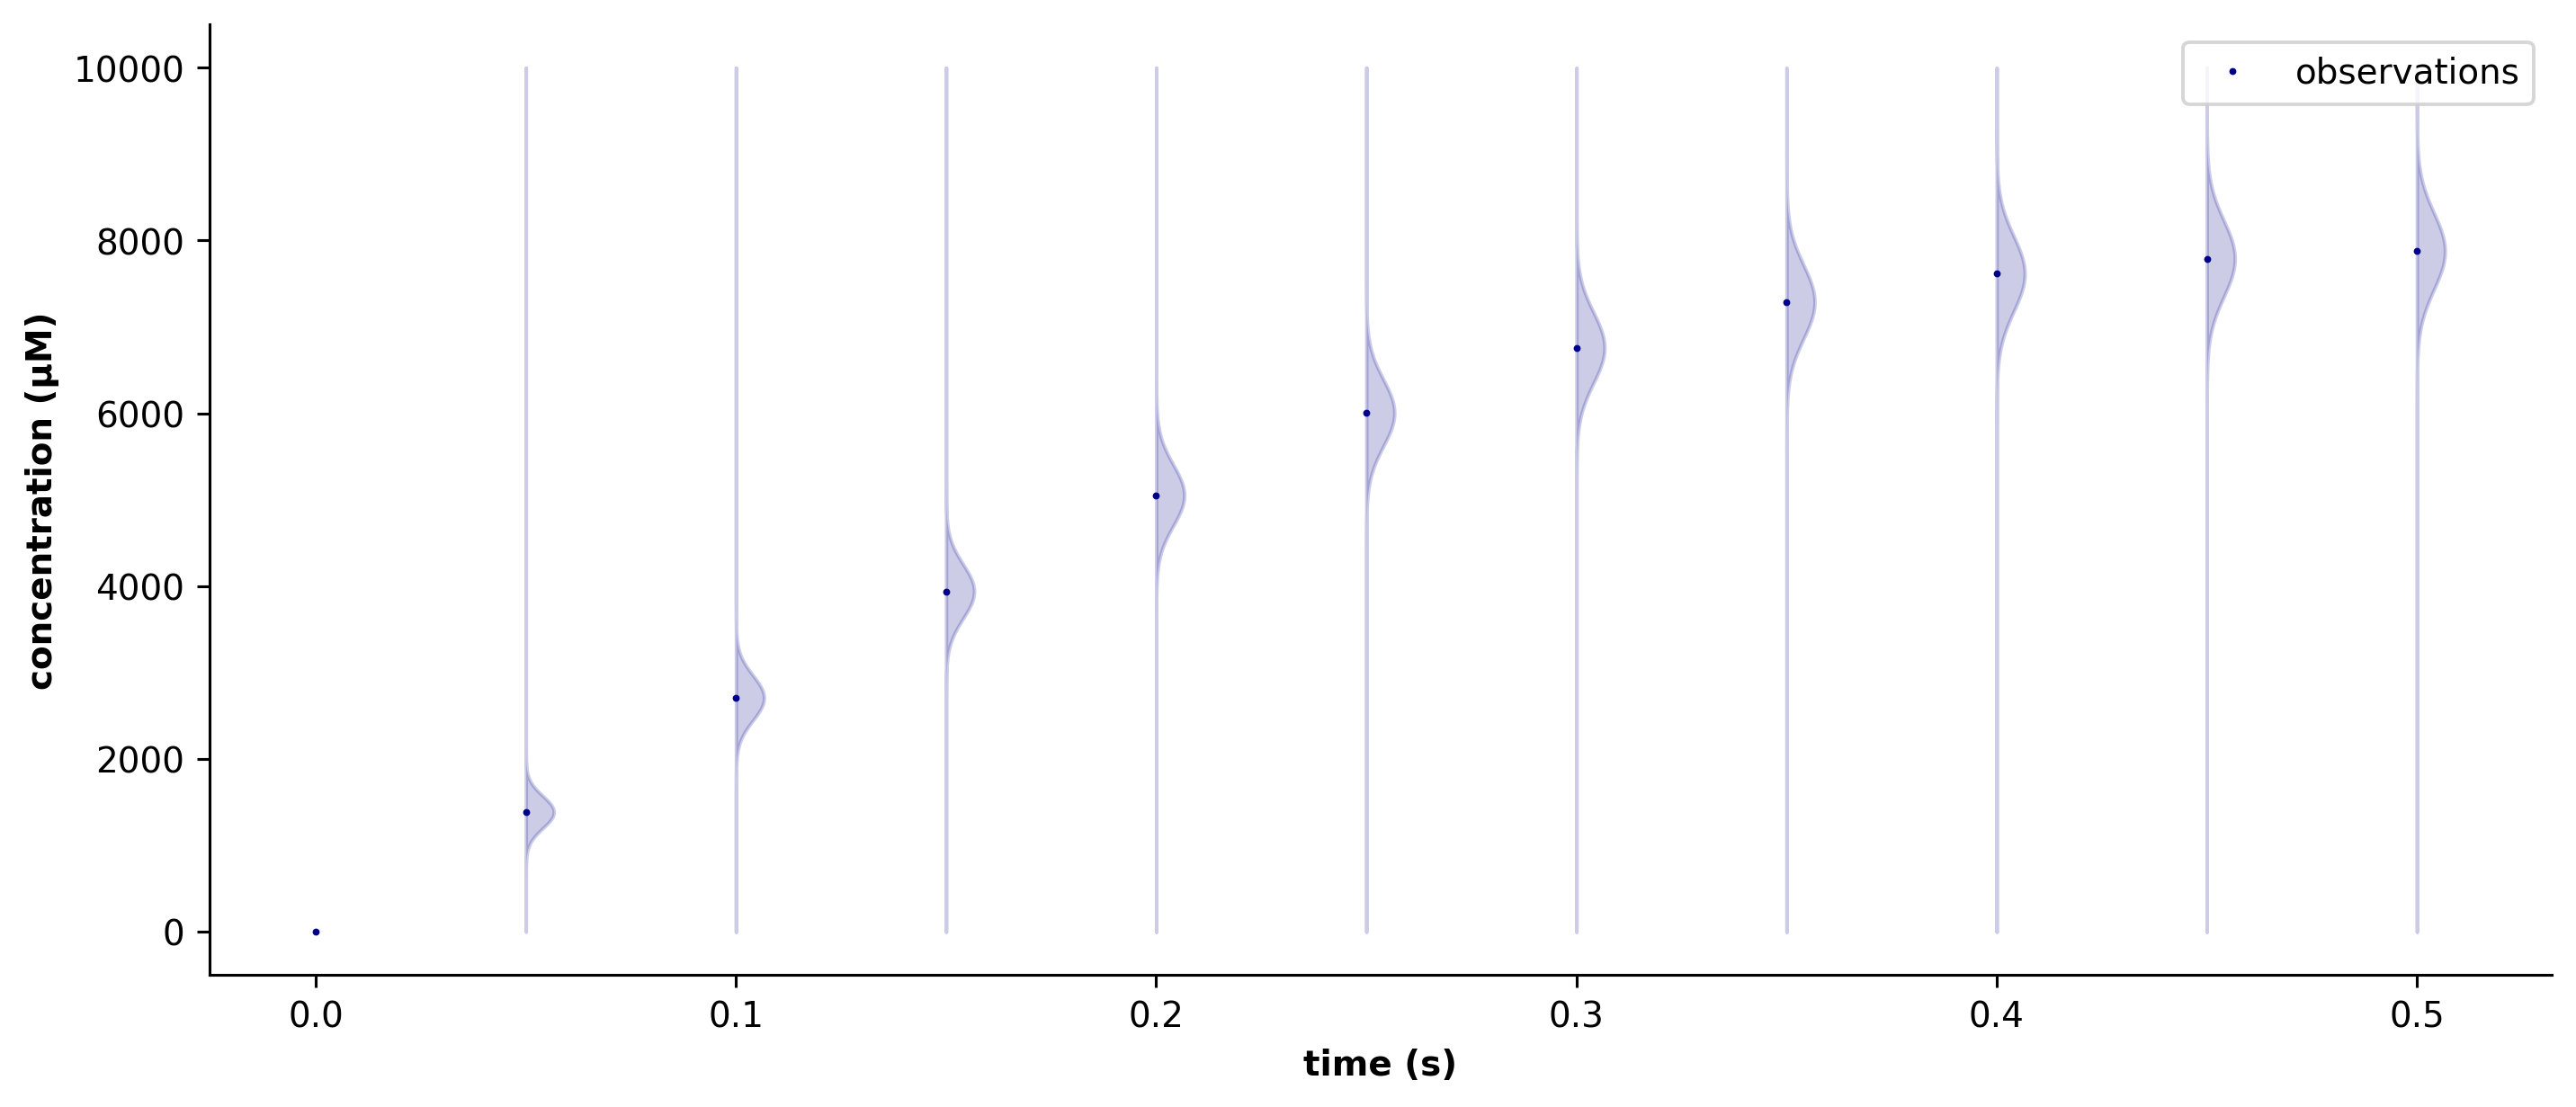

In [32]:
#collapse
# plot intuition for likelihood definition
plt.rcParams['figure.figsize'] = [12, 5]

ax = observations.rename('observations').plot.line(marker='.', lw=0, color=color(['P']), legend=True, markersize=2)

domain = np.linspace(0,10000,1000)

for x, y in observations.iloc[1:].items():
    distrib = scipy.stats.norm(loc=y, scale=np.sqrt(y)*σ)
    ax.fill_betweenx(domain, [x]*1000, x2=x+distrib.pdf(domain)/distrib.pdf(y)/150, color=color(['P']), alpha=0.2)

fig_style(ax)

Concretely, the likelihood is the product distribution of each of the gaussian marginals centered around the measurements. These form a multivariate normal, diagonal since we neglect to add covariances.

$$p(D|\theta) = \displaystyle \prod_{t=0}^{0.5} p_t \left(u_{[\mathrm{P}]}(t, \theta)\right) \textrm{  where  } p_t \textrm{  is the density of  }  \mathrm{N}_{[\mathrm{P}]}(t) \sim \mathcal{N} \left( \mathrm{obs}_{[\mathrm{P}]}(t), \, \sigma \cdot \sqrt{ \mathrm{obs}_{[\mathrm{P}]}(t) } \right)$$

Which leaves us with a "hyperparameter"  $\sigma$, which we have set arbitrarily above. 

In [33]:
likelihood_dist = multivariate_normal(mean=observations.values[1:], cov=σ * np.diag(sqrt(observations.values[1:])))

def likelihood_logpdf(ut): return likelihood_dist.logpdf(ut)

#### 3.1.3. Metropolis-Hastings

In [34]:
# collapse
# define simulated_measurements()
def exp_params(log_kinetic_params):
    return {name: exp(val) for name, val in log_kinetic_params.items()}

def simulate_measurements(kinetic_params):
    u = integrate_scipy_full(kinetic_params)
    return (u.loc[measurement_times, 'P'].ravel()[1:] if len(u) > 0 else np.zeros(10))


We can now evaluate the prior $p(\theta)$ and the likelihood $p(D|\theta)$ of kinetic parameters $\theta = \{\kon, \koff, \kcat, \kuncat\}$. Those two distributions permit us to elaborate an Markov Chain Monte Carlo (MCMC) routine to sample from the posterior $p(\theta|D) \propto p(D|\theta) \cdot p(\theta)$. The algorithm is as follows: 

Repeat: 
1. Draw kinetic parameters from the proposal distribution. 
2. Integrate the system with the proposed kinetic parameters.
3. Evaluate the likelihood of the trajectory generated in step 2.
4. Accept/Reject the proposal by a Metropolis-Hastings criterion.
5. Append the current kinetic parameters to the Markov Chain. 
5. Construct a proposal distribution around the current kinetic parameters.


Since the likelihood assigns most of the probability mass to a fairly narrow region of parameter space, most parameter sets have extremely low probability. In order to preserve some numerical stability, we log-transform the typical Metropolis-Hastings expressions. So typically $π_t = \mathrm{likelihood\_pdf}(u_t) \cdot \mathrm{prior\_pdf}(θ_t)$ and the acceptance criterion is $\frac{π_{t+1}}{π_t} > \mathrm{rand}([0,1])$. In log space, the acceptance criterion becomes: $\log(π_{t+1}) - \log(π_t) > \log(\mathrm{rand}([0,1]))$ with $\log(π_t) = \mathrm{likelihood\_logpdf}(u_t) + \mathrm{prior\_logpdf}(θ_t)$.




In [35]:
def MH_MCMC(chain_length=1e3):

    θt = sample_prior()
    ut = simulate_measurements(exp_params(θt))
    πt = likelihood_logpdf(ut) + prior_logpdf(**θt)
    if all(ut == 0): return MH_MCMC(chain_length)

    cov = np.eye(4) * 5e-4
    i = 0
    accept_ratio = 0
    chain = []
    samples = []

    while i < chain_length:

        θtp1 = proposal(θt, cov)
        utp1 = simulate_measurements(exp_params(θtp1))
        πtp1 = likelihood_logpdf(utp1) + prior_logpdf(**θtp1)

        if πtp1 - πt > np.log(np.random.rand()):

            θt, ut, πt = θtp1, utp1, πtp1
            accept_ratio += 1

        chain.append(θt)
        samples.append(ut)

        i += 1

        if i % 100 == 0 and i > 300:
            # cov = pd.DataFrame(chain[100:]).cov()
            print(i, end='\r')

    chain = pd.DataFrame(chain)
    samples = pd.DataFrame(np.hstack((np.zeros((len(chain), 1)), samples)), columns=observations.index)
    accept_ratio = accept_ratio/chain_length

    return chain, samples, accept_ratio


Our proposal density for the time being can be a simple isotropic gaussian around the current parameters.

In [36]:
def proposal(θt, cov):

    μ = [θt['k_on'], θt['k_off'], θt['k_cat'], θt['k_uncat']]

    θtp1 = dict(zip(['k_on', 'k_off', 'k_cat', 'k_uncat'], np.random.multivariate_normal(μ, cov)))

    return θtp1


Now let's put it into practice:

In [37]:
chain_length = 1e3
chain, samples, accept_ratio = MH_MCMC(chain_length=chain_length)
print('accept_ratio:', accept_ratio)

accept_ratio: 0.426


In [38]:
def fig_style_3(ax):
    for side in ["right","top"]: ax.spines[side].set_visible(False)
    ax.set_xlabel('chain',  weight='bold')
    ax.set_ylabel('log parameter values',  weight='bold')

In [39]:
def plot_chain(chain, ax=None):
    '''Note: chain is expected to be in log-parameter space (natural log)'''
    if ax is None: fig, ax = plt.subplots()
    chain.plot.line(xlim=(0,len(chain)), color=[c[param_name] for param_name in chain.columns], ax=ax)

    for param_name in chain.columns:
        param_value = default_kinetic_params[param_name]
        ax.axhline(np.log(param_value), lw=0.5, color=c[param_name], linestyle='--')
        ax.fill_between(np.arange(len(chain)), chain[param_name], np.repeat(np.log(param_value), len(chain)), color=c[param_name], alpha=0.05)

    fig_style_3(ax)

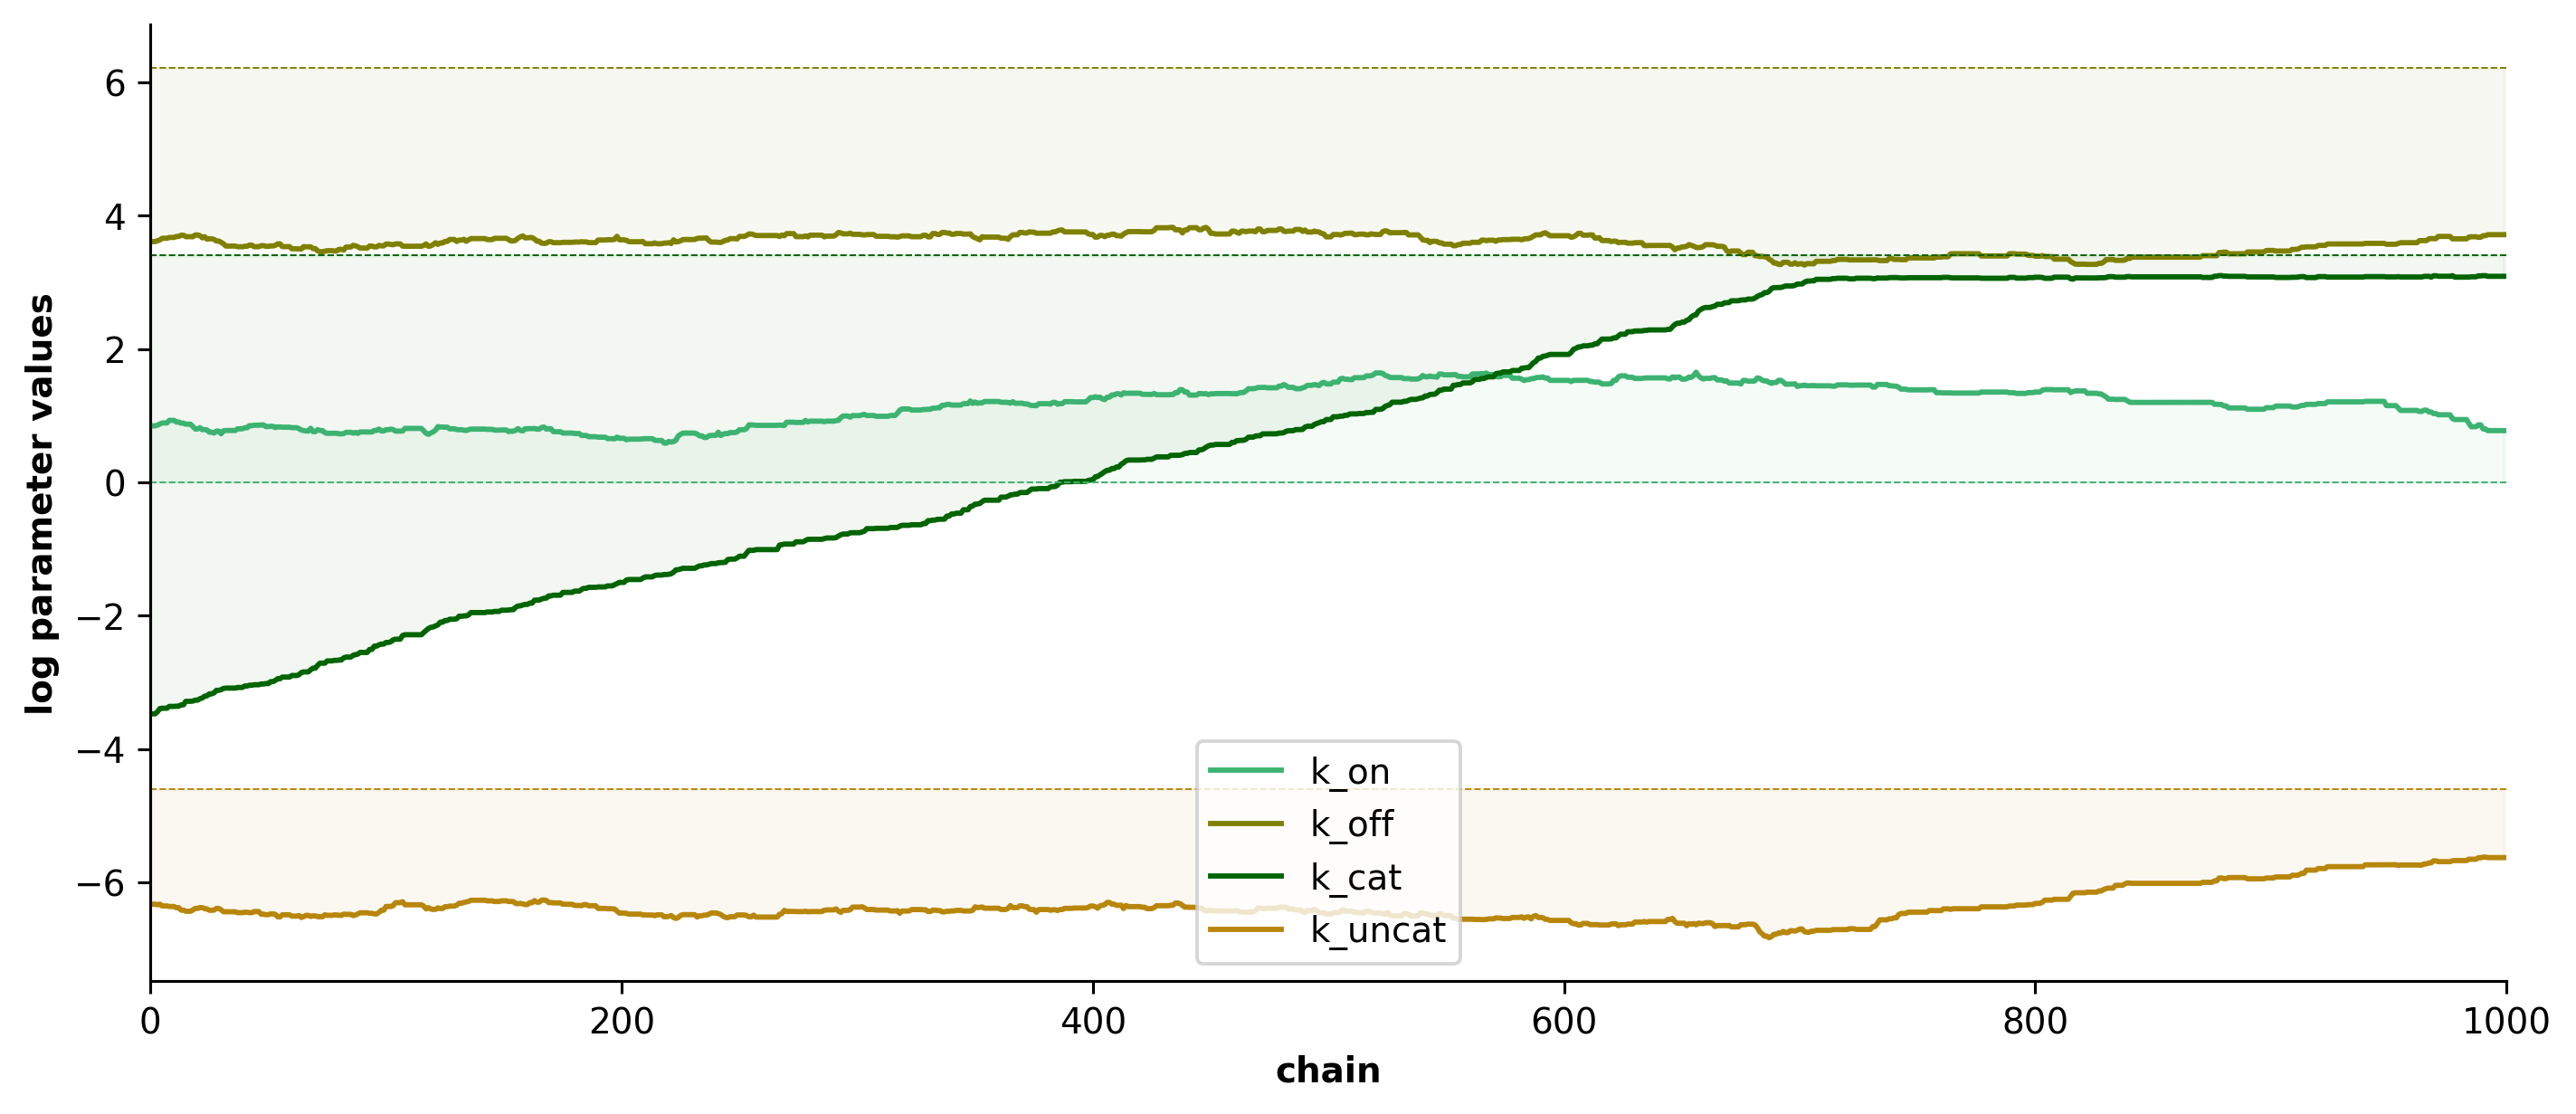

In [40]:
plot_chain(chain)

In [ ]:
sns.pairplot(chain, kind="kde")
HTML(resize_fig(600, 600))

In [42]:
def plot_samples(samples, ax=None):
    if ax is None: fig, ax = plt.subplots()
    alpha = max(1/np.sqrt(len(samples)), 0.1)
    observations.plot.line(marker='o', lw=0, color=c['P'], ylim=(-300, 10800), ax=ax, legend=True)
    samples.T.plot.line(colormap=plt.get_cmap('plasma'), alpha=alpha, ax=ax, legend=False, zorder=1)
    fig_style(ax)

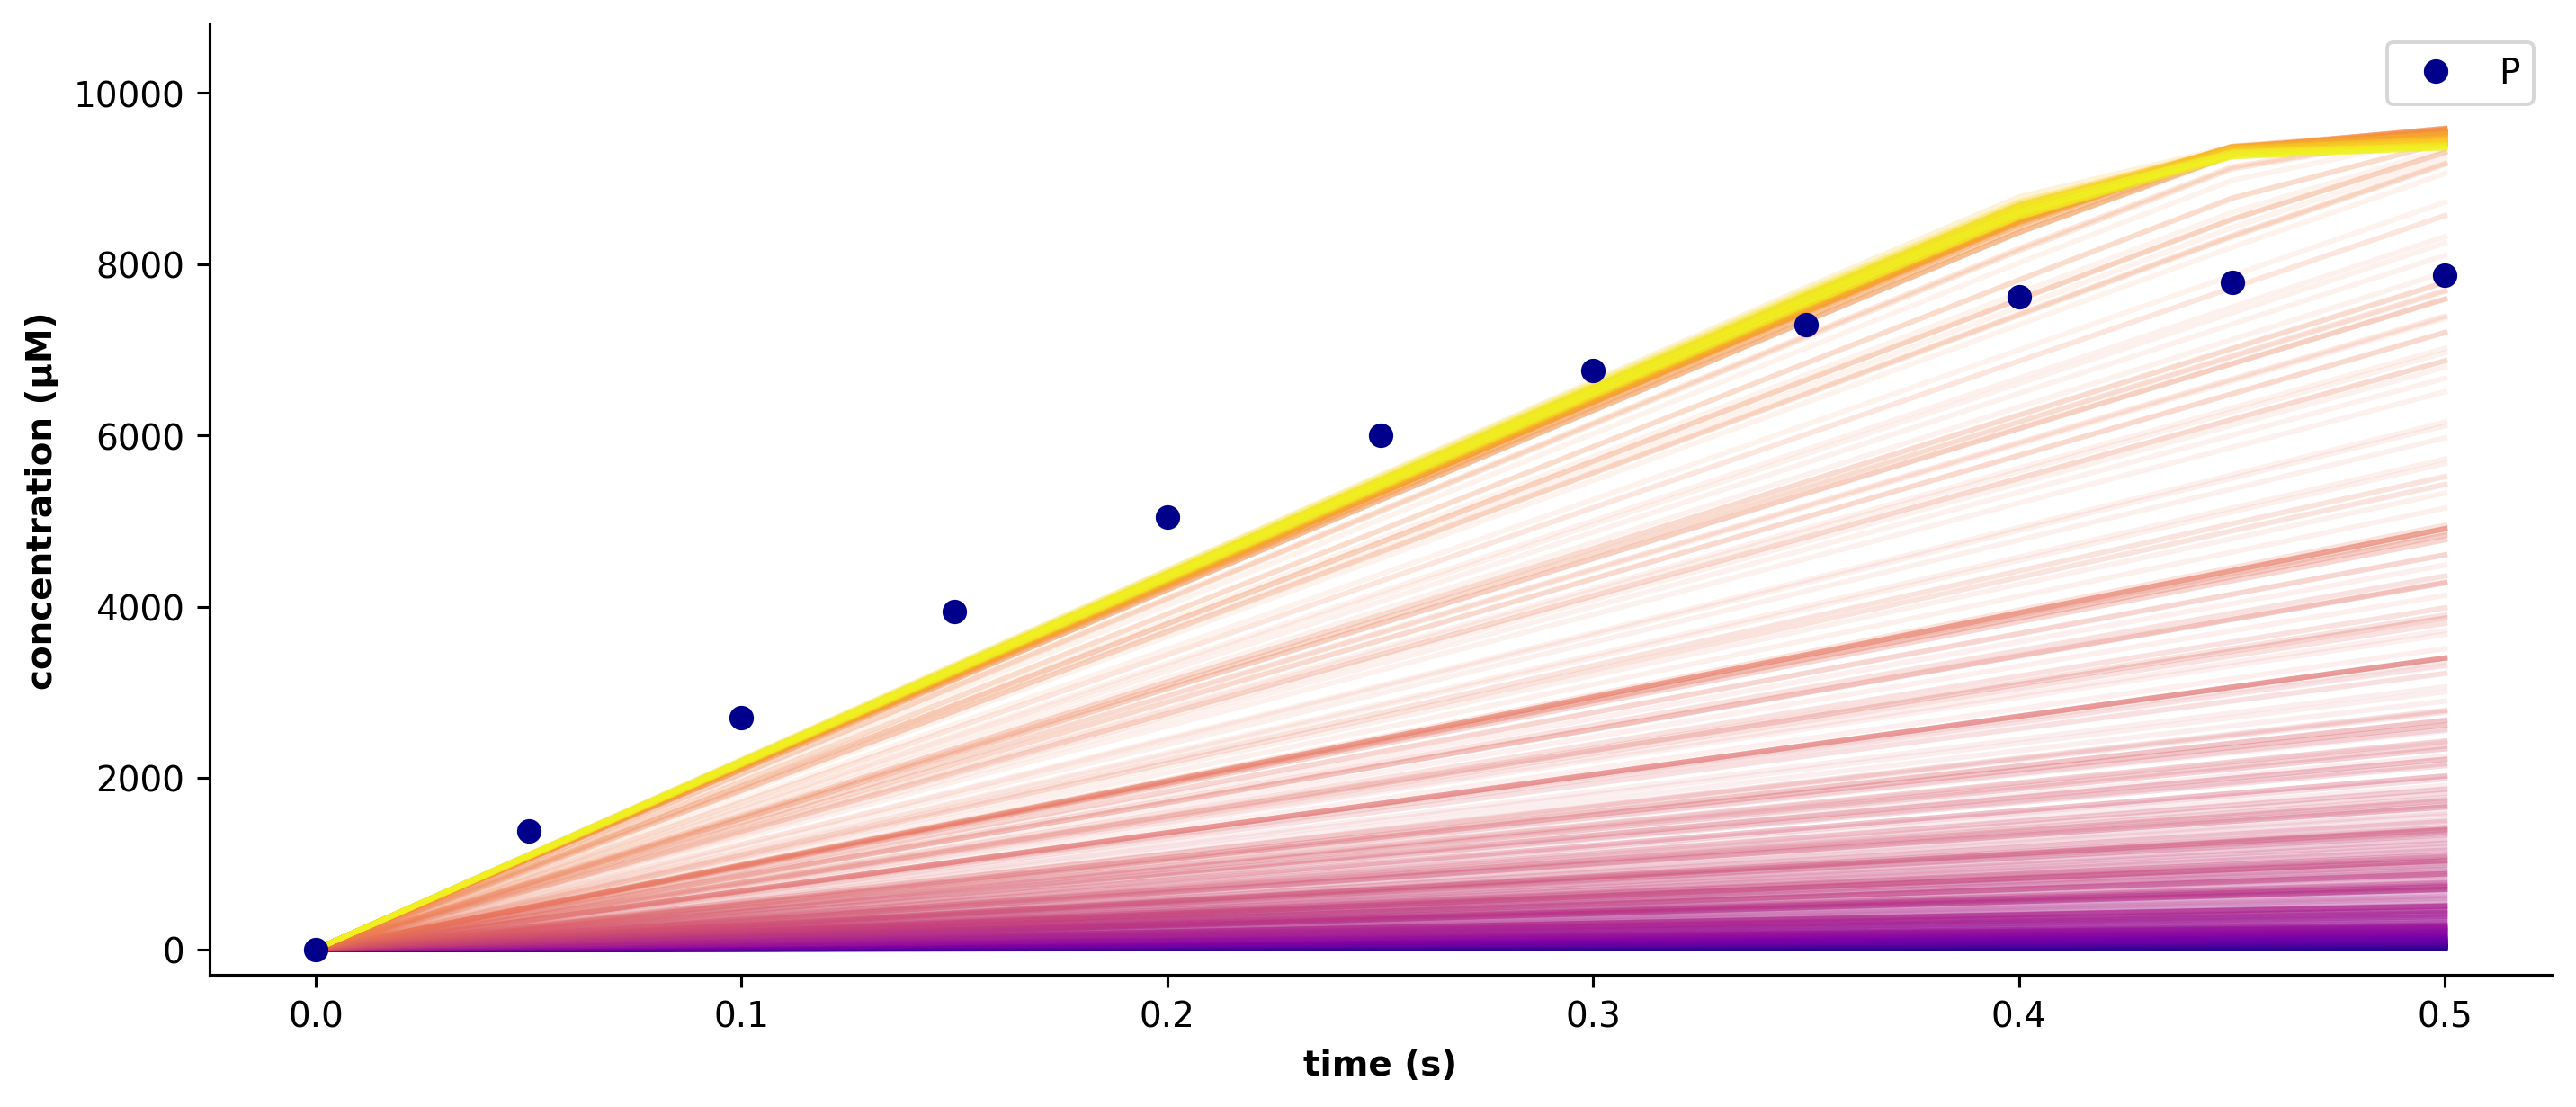

In [43]:
plot_samples(samples)

In [44]:
def MCMC_run():
    chain, samples, accept_ratio = MH_MCMC(chain_length=chain_length)
    fig, axs = plt.subplots(1, 2)
    plot_chain(chain, ax=axs[0])
    plot_samples(samples, ax=axs[1])
    print('accept_ratio:', accept_ratio)
    return chain, samples, accept_ratio

accept_ratio: 0.272


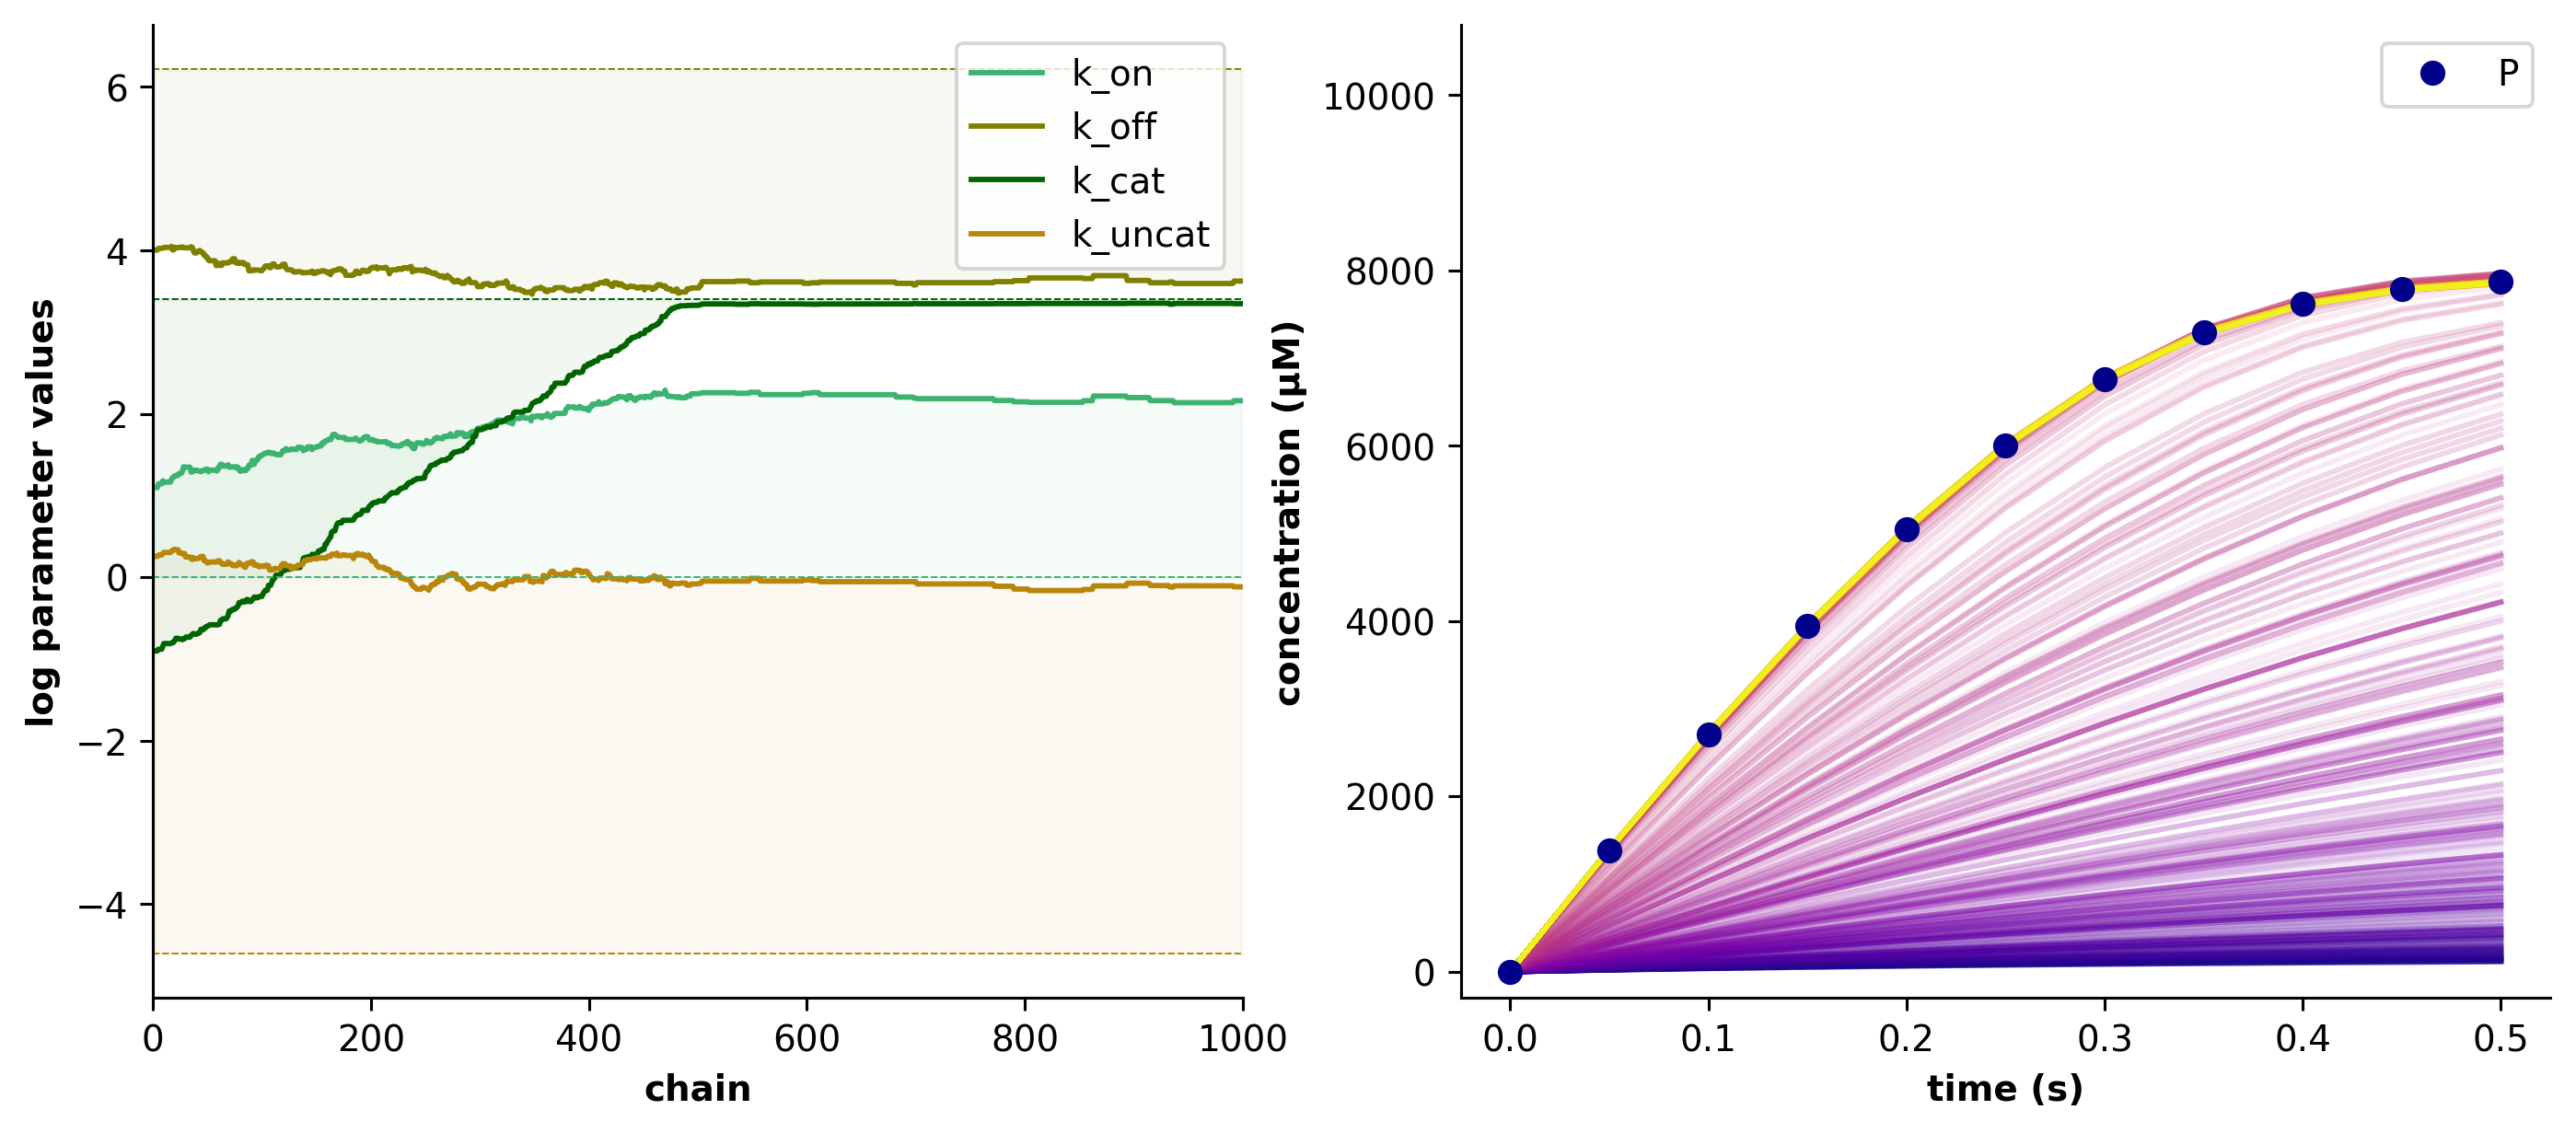

In [45]:
chain_1, samples_1, accept_ratio_1 = MCMC_run()

accept_ratio: 0.082


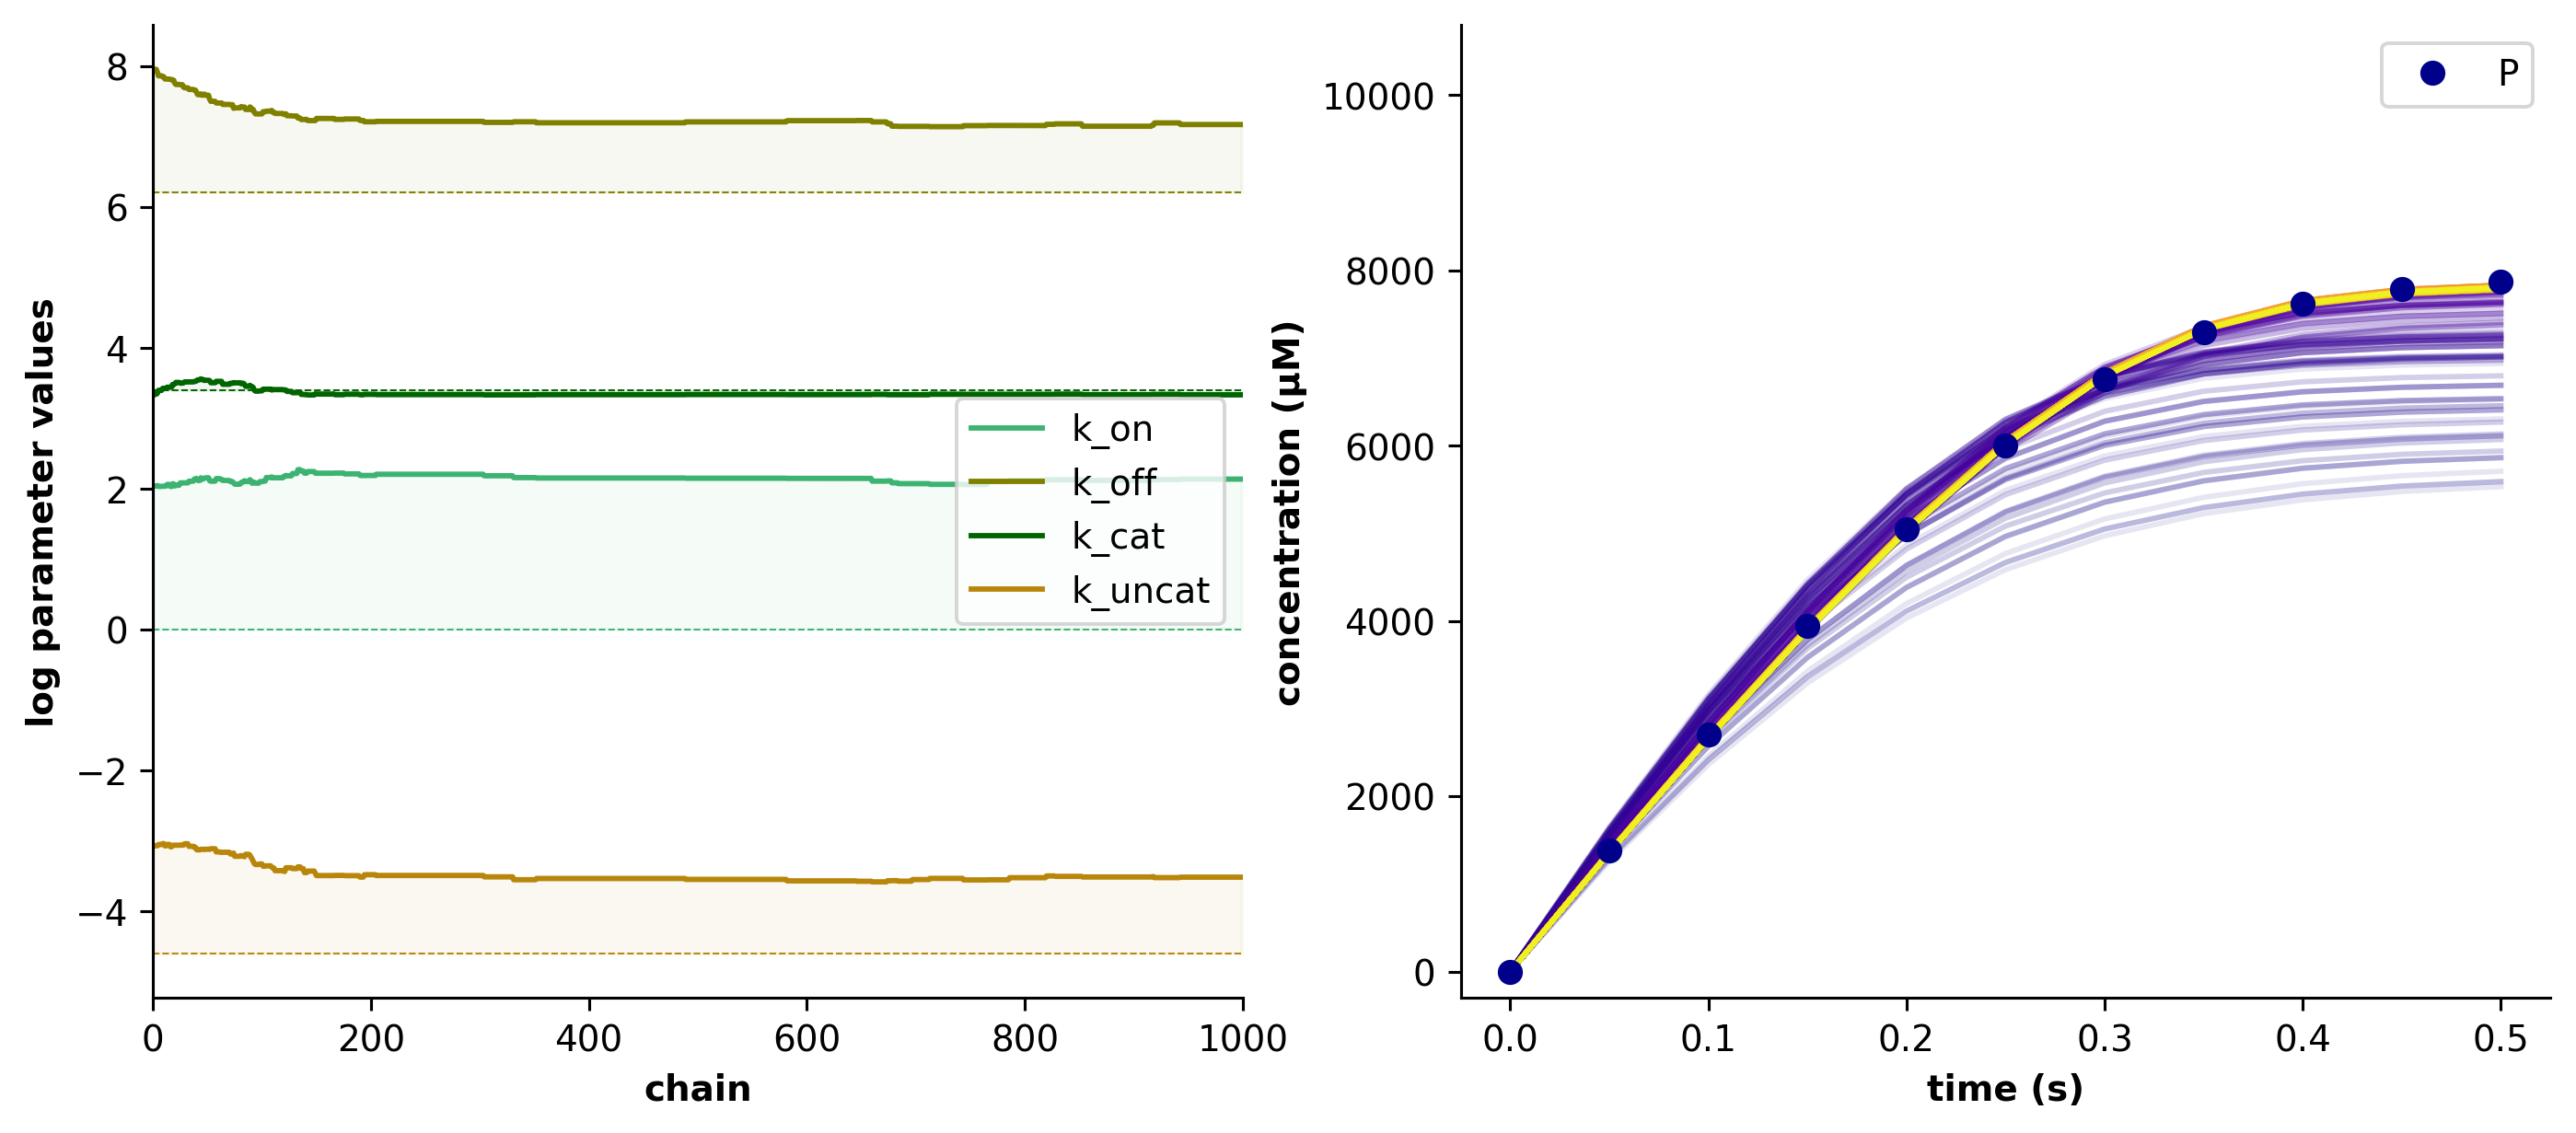

In [46]:
chain_2, samples_2, accept_ratio_2 = MCMC_run()

accept_ratio: 0.225


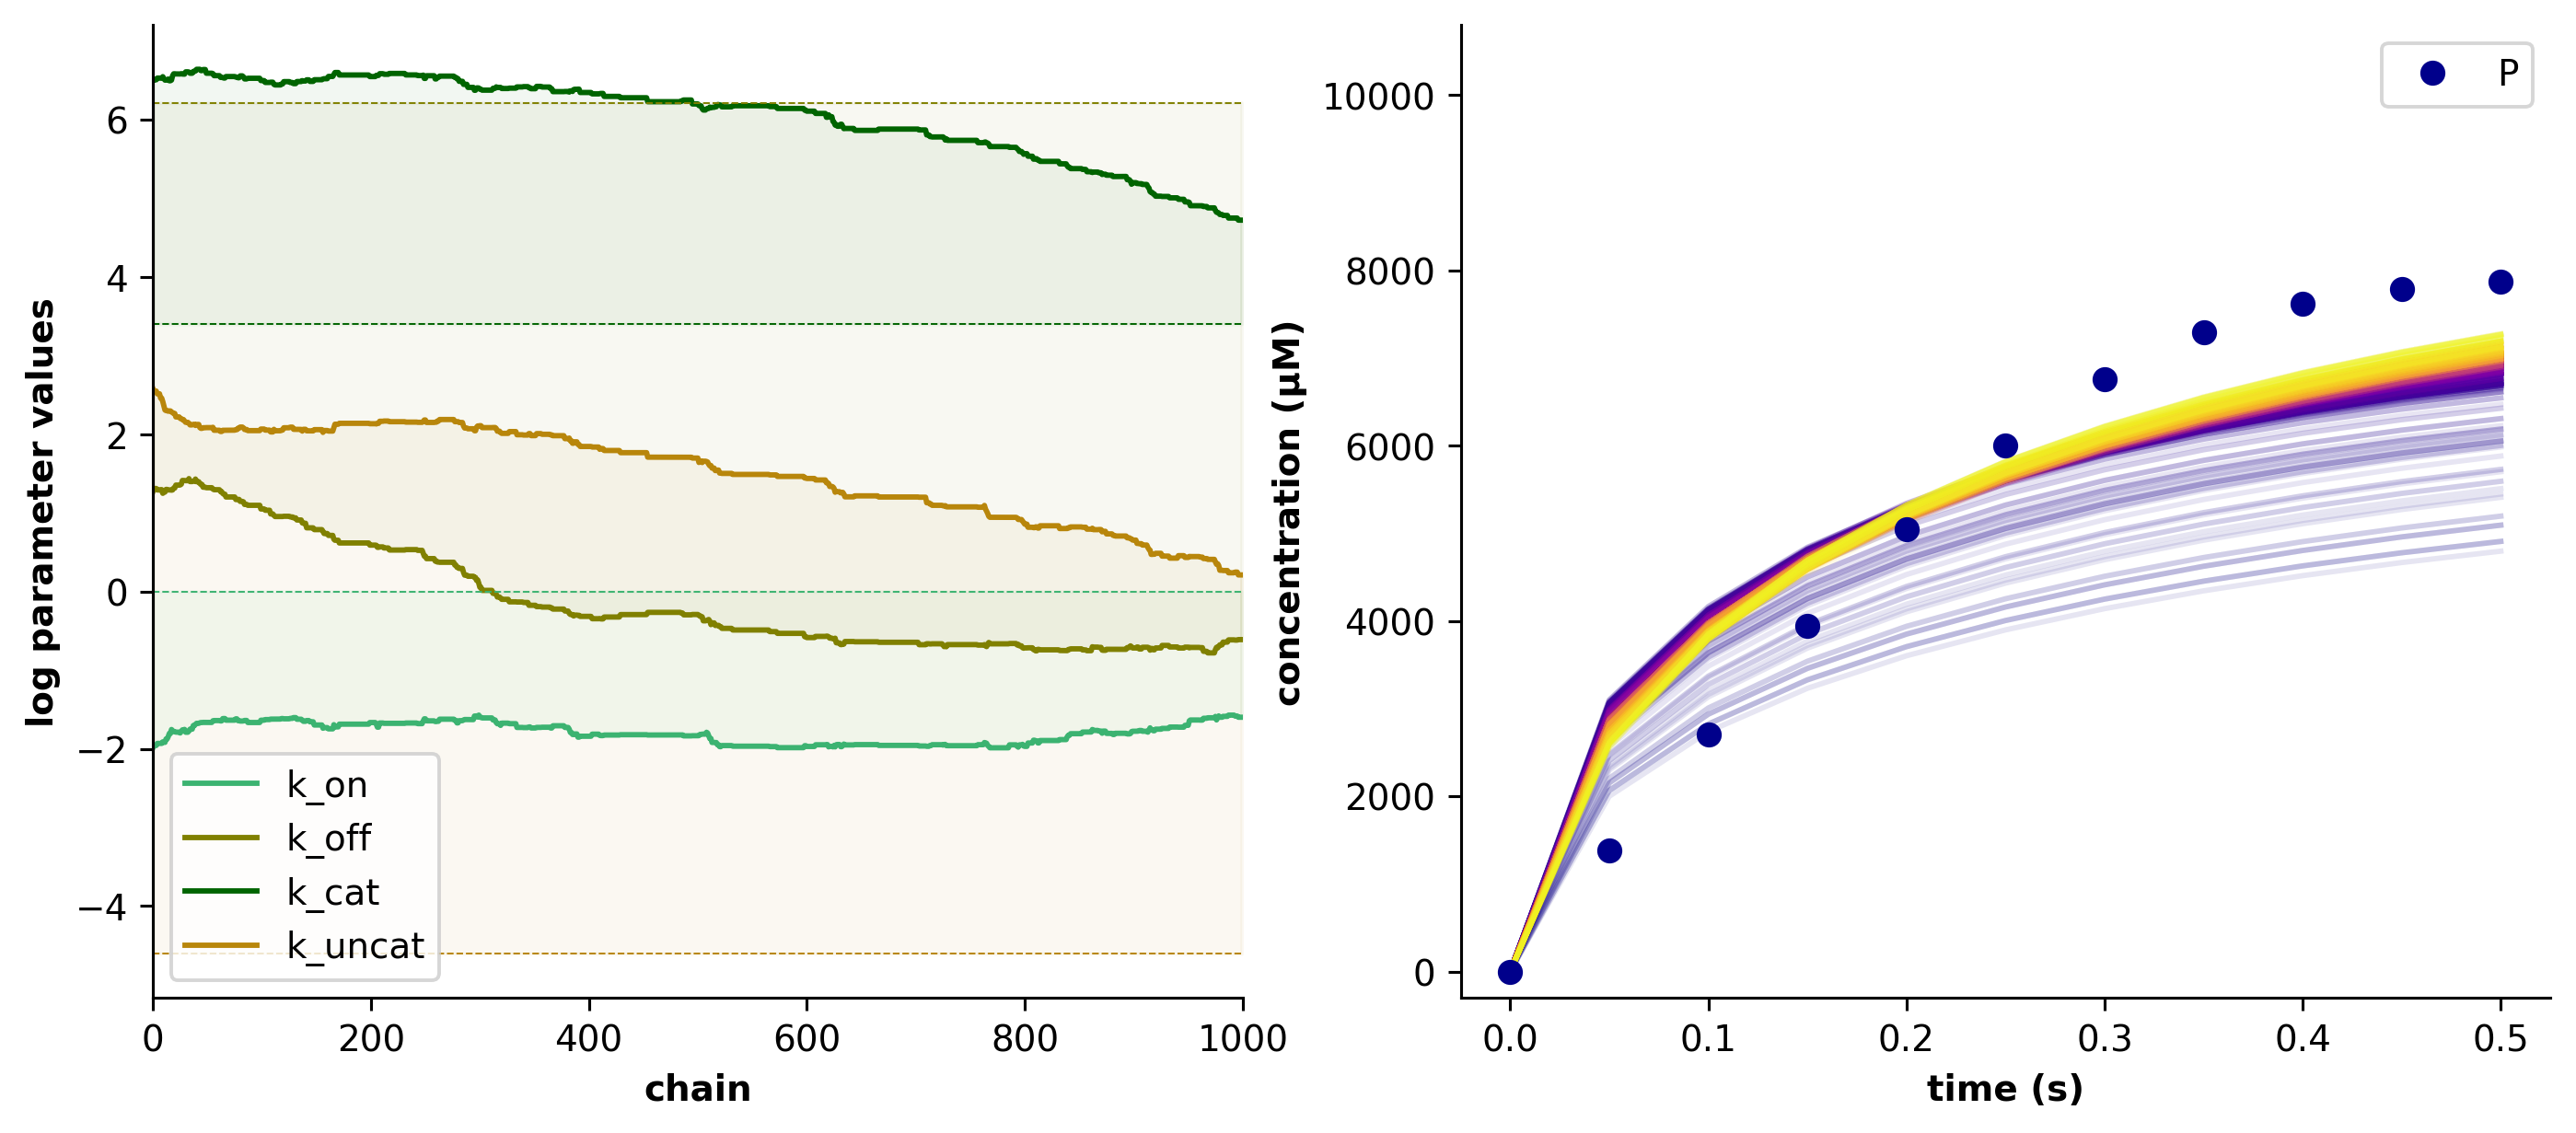

In [47]:
chain_3, samples_3, accept_ratio_3 = MCMC_run()

The above chains tell us something interesting: it appears to be possible to closely fit the observed data with very different parameter sets than the ones used to generate the observed trajectory. There must exist some subspace of parameters which yield similar $[\mathrm{P}](t)$ curves. We'll explore the topic of parameter _identifiability_ in a future blog post. 



### 3.2 Frequentist Approach: Inference by Optimization

In the previous section, we conducted a random walk in parameter space, biasing our random walk towards regions of the parameter space where both the prior probability and likelihood were greater. After a certain number of samples (the "burn in" phase), the samples from our random walk could be said to be drawn from the (exact) posterior distribution over the kinetic parameters. 

An alternative approach begins with another premise: 
- Suppose we want to incorporate no **prior** knowledge, and let the timeseries data _alone_ govern our determination of our enzyme's kinetic parameters.
- Suppose as well that instead of searching for a distribution of plausible parameters, we're only interested in finding the _single most likely set_ of parameters. 

These two choices recast the inference task as an optimization problem. We'll explore two approaches to optimize the kinetic parameters to fit the observed data.


#### 3.2.1. Forward Sensitivities

Optimization problems require an objective, such as minimizing a loss (or cost) function. Let's use the conventional squared error between our observations $\mathrm{obs}(t)$ and our trajectory $u(t, \theta)$ at the observed timepoints, scaled in accordance with the basic noise model we described in [§3.1.2](#3.1.2.-Likelihood):  $G(u(t, \theta)) = \displaystyle\sum_{t \in \mathrm{obs}} \left(\frac{ \mathrm{obs}(t) - u(t, \theta)}{\sigma \cdot \sqrt{\mathrm{obs}(t)}}\right)^2$. 


In [48]:
def loss(u):
    if len(u) == 0: return np.nan
    return sum(((observations - u.loc[observations.index, 'P'])/(σ * np.sqrt(observations))).dropna()**2)

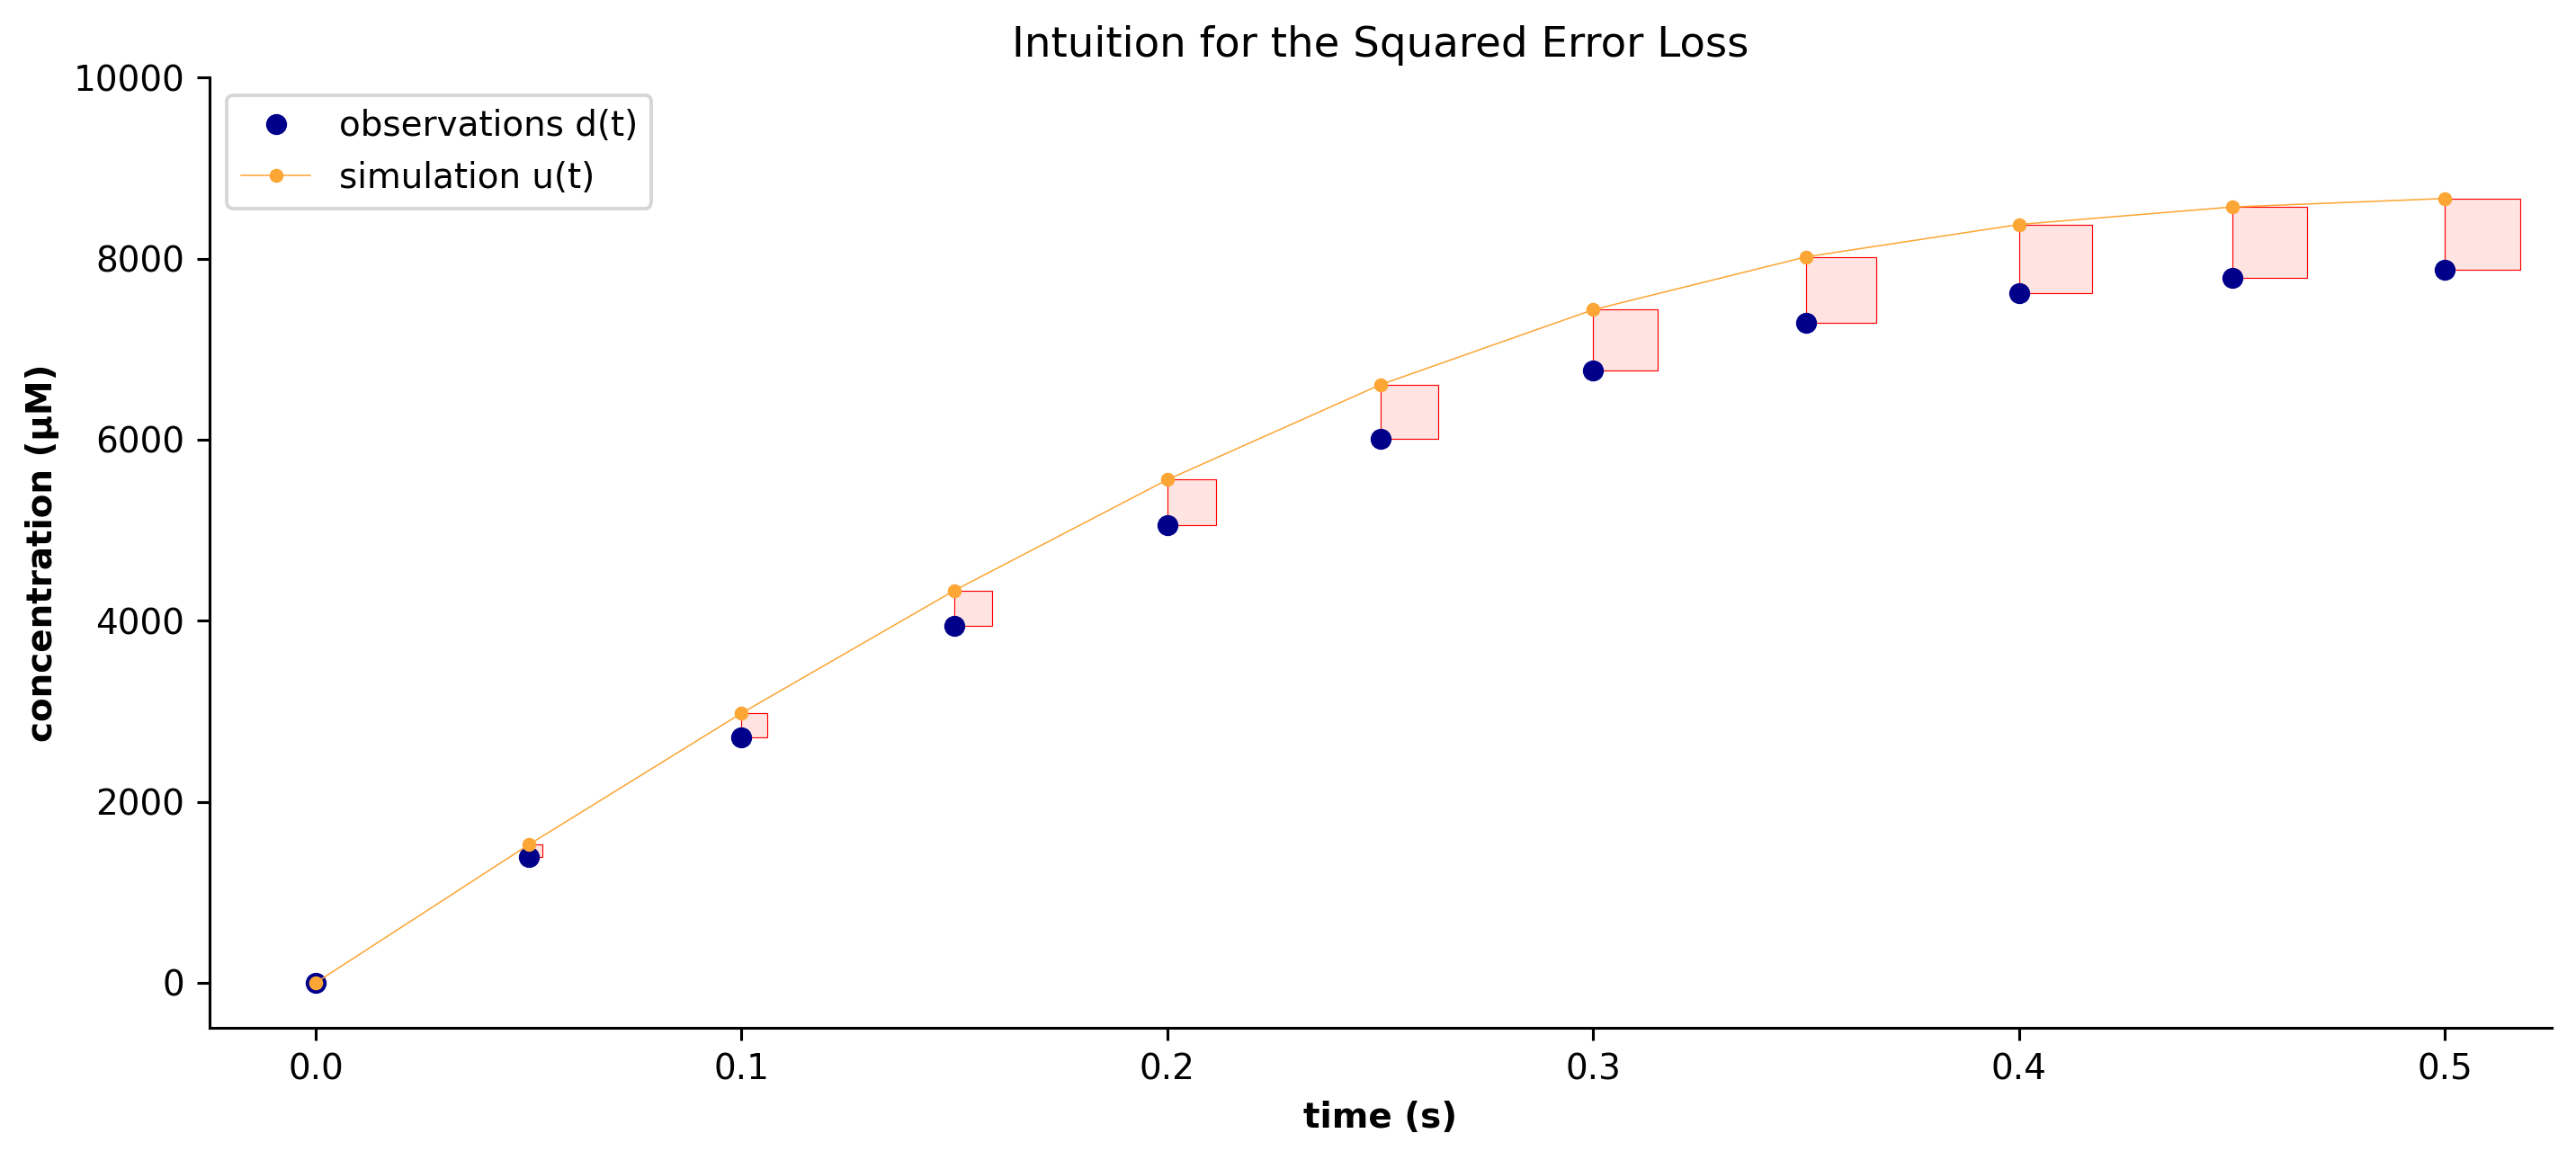

In [49]:
#collapse
# plot intuition for squared loss definition
plt.rcParams['figure.figsize'] = [12, 5]

ax = observations.rename('observations d(t)').plot.line(marker='o', lw=0, color=color(['P']), legend=True, markersize=5, ylim=(-5e2,1e4), title='Intuition for the Squared Error Loss')
(observations * 1.1).rename('simulation u(t)').plot.line(marker='o', lw=0.4, color=plt.get_cmap('plasma')(0.8), legend=True, markersize=3)

# total_err = 0

for x, y in observations.iloc[1:].items():
    rect = patches.Rectangle((x, y), y*0.1/1e4*0.225, y*0.1, linewidth=1, edgecolor='r', facecolor='mistyrose', lw=0.3)
    ax.add_patch(rect)

fig_style(ax)

In order to optimize $\theta$ with respect to to our loss function $G$, we need a means to evaluate the gradient of the loss with respect to the parameters. Recall the gradient is the vector of first derivatives of $G$ with respect to each parameter $\theta_i$. The simplest way to compute each entry of the gradient ($\frac{dG(u(t, \theta))}{d\theta_i}$) would be to evaluate $G$ slightly above and below $\theta_i$ to numerically approximate the first derivative. Concatenating those (for each $\theta_i$) would yield a numerical approximation of the gradient vector. This technique is called Finite Differences, and it's valid, though impractical. We'll implement it to check the validitiy of gradients we compute by other means. 


In [50]:
def finite_differences(θ):

    grad = {}
    for k,v in θ.items():
        ϵ = np.sqrt(v * 1e-15)
        grad[k] = (loss(integrate_scipy_full({**θ, **{k:v+ϵ}})) - loss(integrate_scipy_full({**θ, **{k:v-ϵ}}))) / (2*ϵ)

    return grad

Beyond Finite Differences, we might try to analytically derive some other expression for the gradient: 

$$\frac{dG(u(t, \theta))}{d\theta} = 
\frac{d}{d\theta} \sum_{t \in \mathrm{obs}} \left(\frac{ \mathrm{obs}(t) - u(t, \theta)}{\sigma \cdot \sqrt{\mathrm{obs}(t)}}\right)^2 = 
\sum_{t \in \mathrm{obs}} \left[ 2\left(\frac{ \mathrm{obs}(t) - u(t, \theta)}{(\sigma \cdot \sqrt{\mathrm{obs}(t)})^2}\right) \cdot \frac{-du(t, \theta)}{d\theta} \right]$$

However, the quantity $\frac{du(t, \theta)}{d\theta}$ (called the _sensitivity_ of the solution to a parameter) is not immediately available. We can derive it as follows: 

Our original differential equation is $\frac{du(t, \theta)}{dt} = f(u(t, \theta), \theta)$. If we take $\frac{\partial}{\partial\theta} \left[ \frac{du(t, \theta)}{dt} \right] = \frac{\partial}{\partial\theta} \left[ f(u(t, \theta), \theta) \right]$, we can rearrange as 
$\frac{d}{dt} \left[ \frac{\partial u(t, \theta)}{\partial\theta} \right] = \frac{\partial}{\partial\theta} \left[ f(u(t, \theta), \theta) \right]$ and then integrate over $t$ for 

$$\int_{t_0}^T\frac{d}{dt} \left[ \frac{\partial u(t, \theta)}{\partial\theta} \right]dt = \int_{t_0}^T\frac{\partial}{\partial\theta} \left[ f(u(t, \theta), \theta) \right]dt = 
\int_{t_0}^T \left[ \frac{\partial f}{\partial u} \Big|_{u(t, \theta), \theta} \cdot \frac{\partial u}{\partial \theta}  + \frac{\partial f}{\partial \theta} \Big|_{u(t, \theta), \theta} \right] dt$$

What we've done is define an ODE whose solution (integral) is that missing quantity, the sensitivity $\frac{du(t, \theta)}{d\theta}$. This ODE is aptly named the forward sensitivity ODE. We can integrate both the original ODE and the sensitivity ODE forwards in time together. 

But first, we need to understand the constituent expressions: $\frac{\partial f}{\partial u} \Big|_{u(t, \theta), \theta}$ , $\frac{\partial u}{\partial \theta}$ and $\frac{\partial f}{\partial \theta} \Big|_{u(t, \theta), \theta}$

Recall, 

$$\frac{du}{dt} = \frac{d}{dt}\begin{bmatrix}[\mathrm{S}] \\ [\mathrm{E}] \\ [\mathrm{ES}] \\ [\mathrm{P}] \end{bmatrix} = \begin{bmatrix}
k_{\mathrm{off}}[\mathrm{ES}] - k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] \\
k_{\mathrm{off}}[\mathrm{ES}] - k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] + k_{\mathrm{cat}}[\mathrm{ES}] - k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\
- k_{\mathrm{off}}[\mathrm{ES}] + k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] - k_{\mathrm{cat}}[\mathrm{ES}] + k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\
k_{\mathrm{cat}}[\mathrm{ES}] - k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] 
\end{bmatrix} = f(u(t, \theta), \theta)$$

$\frac{\partial f}{\partial u} \Big|_{u(t, \theta), \theta}$ is the derivative of the derivative $f$ with respect to the state $u$. Since both the state $u$ and its derivative $f$ are 4D, this quantity is a 4x4 Jacobian: 

$$\frac{df}{du} = \begin{bmatrix}\frac{df}{[\mathrm{S}]} & \frac{df}{[\mathrm{E}]} & \frac{df}{[\mathrm{ES}]} & \frac{df}{[\mathrm{P}]} \end{bmatrix} = \begin{bmatrix}
-k_{\mathrm{on}}[\mathrm{E}] & -k_{\mathrm{on}}[\mathrm{S}] & k_{\mathrm{off}} & 0 \\
-k_{\mathrm{on}}[\mathrm{E}] & -k_{\mathrm{on}}[\mathrm{S}] - k_{\mathrm{uncat}}[\mathrm{P}] & k_{\mathrm{off}} + k_{\mathrm{cat}} & -k_{\mathrm{uncat}}[\mathrm{E}] \\
k_{\mathrm{on}}[\mathrm{E}] & k_{\mathrm{on}}[\mathrm{S}] + k_{\mathrm{uncat}}[\mathrm{P}] & -k_{\mathrm{off}} - k_{\mathrm{cat}} & k_{\mathrm{uncat}}[\mathrm{E}] \\
0 & -k_{\mathrm{uncat}}[\mathrm{P}] & k_{\mathrm{cat}} & -k_{\mathrm{uncat}}[\mathrm{E}]
\end{bmatrix}$$


In [51]:
#collapse
# define helper functions for euler_full_sensitivities()
def f_u_Jacobian(S, E, ES, P, k_on, k_off, k_cat, k_uncat):

    return np.array([
        [-k_on * E, -k_on * S, k_off, 0],
        [-k_on * E, -k_on * S - k_uncat * P, k_off + k_cat, -k_uncat * E],
        [k_on * E, k_on * S + k_uncat * P, -k_off - k_cat, k_uncat * E],
        [0, -k_uncat * P, k_cat, -k_uncat * E]
    ])



$\frac{\partial f}{\partial \theta} \Big|_{u(t, \theta), \theta}$ is the derivative of the derivative $f$ with respect to one of the parameters $k$. 

$$\frac{\partial f}{\partial k_{\mathrm{on}}} = 
\begin{bmatrix} -[\mathrm{E}][\mathrm{S}] \\ -[\mathrm{E}][\mathrm{S}] \\ [\mathrm{E}][\mathrm{S}] \\ 0 \end{bmatrix}, \qquad
\frac{\partial f}{\partial k_{\mathrm{off}}} = 
\begin{bmatrix} [\mathrm{ES}] \\ [\mathrm{ES}] \\ -[\mathrm{ES}] \\ 0 \end{bmatrix}, \qquad
\frac{\partial f}{\partial k_{\mathrm{cat}}} = 
\begin{bmatrix} 0 \\ [\mathrm{ES}] \\ -[\mathrm{ES}] \\ [\mathrm{ES}] \end{bmatrix}, \qquad
\frac{\partial f}{\partial k_{\mathrm{uncat}}} = 
\begin{bmatrix} 0 \\ -[\mathrm{E}][\mathrm{P}] \\ [\mathrm{E}][\mathrm{P}] \\ -[\mathrm{E}][\mathrm{P}] \end{bmatrix}, \qquad
$$


In [52]:
#collapse
# define helper functions for euler_full_sensitivities()
def f_k_on(S, E, ES, P): return np.array([[-E*S, -E*S, E*S, 0]]).T
def f_k_off(S, E, ES, P): return np.array([[ES, ES, -ES, 0]]).T
def f_k_cat(S, E, ES, P): return np.array([[0, ES, -ES, ES]]).T
def f_k_uncat(S, E, ES, P): return np.array([[0, -E*P, E*P, -E*P]]).T

cols = [v+u for u in ['', '_k_on', '_k_off', '_k_cat', '_k_uncat'] for v in ['S', 'E', 'ES', 'P']]


$\frac{\partial u}{\partial \theta}$ is the variable of integration, which means we only need to define a boundary condition for it, in this case, an initial value: 

$$ \frac{\partial u}{\partial \theta} \Big|_{t_0} = \frac{\partial}{\partial \theta} u(0, \theta) $$

But since in our case $u(0, \theta) = u(0) = 0$ does not depend on $\theta$, $\frac{\partial u}{\partial \theta} \Big|_{t_0} = 0$. 

Now we're ready to augment our original Euler method to compute both $\int_{t_0}^T\frac{du(t, \theta)}{dt} dt$ as before and add $\int_{t_0}^T\frac{\partial}{\partial\theta} \left[ f(u(t, \theta), \theta) \right] dt$. 

In [53]:
#collapse
# define integrate_euler_full_sensitivities(), which integrates the full kinetics and sensitivity ODE with Euler's Method
def integrate_euler_full_sensitivities(kinetic_params, dt=dt, steps=steps, initial_conditions=default_initial_conditions):

    k_on, k_off, k_cat, k_uncat, k_ms, k_mp = kinetic_params.values()
    S, E, ES, P = initial_conditions.values()

    u_k_on = np.zeros((4,1))
    u_k_off = np.zeros((4,1))
    u_k_cat = np.zeros((4,1))
    u_k_uncat = np.zeros((4,1))

    traj = [[S, E, ES, P, *u_k_on.flatten(), *u_k_off.flatten(), *u_k_cat.flatten(), *u_k_uncat.flatten()]]

    for i in range(int(steps)):

        S += (k_off * ES - k_on * E * S) * dt
        E += (k_off * ES - k_on * E * S + k_cat * ES - k_uncat * E * P) * dt
        ES += (k_on * E * S - k_off * ES - k_cat * ES + k_uncat * E * P) * dt
        P += (k_cat * ES - k_uncat * E * P) * dt

        f_u = f_u_Jacobian(S, E, ES, P, k_on, k_off, k_cat, k_uncat)

        u_k_on += (f_u @ u_k_on + f_k_on(S, E, ES, P)) * dt
        u_k_off += (f_u @ u_k_off + f_k_off(S, E, ES, P)) * dt
        u_k_cat += (f_u @ u_k_cat + f_k_cat(S, E, ES, P)) * dt
        u_k_uncat += (f_u @ u_k_uncat + f_k_uncat(S, E, ES, P)) * dt

        traj.append([S, E, ES, P, *u_k_on.T[0].copy(), *u_k_off.T[0].copy(), *u_k_cat.T[0].copy(), *u_k_uncat.T[0].copy()])

    return pd.DataFrame(traj, columns=cols, index=np.around(np.linspace(0, dt*steps, int(steps)+1), 6))

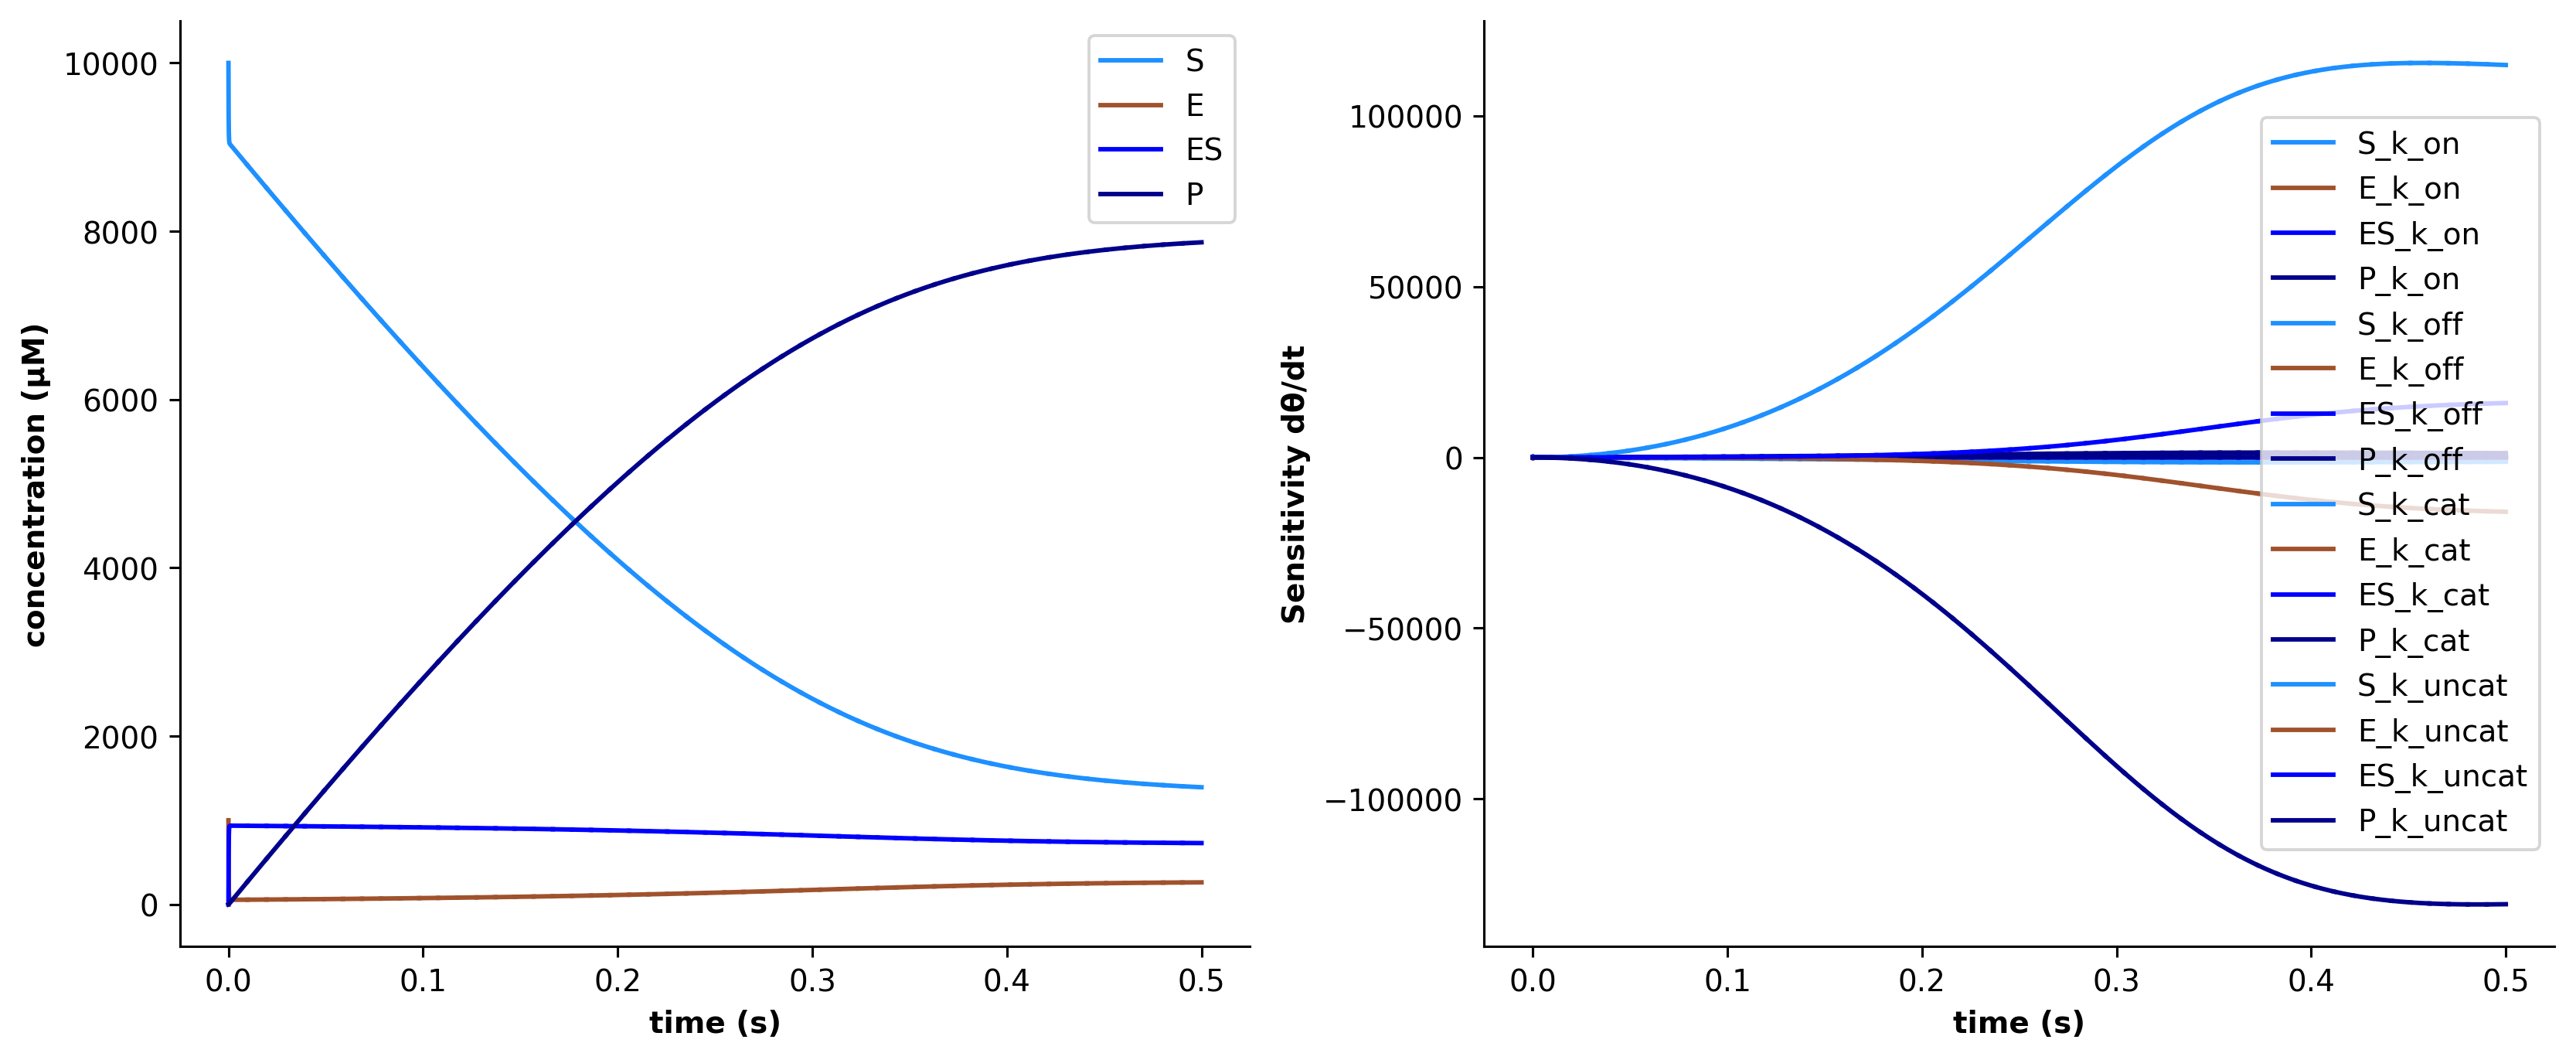

In [54]:
#collapse
# integrate system ODE and sensitivity ODE together, and plot the trajectories
start = time.process_time()
traj_euler_full_sensitivities = integrate_euler_full_sensitivities(default_kinetic_params)
euler_time = time.process_time() - start

ODE_columns = traj_euler_full_sensitivities.columns[:4]
sensitivity_columns = traj_euler_full_sensitivities.columns[4:]
P_sensitivity_columns = traj_euler_full_sensitivities.columns[7::4]

fig, axs = plt.subplots(1, 2)
traj_euler_full_sensitivities[ODE_columns].plot.line(ax=axs[0], color=color(ODE_columns))
traj_euler_full_sensitivities[sensitivity_columns].plot.line(ax=axs[1], color=color(sensitivity_columns.str.split('_').str[0]))

fig_style(axs[0])
fig_style(axs[1])
axs[1].set_ylabel('Sensitivity dθ/dt')
plt.tight_layout()

Unfortunately, as before, our simple-minded python code, although conceptually helpful, is too slow to use repeatedly inside a loop. Let's once again re-structure this code for scipy. 

In [55]:
#collapse
# define integrate_scipy_full_sensitivities (and helpers), which integrates the full kinetics and sensitivities with scipy
def dy_full_sensitivities(t, y, E_0, S_0, ES_0, P_0, k_on, k_off, k_cat, k_uncat, *args):
    # Y ordered S,E,ES,P
    dy = np.zeros(20)

    dy[0] = k_off * y[2] - k_on * y[1] * y[0]
    dy[1] = k_off * y[2] - k_on * y[1] * y[0] + k_cat * y[2] - k_uncat * y[1] * y[3]
    dy[2] = k_on * y[1] * y[0] - k_off * y[2] - k_cat * y[2] + k_uncat * y[1] * y[3]
    dy[3] = k_cat * y[2] - k_uncat * y[1] * y[3]

    f_u = f_u_Jacobian(*y[0:4], k_on, k_off, k_cat, k_uncat)

    dy[4:8] = np.dot(f_u, y[4:8]) + f_k_on(*y[0:4]).T
    dy[8:12] = np.dot(f_u, y[8:12]) + f_k_off(*y[0:4]).T
    dy[12:16] = np.dot(f_u, y[12:16]) + f_k_cat(*y[0:4]).T
    dy[16:20] = np.dot(f_u, y[16:20]) + f_k_uncat(*y[0:4]).T

    return dy


def integrate_scipy_full_sensitivities(kinetic_params, initial_conditions=default_initial_conditions, dt=dt, steps=steps, atol=1e-8):

    t_span = (0, dt*steps)
    t_eval = np.around(np.linspace(t_span[0],t_span[1],1001), decimals=5)
    y0 = list(initial_conditions.values()) + [0]*16

    try:
        sol = solve_ivp(dy_full_sensitivities, t_span, y0, args=(*initial_conditions.values(), *kinetic_params.values()), t_eval=t_eval, first_step=dt, method='LSODA', atol=atol)
        return pd.DataFrame(sol.y.T, index=sol.t, columns=cols)
    except:
        return pd.DataFrame(columns=cols)


Our naïve code takes 23.0s, whereas the optimized scipy code takes 0.2128s to generate the same trajectory.



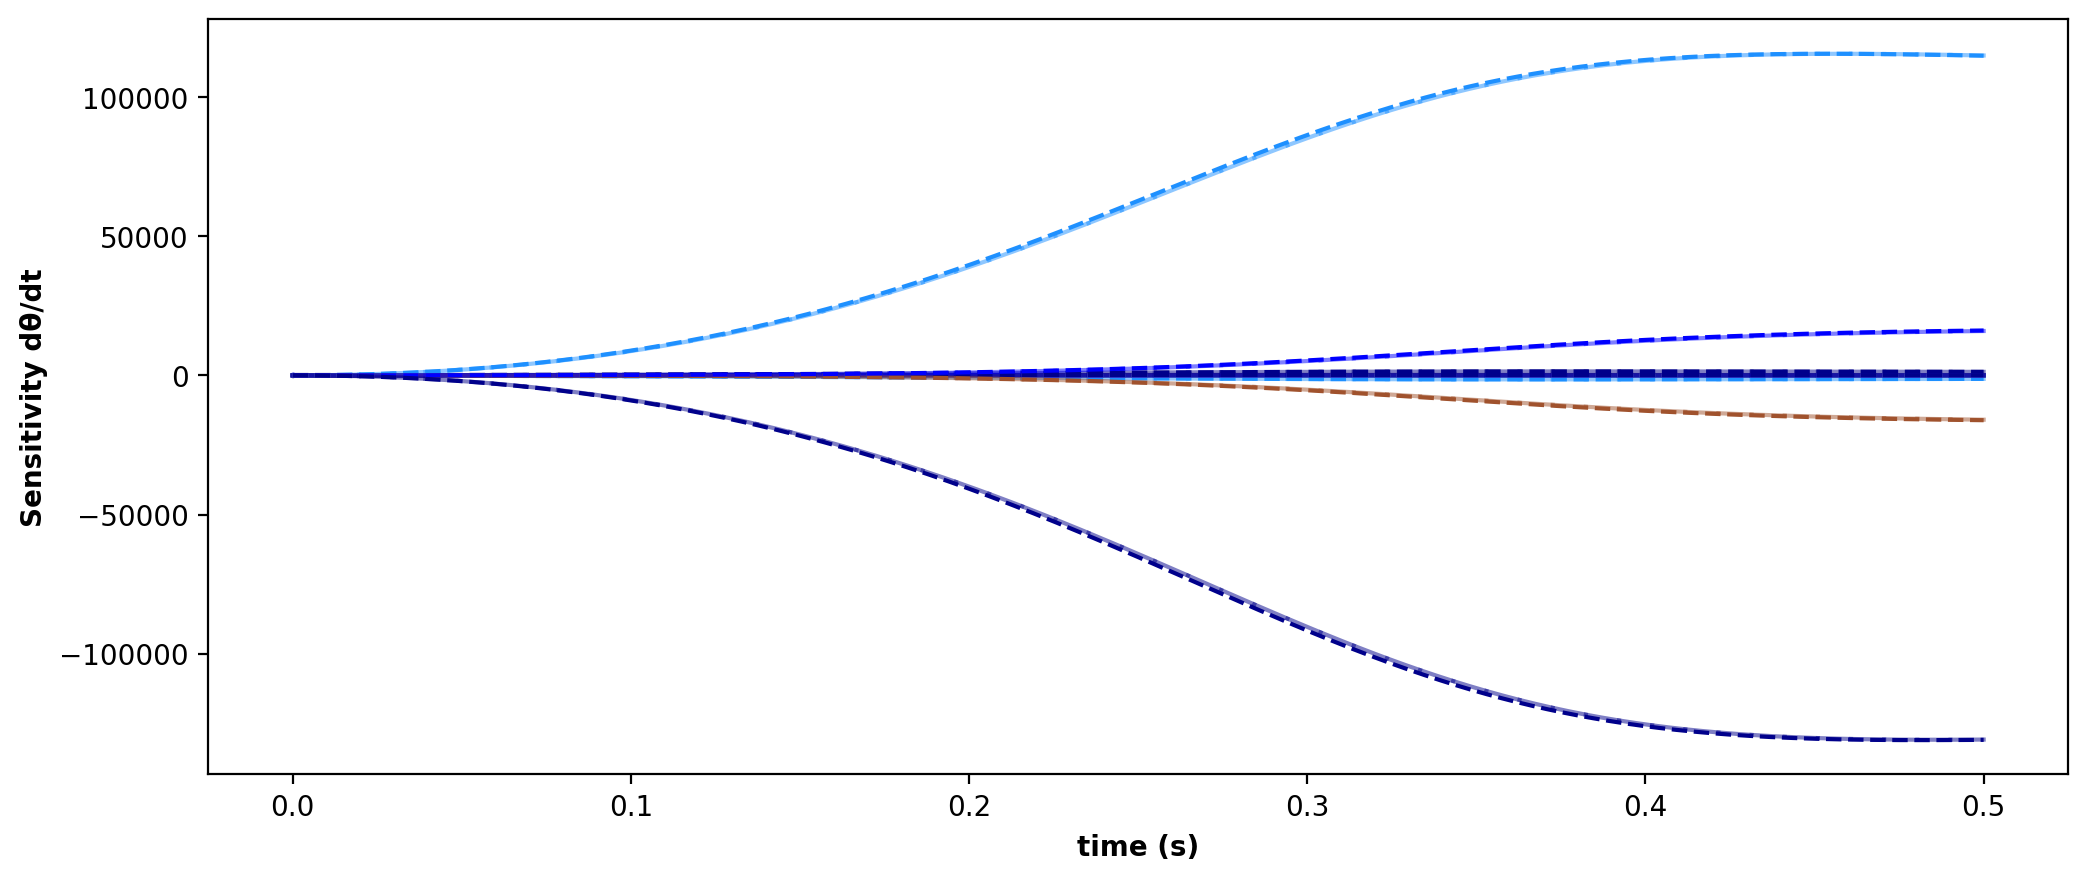

In [62]:
#collapse
# benchmark our naive code against scipy's integrator for the sensitivity equations
start = time.process_time()
traj_scipy_full_sensitivities = integrate_scipy_full_sensitivities(default_kinetic_params)
scipy_time = time.process_time() - start

ax = traj_euler_full_sensitivities[sensitivity_columns].plot.line(color=color(sensitivity_columns.str.split('_').str[0]), alpha=0.5, legend=False)
traj_scipy_full_sensitivities[sensitivity_columns].plot.line(ax=ax, color=color(sensitivity_columns.str.split('_').str[0]), linestyle='--', legend=False)
ax.set_ylabel('Sensitivity dθ/dt', weight='bold')
ax.set_xlabel('time (s)',  weight='bold')

print(f'Our naïve code takes {round(euler_time, 2)}s, whereas the optimized scipy code takes {round(scipy_time, 4)}s to generate the same trajectory.')

HTML(resize_fig(400, 400))

Recall, computing the sensitivity of the solution with respect to the parameters $\frac{du(t, \theta)}{d\theta}$ was in service of computing the gradient of our loss function with respect to the parameters: 

$$\frac{dG(u(t, \theta))}{d\theta} = 
\sum_{t \in \mathrm{obs}} \left[ 2\left(\frac{ \mathrm{obs}(t) - u(t, \theta)}{(\sigma \cdot \sqrt{\mathrm{obs}(t)})^2}\right) \cdot \frac{-du(t, \theta)}{d\theta} \right]$$

Now, since we set up this problem such that we only observe $\mathrm{obs}_{[\mathrm{P}]}(t)$, we are only able to compare the integrated kinetics of $ u_{[\mathrm{P}]}(t, \theta)$ and so our gradient expression becomes: 

$$\frac{dG(u(t, \theta))}{d\theta} = \sum_{t \in \mathrm{obs}} \left[ 2 \left( \frac{(\mathrm{obs}_{[\mathrm{P}]}(t) - u_{[\mathrm{P}]}(t, \theta))}{(\sigma \cdot \sqrt{\mathrm{obs}_{[\mathrm{P}]}(t))^2}} \right) \cdot \frac{ -d u_{[\mathrm{P}]}(t, \theta)}{d\theta} \right]$$



In [57]:
#collapse
# define gradient_of_loss() which returns the gradient of the loss with respect to each parameter
def gradient_of_loss_via_sensitivities(integrated_system_and_sensitivities):

    diff = 2*(observations - integrated_system_and_sensitivities.loc[observations.index, 'P']) / (σ * np.sqrt(observations))**2
    P_k = -integrated_system_and_sensitivities.loc[observations.index, P_sensitivity_columns]
    grad = P_k.multiply(diff, axis='rows').sum()
    grad.index = grad.index.str.lstrip('P_')

    return grad.to_dict()


We notice that $\frac{ d u_{[\mathrm{P}]}(t, \theta)}{dk_{\mathrm{uncat}}}$ reaches $O(10^6)$. This difference of the scales of the sensitivities may be because the parameters span many orders of magnitude, so the response of the system to small perturbations in some parameters may be much greater than others, especially integrated over time.  

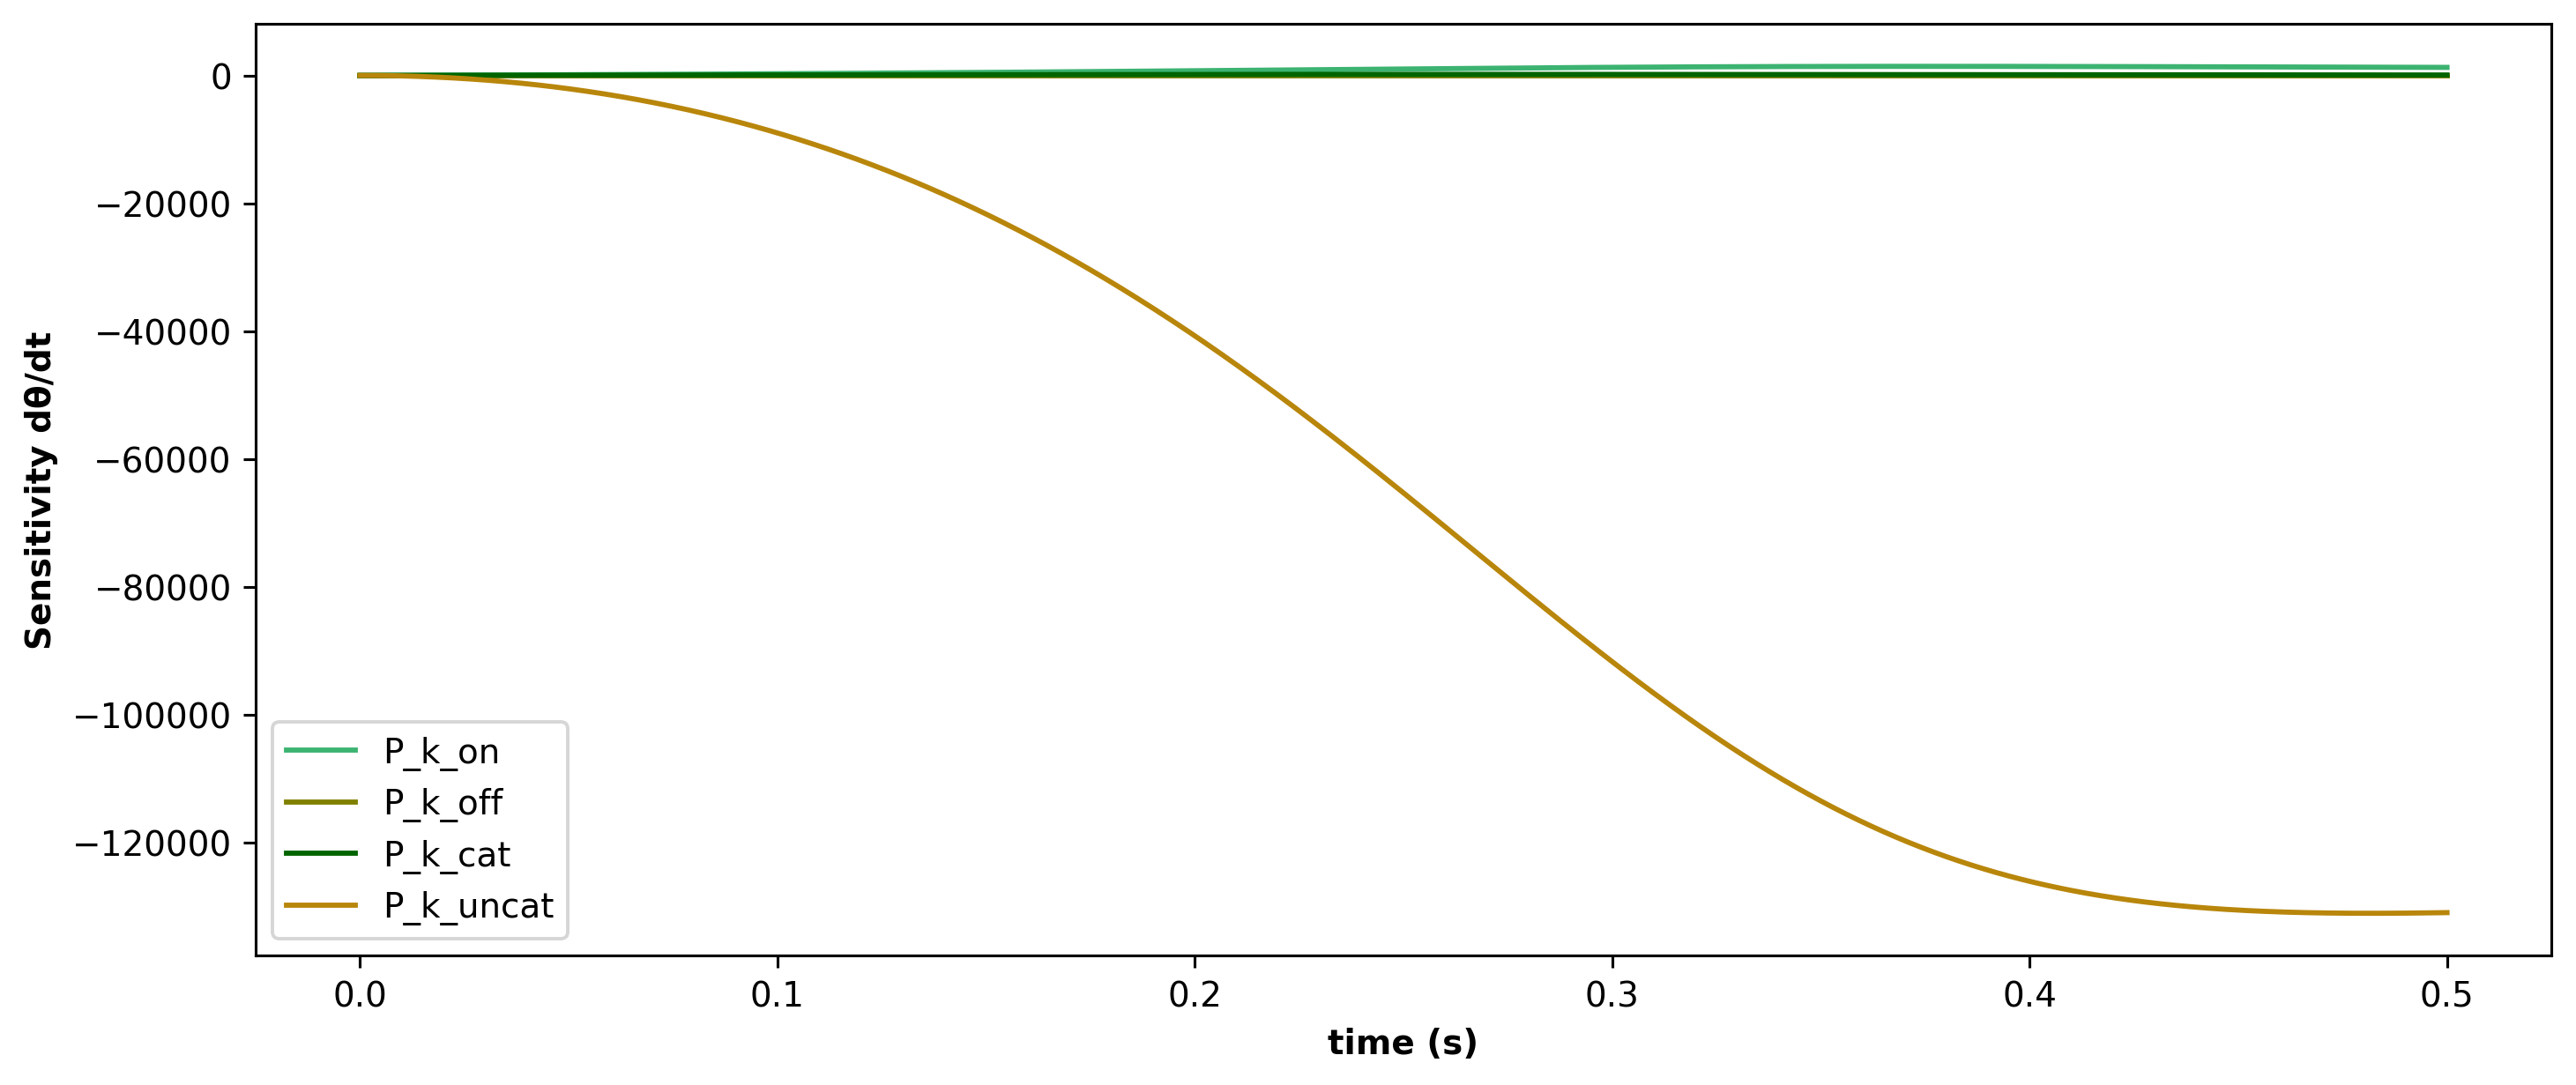

In [58]:
#collapse
# plot the subset of sensitivities which impinge on [P] -- notice the scale of dP/dk_uncat!
ax = traj_scipy_full_sensitivities[P_sensitivity_columns].plot.line(color=color(P_sensitivity_columns.str.split('_', 1).str[1]))
ax.set_xlabel('time (s)',  weight='bold')
ax.set_ylabel('Sensitivity dθ/dt', weight='bold')
None

We've set ourselves the task of optimizing the 4 parameters in the Michaelis-Menten/Briggs-Haldane kinetics ODE to minimize the squared error with respect to an observed timeseries. In order to intialize this optimization routine, we need somewhere to start from. Let's use the means of the prior distributions (from [§3.1.1](#3.1.1)) for each parameter as a starting point. 

In [59]:
θ_0 = {'k_on': exp(log_kon_normal.mean()),
       'k_off': exp(log_koff_normal.mean()),
       'k_cat': exp(log_kcat_normal.mean()),
       'k_uncat': exp(log_kuncat_normal.mean())}

θ_0['k_ms'] = k_ms(θ_0)
θ_0['k_mp'] = k_mp(θ_0)

Our gradient descent routine iterates a loop: 
1. Integrate the system ODE and sensitivity ODE with the current parameters.
2. Compute the gradient of the loss with the current parameters. 
3. Update the parameters with a gradient step

Our optimization routine will use one extra trick: a [momentum](https://distill.pub/2017/momentum/) term. This amounts to updating the gradient step expression from

$$ \theta_{t+1} = \theta_t - \eta \cdot \frac{dG(u(t, \theta))}{d\theta} \qquad \mathrm{to} \qquad \begin{aligned} 
v_{t+1} &= \gamma \cdot v_t + \frac{dG(u(t, \theta))}{d\theta} \\
\theta_{t+1} &= \theta_t - \eta \cdot v_t
\end{aligned}$$

This expression has two hyperparamters: $\eta$, the learning rate and $\gamma$, the momentum parameter. We'll set $\eta = 0.01$ at first and decrease it as we converge towards a minimum. We set $\gamma$ to the typical 0.9.  

In [60]:
#collapse
# define optimize_by_gradient_descent

Optimization_Record = namedtuple('Optimization_Record', ['θ', 'u', 'loss', 'G_θ'])

def optimize_by_gradient_descent(θ_0, integrate=integrate_scipy_full_sensitivities, gradient=gradient_of_loss_via_sensitivities):

    θ_t = dict(θ_0)
    v_t = {k: 0 for k in θ_0.keys()}

    u = integrate(θ_t)
    curr_loss = loss(u)

    η = 1e-2
    γ = 0.9

    θ_record = [θ_t]
    v_record = [v_t]
    u_record = [u]
    loss_record = [curr_loss]
    grad_record = []

    while η >= 1e-30:

        G_θ = gradient(u)
        v_t = {k: γ * v_t[k] + G_θ[k] for k in v_t.keys()}
        θ_t = {k: max(θ_t[k] - η * v_t[k], 0) for k in θ_t.keys()}

        next_u = integrate(θ_t)
        next_loss = loss(next_u)

        if next_loss < curr_loss:

            u = next_u
            curr_loss = next_loss

            v_record.append(v_t)
            θ_record.append(θ_t)
            u_record.append(u)
            loss_record.append(curr_loss)
            grad_record.append(G_θ)

            clear_output(wait=True)
            print(θ_0,
                  '\n\tLoss: ', np.round(curr_loss, 6), ' -> ', np.round(next_loss, 6),
                  '\n\t|Gradient|: ', np.linalg.norm(list(G_θ.values())),
                  '\n\t|v_t|: ', np.linalg.norm(list(v_t.values())),
                  '\"n\tη: ', η,
                  '\n\t', θ_t)

        else:
            η = η/np.sqrt(10)
            # print('\tη: ', η)
            v_t = {k: 0 for k in θ_0.keys()}
            θ_t = θ_record[-1]
            continue

    θ_record = pd.DataFrame(θ_record)
    loss_record = pd.Series(loss_record)
    grad_record = pd.DataFrame(grad_record)

    return Optimization_Record(θ=θ_record, u=u_record, loss=loss_record, G_θ=grad_record)


In [61]:
optimization_record = optimize_by_gradient_descent(θ_0)

KeyError: 'k_ms'

In [ ]:
#collapse
# plot result of optimization, starting from mean parameter values
def plot_optimization_trajectory(optimization_record):

    plt.rcParams['figure.figsize'] = [12, 4]
    fig, axs = plt.subplots(1, 2)
    plot_samples(pd.concat([df['P'] for df in optimization_record.u], axis=1).T, ax=axs[0])
    optimization_record.loss.plot.line(ax=axs[1], ylim=(0, optimization_record.loss.max()*1.1))

    final_loss = optimization_record.loss.iloc[-1]
    axs[1].text(0, final_loss+optimization_record.loss.max()/50, str(np.round(final_loss, 3)), c='red')
    axs[1].axhline(final_loss, c='r', linestyle='--', lw=0.5)
    axs[1].xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
    axs[1].set_xlabel('iteration',  weight='bold')
    axs[1].set_ylabel('Loss', weight='bold')
    for side in ["right","top"]: axs[1].spines[side].set_visible(False)


In [ ]:
plot_optimization_trajectory(optimization_record)

We said initially we didn't want to rely on prior knowledge of typical enzyme parameters in the sensitivity-based approach, but we've used them above to define our starting point for optimization, $\theta_0$. In many settings, we may not have a good estimate of where to begin from, and the conventional approach is to try multiple seeds. Let's try outlandishly wrong starting points, and see whether our gradient descent routine is able to find parameters which fit the data. 

In [ ]:
#collapse
# define procedure to sample outlandish points, and run batch optimization from each of those seeds
def prior_samples(n):
    prior_draws = []

    while len(prior_draws) < n:

        draw = sample_prior()
        if all([(np.linalg.norm(np.array(list(draw.values())) - np.array(list(prior_draw.values()))) > 1) for prior_draw in prior_draws]):
            prior_draws.append(draw)

    return prior_draws

def optimize_parametersets(parametersets):

    optimization_records = [optimize_by_gradient_descent(θ_0) for θ_0 in parametersets]

    os.system("printf '\a'")
    return optimization_records


optimization_runs_pickle_path = Path('../data/Enzyme_Kinetic_Parameter_Inference/optimization_runs.pickle')

def get_optimization_runs():

    if optimization_runs_pickle_path.is_file():

        with optimization_runs_pickle_path.open('rb') as f:
            optimization_records = pickle.load(f)
            # some sort of QC here?
            return optimization_records

    return None

def compute_optimization_runs():

    draws = prior_samples(10)
    optimization_records = optimize_parametersets([exp_params(draw) for draw in draws])

    with optimization_runs_pickle_path.open('wb') as f:
        pickle.dump(optimization_records, f)

    os.system("printf '\a'")
    return optimization_records

def get_or_compute_optimization_runs(): return get_optimization_runs() or compute_optimization_runs()


In [ ]:
optimization_records = get_or_compute_optimization_runs()

In [ ]:
#collapse
# Plot results of optimizations of 10 seeds: Loss trajectories and |gradient| trajectories
def plot_optimization_records_losses_and_magnitudes(optimization_records, until=2000):

    plt.rcParams['figure.figsize'] = [12, 4]
    fig, axs = plt.subplots(1, 2)

    optimization_records_losses = pd.DataFrame([optimization_record.loss for optimization_record in optimization_records]).T.rename_axis('iteration')
    optimization_records_losses.plot.line(ax=axs[0], xlim=(0, until), logy=True, title='Loss trajectories for 10 draws from the prior').set_ylabel('log(Loss)', fontdict={'weight':'bold'})

    optimization_records_gradient_magnitudes = pd.DataFrame([np.linalg.norm(r.G_θ, axis=1) for r in optimization_records]).T.rename_axis('iteration')
    optimization_records_gradient_magnitudes.plot.line(ax=axs[1], xlim=(0, until), logy=True, title='Gradient magnitudes for 10 draws from the prior').set_ylabel('log(|gradient|)', fontdict={'weight':'bold'})

plot_optimization_records_losses_and_magnitudes(optimization_records)

As we didn't add noise to our measurements, a loss of 0 is possible. However, none of our optimizations reach 0 loss. We would anticipate the magnitude of our gradients to approach 0 as well, as optimization proceeds successfully. Let's dig into these optimization runs a little further...

In [ ]:
#collapse
# define plot_optimization_trajectories()
def plot_optimization_trajectories(optimization_records):

    plt.rcParams['figure.figsize'] = [12, 4*len(optimization_records)]
    fig, axs = plt.subplots(len(optimization_records), 2)

    for i, record in enumerate(optimization_records):

        P_traj = pd.concat([df['P'] for df in record.u], axis=1)
        P_traj.columns = range(len(P_traj.columns))
        plot_samples(P_traj.T, ax=axs[i][0])
        axs[i][0].set_title(f'prior draw {i}', fontdict={'weight':'bold'}).set_c(matplotlib_colors[i])

        plot_chain(np.log(record.θ), ax=axs[i][1])


In [ ]:
#collapse
# plot the optimization trajectories
warnings.filterwarnings('ignore')
plot_optimization_trajectories(optimization_records)
plt.tight_layout()

Some of our optimizations succeed fit the data, whereas some fail to. Once again, even those that fit the data quite well (and therefore approach zero loss) do not recover the original parameters the trajectory was generated with. This result warrants a closer inspection of the loss surface. 

Visualizing $G(u(t, \theta))$, which is a $\R^4 \mapsto \R^1$ function, is tricky, but we can get a feel for it by examining orthogonal 2D slices. 

First, we need to evaluate the loss everywhere on a grid.

In [ ]:
#collapse
# define functions to evaluate the loss on each point on a grid
plt.rcParams['figure.figsize'] = [12, 5]
warnings.filterwarnings('once')

θ_opt = {key: val for key, val in default_kinetic_params.items() if key in ['k_on', 'k_off', 'k_cat', 'k_uncat']}

def parameter_loss(k_on,k_off,k_cat,k_uncat):
    return loss(integrate_scipy_full({'k_on':k_on,'k_off':k_off,'k_cat':k_cat,'k_uncat':k_uncat}))


loss_hypergrid_hdf5_path = Path('../data/Enzyme_Kinetic_Parameter_Inference/loss_hypergrid.hdf5')

def get_or_compute_global_loss_hypergrid():

    return get_loss_hypergrid('global_loss_hypergrid') or compute_global_loss_hypergrid()

def get_or_compute_optimization_neighborhood_loss_hypergrid(θ_records, θ_opt):

    return get_loss_hypergrid('optimization_neighborhood_loss_hypergrid') or compute_optimization_neighborhood_loss_hypergrid(θ_records, θ_opt)

def get_or_compute_optimum_neighborhood_loss_hypergrid(θ_opt):

    return get_loss_hypergrid('optimum_neighborhood_loss_hypergrid') or compute_point_neighborhood_loss_hypergrid(θ_opt)


def get_loss_hypergrid(dset_name):

    if loss_hypergrid_hdf5_path.is_file():
        with h5py.File(loss_hypergrid_hdf5_path, 'r') as h5f:
            dset = h5f.get(dset_name)
            loss_hypergrid = np.array(dset)

            if (loss_hypergrid.ndim and loss_hypergrid.size):  # check non-empty
                indices = dset.attrs.get('indexes')
                return indices, loss_hypergrid

    return None

def compute_loss_hypergrid(indices, name=None):

    loss_hypergrid = np.vectorize(parameter_loss)(*np.meshgrid(*indices, sparse=True))

    if name:
        with h5py.File(loss_hypergrid_hdf5_path, 'a') as h5f:
            if name in h5f:
                print(name + ' already exists in file, overwriting...')
                del h5f[name]
            dset = h5f.create_dataset(name, data=loss_hypergrid)
            dset.attrs['index_names'] = ['k_on','k_off','k_cat','k_uncat']
            dset.attrs['indexes'] = indices

    os.system("printf '\a'")
    return loss_hypergrid

def compute_global_loss_hypergrid(grid_size=11):

    x = np.logspace(-4, 6, grid_size)
    indices = [x, x, x, x]
    return indices, compute_loss_hypergrid('global_loss_hypergrid', indices)


def compute_optimization_neighborhood_loss_hypergrid(θ_records, θ_opt, grid_size=15, name='optimization_neighborhood_loss_hypergrid'):

    Min = [min([θ_record[k].min() for θ_record in θ_records] + [θ_opt[k]]) for k in θ_opt.keys()]
    Max = [max([θ_record[k].max() for θ_record in θ_records] + [θ_opt[k]]) for k in θ_opt.keys()]

    indices = [np.linspace(lower*0.9, upper*1.1, grid_size) for lower, upper in zip(Min, Max)]

    return indices, compute_loss_hypergrid(indices, name=name)


def compute_point_neighborhood_loss_hypergrid(θ, grid_size=15):

    indices = [np.linspace(p-p*0.8, p+p*0.8, grid_size) for p in θ.values()]

    return indices, compute_loss_hypergrid(indices)



In [ ]:
global_indices, global_loss_hypergrid = get_or_compute_global_loss_hypergrid()
global_loss_hypergrid.shape

In [ ]:
optimum_neighborhood_indices, optimum_neighborhood_loss_hypergrid = get_or_compute_optimum_neighborhood_loss_hypergrid(θ_opt)
optimum_neighborhood_loss_hypergrid.shape

In [ ]:
#collapse
# Define interactive loss landscape visualization

def explore_loss_landscape(k_on, k_off, k_cat, k_uncat, scales, loss_hypergrid, θ_records, θ_opt, cmin=0, cmax=3000):

    params = θ_opt.keys()
    n = len(params)
    fig = make_subplots(rows=n-1, cols=n-1, shared_xaxes=True, shared_yaxes=True)

    for i, param1 in enumerate(params):
        for j, param2 in enumerate(params):
            if i > j:

                z = np.squeeze(loss_hypergrid[None if 'k_on' in [param1, param2] else k_on,
                                              None if 'k_off' in [param1, param2] else k_off,
                                              None if 'k_cat' in [param1, param2] else k_cat,
                                              None if 'k_uncat' in [param1, param2] else k_uncat]).T


                # Contour
                fig.add_trace(
                    go.Contour(z=z, x=scales[j], y=scales[i], coloraxis="coloraxis", contours_coloring='heatmap'),
                    row=i, col=j+1
                )
                # Optimum star
                if len(θ_opt.keys()):
                    fig.add_trace(
                        go.Scatter(x=[θ_opt[param2]], y=[θ_opt[param1]], mode='markers', marker=dict(symbol='star-dot', color='limegreen', line_color='black', line_width=0.2, size=12), showlegend=False, name="optimum"),
                        row=i, col=j+1
                    )
                # Optimization trajectory lines
                if len(θ_records):
                    for n, (θ_record, c) in enumerate(zip(θ_records, matplotlib_colors+['red']*4)):
                        fig.add_trace(
                            go.Scatter(x=θ_record[param2], y=θ_record[param1], mode='lines', line=dict(color=c), showlegend=False, name=f"draw {n}"),
                            row=i, col=j+1
                        )
                        fig.add_trace(
                            go.Scatter(x=[θ_record[param2].iloc[-1]], y=[θ_record[param1].iloc[-1]], mode='markers', marker=dict(symbol='diamond', color=c, size=5), showlegend=False),
                            row=i, col=j+1
                        )

                if i == len(params)-1:
                    fig.update_xaxes(title_text=param2, row=3, col=j+1)

                if j == 0:
                    fig.update_yaxes(title_text=param1, row=i, col=1)

    fig.update_layout(height=1000, width=1000, coloraxis=dict(colorscale='magma', reversescale=True, cmin=cmin, cmax=cmax))
    fig.show()


def explore_global_loss_hypergrid(k_on, k_off, k_cat, k_uncat, scales, loss_hypergrid, log_θ_records, θ_opt):
    '''Note, this function expects `scales`, `θ_record`, and `θ_opt` to have been log'd (base 10)'''

    k_on = int(np.log10(k_on)+4)
    k_off = int(np.log10(k_off)+4)
    k_cat = int(np.log10(k_cat)+4)
    k_uncat = int(np.log10(k_uncat)+4);

    explore_loss_landscape(k_on, k_off, k_cat, k_uncat, scales, loss_hypergrid, log_θ_records, θ_opt)


def explore_neighborhood_loss_hypergrid(k_on, k_off, k_cat, k_uncat, scales, loss_hypergrid, θ_records, θ_opt):

    k_on = np.where(scales[0] == k_on)[0][0]
    k_off = np.where(scales[1] == k_off)[0][0]
    k_cat = np.where(scales[2] == k_cat)[0][0]
    k_uncat = np.where(scales[3] == k_uncat)[0][0]

    explore_loss_landscape(k_on, k_off, k_cat, k_uncat, scales, loss_hypergrid, θ_records, θ_opt)


We'll first explore the loss function on a grid in $\log_{10}$ space. This will give us a feel for the global shape of the loss surface, so long as we're mindful of the $\log_{10}$-distortion. We can also project the optimization trajectories onto each 2D slice (as well as the global optimum), while remembering that the trajectories are 4D, so their projections may not look appear to be optimizing the loss in each 2D slice. We can also take the liberty of adding the MCMC trajectories as a comparison.

In [ ]:
#collapse
# global view of optimization landscape
sliders = [SelectionSlider(options=index, description=name, value=index[len(index)//2]) for name, index in zip(['k_on','k_off','k_cat','k_uncat'], global_indices)]

interact(explore_global_loss_hypergrid,
         k_on=sliders[0],
         k_off=sliders[1],
         k_cat=sliders[2],
         k_uncat=sliders[3],
         scales=fixed(np.log10(global_indices)),
         loss_hypergrid=fixed(global_loss_hypergrid),
         log_θ_records=fixed([np.log10(r.θ+1e-4) for r in optimization_records] + [np.log10(np.exp(c)) for c in (chain, chain_1, chain_2, chain_3)]),
         θ_opt=fixed({k: np.log10(v) for k,v in θ_opt.items()}))

# fig.result.update_xaxes(range=[-4, 6], dtick=2)
# fig.result.update_yaxes(range=[-4, 6], dtick=2)
None

The contour plots above seem to suggest local optima, but those are artifacts of plotly's contour function. 

To understand why our optimizations are failing to reach the optimum, we can also explore the loss around the optimum, or around the termination points of each optimization. The neighborhood of the optimum looks like this: 

In [ ]:
#collapse
# local view of optimization landscape
sliders = [SelectionSlider(options=index, description=name, value=index[len(index)//2]) for name, index in zip(['k_on','k_off','k_cat','k_uncat'], optimum_neighborhood_indices)]

interact(explore_neighborhood_loss_hypergrid,
         k_on=sliders[0],
         k_off=sliders[1],
         k_cat=sliders[2],
         k_uncat=sliders[3],
         scales=fixed(optimum_neighborhood_indices),
         loss_hypergrid=fixed(optimum_neighborhood_loss_hypergrid),
         θ_records=fixed([]),
         θ_opt=fixed(θ_opt))
None

The optimum falls in a valley, which, once attained, likely has a very small gradient. This may correspond to the valley we saw in the $\log_{10}$-scaled global loss landscape survey above. Small gradients can be difficult to compute accurately with finite numerical precision, and our simple optimizer will stop once tiny steps in the direction of the gradient do not decrease the loss. 

Our parameters span many orders of magnitude. In our MCMC approach to this problem, we dealt with our kinetic parameters in log space. Let's take a quick detour and try gradient-based optimization for the log-parameters. 

#### 3.2.2. Forward Sensitivities in Log Space

Many of the expressions derived in the previous section remain the same when we optimize the loss $G$ with respect to the log-parameters. The Jacobian $\frac{\partial f}{\partial u} \Big|_{u(t, \theta), \theta}$ remains the same, however, the $\frac{\partial f}{\partial \theta} \Big|_{u(t, \theta), \theta}$ terms are replaced by $\frac{\partial f}{\partial \log(\theta)} \Big|_{u(t, \theta), \theta}$ terms:

$$\frac{\partial f}{\partial \log(k_{\mathrm{on}})} = 
\begin{bmatrix} -k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] \\ -k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] \\ k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] \\ 0 \end{bmatrix}, \qquad
\frac{\partial f}{\partial \log(k_{\mathrm{off}})} = 
\begin{bmatrix} k_{\mathrm{off}}[\mathrm{ES}] \\ k_{\mathrm{off}}[\mathrm{ES}] \\ -k_{\mathrm{off}}[\mathrm{ES}] \\ 0 \end{bmatrix}, \qquad
\frac{\partial f}{\partial \log(k_{\mathrm{cat}})} = 
\begin{bmatrix} 0 \\ k_{\mathrm{cat}}[\mathrm{ES}] \\ -k_{\mathrm{cat}}[\mathrm{ES}] \\ k_{\mathrm{cat}}[\mathrm{ES}] \end{bmatrix}, \qquad
\frac{\partial f}{\partial \log(k_{\mathrm{uncat}})} = 
\begin{bmatrix} 0 \\ -k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\ k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\ -k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \end{bmatrix}, \qquad
$$


In [ ]:
#collapse
# define helper functions for euler_full_sensitivities()
def f_log_k_on(S, E, ES, P, k_on): return np.array([[-k_on*E*S, -k_on*E*S, k_on*E*S, 0]]).T
def f_log_k_off(S, E, ES, P, k_off): return np.array([[k_off*ES, k_off*ES, -k_off*ES, 0]]).T
def f_log_k_cat(S, E, ES, P, k_cat): return np.array([[0, k_cat*ES, -k_cat*ES, k_cat*ES]]).T
def f_log_k_uncat(S, E, ES, P, k_uncat): return np.array([[0, -k_uncat*E*P, k_uncat*E*P, -k_uncat*E*P]]).T

We'll skip straight to the scipy implementation.

In [ ]:
#collapse
# define scipy_log_sensitivities (and helpers), which integrates the full kinetics and sensitivities with respect to the log'd parameters with scipy
def dy_log_sensitivities(t, y, E_0, S_0, ES_0, P_0, k_on, k_off, k_cat, k_uncat, *args):
    # Y ordered S,E,ES,P
    dy = np.zeros(20)

    dy[0] = k_off * y[2] - k_on * y[1] * y[0]
    dy[1] = k_off * y[2] - k_on * y[1] * y[0] + k_cat * y[2] - k_uncat * y[1] * y[3]
    dy[2] = k_on * y[1] * y[0] - k_off * y[2] - k_cat * y[2] + k_uncat * y[1] * y[3]
    dy[3] = k_cat * y[2] - k_uncat * y[1] * y[3]

    f_u = f_u_Jacobian(*y[0:4], k_on, k_off, k_cat, k_uncat)

    dy[4:8] = np.dot(f_u, y[4:8]) * k_on + f_log_k_on(*y[0:4], k_on).T
    dy[8:12] = np.dot(f_u, y[8:12]) * k_off + f_log_k_off(*y[0:4], k_off).T
    dy[12:16] = np.dot(f_u, y[12:16]) * k_cat + f_log_k_cat(*y[0:4], k_cat).T
    dy[16:20] = np.dot(f_u, y[16:20]) * k_uncat + f_log_k_uncat(*y[0:4], k_uncat).T

    return dy


def integrate_scipy_log_sensitivities(kinetic_params, initial_conditions=default_initial_conditions, dt=dt, steps=steps):
    '''Note this function assumes the kinetic params are not in log space -- exp() them beforehand'''
    t_span = (0, dt*steps)
    t_eval = np.around(np.linspace(t_span[0],t_span[1],1001), decimals=5)
    y0 = list(initial_conditions.values()) + [0]*16

    try:
        sol = solve_ivp(dy_log_sensitivities, t_span, y0, args=(*initial_conditions.values(), *kinetic_params.values()), t_eval=t_eval, first_step=dt, method='LSODA')
        return pd.DataFrame(sol.y.T, index=sol.t, columns=cols)
    except:
        return pd.DataFrame(columns=cols)


In [ ]:
#collapse
traj_scipy_log_sensitivities = integrate_scipy_log_sensitivities(default_kinetic_params)

fig, axs = plt.subplots(1, 2)
traj_scipy_log_sensitivities[ODE_columns].plot.line(ax=axs[0], color=color(ODE_columns))
traj_scipy_log_sensitivities[sensitivity_columns].plot.line(ax=axs[1], color=color(sensitivity_columns.str.split('_').str[0]))

fig_style(axs[0])
fig_style(axs[1])
axs[1].set_ylabel('Sensitivity dθ/dt')
plt.tight_layout()

Our optimization procedure changes subtly to incorporate the alternate sensitivity computation:

We'll once more start from the mean of the prior,

In [ ]:
log_θ_0 = {'k_on': log_kon_normal.mean(),
           'k_off': log_koff_normal.mean(),
           'k_cat': log_kcat_normal.mean(),
           'k_uncat': log_kuncat_normal.mean()}

In [ ]:
optimization_record = optimize_by_gradient_descent(log_θ_0, integrate=integrate_scipy_log_sensitivities(exp_params(log_θ_t)))

In [ ]:
plot_optimization_trajectory(optimization_record)

We find the optimum much faster, which seems promising. Let's once more start from many initial points. 

In [ ]:
#collapse
# Define functions to run multiple log-parameter optimizations

log_optimization_runs_pickle_path = Path('../data/Enzyme_Kinetic_Parameter_Inference/log_optimization_runs.pickle')

def optimize_log_parametersets(log_parametersets):

    optimization_records = [optimize_by_gradient_descent(log_θ_0, integrate=integrate_scipy_log_sensitivities(exp_params(log_θ_t))) for log_θ_0 in log_parametersets]

    os.system("printf '\a'")
    return optimization_records

def get_log_optimization_runs():

    if log_optimization_runs_pickle_path.is_file():

        with log_optimization_runs_pickle_path.open('rb') as f:
            log_optimization_records = pickle.load(f)
            # some sort of QC here?
            return log_optimization_records

    return None

def compute_log_optimization_runs():

    draws = prior_samples(10)
    optimization_records = [record for record in optimize_log_parametersets(draws) if record]

    with log_optimization_runs_pickle_path.open('wb') as f:
        pickle.dump(optimization_records, f)

    os.system("printf '\a'")
    return optimization_records

def get_or_compute_log_optimization_runs(): return get_log_optimization_runs() or compute_log_optimization_runs()


In [ ]:
log_optimization_records = compute_log_optimization_runs()

In [ ]:
plot_optimization_records_losses_and_magnitudes(log_optimization_records, until=20)

In [ ]:
#collapse
# plot the optimization trajectories
warnings.filterwarnings('ignore')
plot_optimization_trajectories(log_optimization_records)
plt.tight_layout()

This optimization takes fewer steps, but still frequently fails to find the minimum, despite the option of very small step sizes. 

#### 3.2.3. Adjoint Method


There exists another way to evalate the gradient of the loss with respect to the parameters. Our intention is not to improve the accuracy of the gradients, but instead the asymptotic computational complexity of evaluating the gradient, and thus decrease the runtime for optimizing the parameters of systems with many parameters. 

Our enzyme kinetics system has 4 parameters, which is not many, so we will not experience a notable speedup in our optimizations, but including the approach is perhaps easier to illustrate granularly for a small system. 

In the Forward Sensitivities approach, a system of Ordinary Differential Equations in 4 variables with 4 parameters had us integrating 16 sensitivity variables: $\frac{\partial [\mathrm{X}_i]}{\partial \theta_j}$ for each combination of $[\mathrm{X}_i]$ and $\theta_j$. The number of sensitivity ODE expressions scales as $O(|\mathrm{X}| \cdot |\theta|)$. The Adjoint Method for ODEs will permit us to reduce that to $O(|\mathrm{X}| + |\theta|)$. Let's walk through the derivation. Fair warning: it's lengthy (at least by my standards). 

<div style='max-width: none !important; background-color: #F5F5F5'>
    
<b>Derivation:</b><br/>
    
$
\begin{aligned}
\text{We had written our loss as} \\
%
G(u(t, \theta)) & = \sum_{t \in \mathrm{obs}} \left(\frac{ \mathrm{obs}(t) - u(t, \theta)}{\sigma \cdot \sqrt{\mathrm{obs}(t)}}\right)^2 \\
%
\text{Re-write it as an integral over continuous time} \\ \text{of either a piecewise function or a function with dirac deltas} \\
%
& = \sum_{t \in \mathrm{obs}} \left(\frac{ \mathrm{obs}(t) - u(t, \theta)}{\sigma \cdot \sqrt{\mathrm{obs}(t)}}\right)^2 \\
%
& =\int_{t_{0}}^{T}g(u(t,\theta))dt \\
%
& = \begin{cases} 
      0 & t\notin \mathrm{observations} \\
       \left(\frac{ \mathrm{obs}(t) - u(t, \theta)}{\sigma \cdot \sqrt{\mathrm{obs}(t)}}\right)^2 & t\in \mathrm{observations} \\
   \end{cases} \\
%
& = \int_{t_0}^T \\
%
\text{Begin with the loss, which we can unpack} \\ \text{as the integral of the instantaneous loss} \\
%

%
\text{We want to specify the constraint that} \\ \frac{du}{dt} = f(u(t,\theta),\theta,t) \text{ throughout the domain} \\ \text{which we can do via lagrange multipliers.} \\ \text{Introduce the auxiliary vector variable } \lambda \\
%
 & =\int_{t_{0}}^{T}g(u(t,\theta))dt+\int_{t_{0}}^{T}\lambda^{\intercal}(t)\left(\frac{du}{dt}-f(u,\theta,t) \right) dt\\
%
\text{Now, take } \frac{\partial}{\partial \theta_i} \text{ to evaluate one entry} \\ \text{of the gradient. Apply the chain rule} \\ \text{to find the derivative of the RHS.} \\
%
\frac{\partial}{\partial\theta_i}G(u(p)) & =\int_{t_{0}}^{T}\left(\frac{\partial g}{\partial \theta_i}+\frac{\partial g}{\partial u}\frac{\partial u}{\partial \theta_i}\right)dt+\int_{t_{0}}^{T}\lambda^{\intercal}(t)\left(\frac{d}{d\theta_i}\frac{\partial u}{\partial t}-\left(\frac{\partial f}{\partial u}\frac{\partial u}{\partial \theta_i}+\frac{\partial f}{\partial \theta_i}\right)\right)dt\\
%
\text{extract the last integral from that expression,} \\ \text{and split it into two.} \\ 
%
\int_{t_{0}}^{T}\lambda^{\intercal}(t)\left(\frac{d}{d\theta_i}\frac{\partial u}{\partial t}-\left(\frac{\partial f}{\partial u}\frac{\partial u}{\partial \theta_i}+\frac{\partial f}{\partial \theta_i}\right)\right)dt & =\int_{t_{0}}^{T}\lambda^{\intercal}(t)\left(\frac{d}{d\theta_i}\frac{\partial u}{\partial t}\right)dt-\int_{t_{0}}^{T}\lambda^{\intercal}(t)\left(\frac{\partial f}{\partial u}\frac{\partial u}{\partial \theta_i}+\frac{\partial f}{\partial \theta_i}\right)dt\\
%
\text{For the first of those two expressions,} \\ \text{apply integration by parts} \\ 
%
\int_{t_{0}}^{T}\lambda^{\intercal}(t)\left(\frac{d}{d\theta_i}\frac{\partial u}{\partial t}\right)dt & =\big[\lambda^{\intercal}(t)\frac{\partial u}{\partial \theta_i}\big]_{t_{0}}^{T}-\int_{t_{0}}^{T}\left(\frac{d\lambda^{\intercal}(t)}{dt}\frac{\partial u}{\partial \theta_i}\right)dt\\
%
\text{Now form the resultant expression} \\
%
\frac{d}{d\theta_i}G(u(p)) & =\int_{t_{0}}^{T}\left(\frac{\partial g}{\partial \theta_i}+\frac{\partial g}{\partial u}\frac{\partial u}{\partial \theta_i}\right)dt+\left[\big[\lambda^{\intercal}(t)\frac{\partial u}{\partial \theta_i}\big]_{t_{0}}^{T}-\int_{t_{0}}^{T}\left(\frac{d\lambda^{\intercal}(t)}{dt}\frac{\partial u}{\partial \theta_i}\right)dt-\int_{t_{0}}^{T}\lambda^{\intercal}(t)\left(\frac{\partial f}{\partial u}\frac{\partial u}{\partial \theta_i}+\frac{\partial f}{\partial \theta_i}\right)dt\right]\\
%
\text{Rearrange} \\
%
 & =\big[\lambda^{\intercal}(t)\frac{\partial u}{\partial \theta_i}\big]_{t_{0}}^{T}+\int_{t_{0}}^{T}\left(\frac{\partial g}{\partial \theta_i}+\frac{\partial g}{\partial u}\frac{\partial u}{\partial \theta_i}-\frac{d\lambda^{\intercal}(t)}{dt}\frac{\partial u}{\partial \theta_i}-\lambda^{\intercal}(t)\left(\frac{\partial f}{\partial u}\frac{\partial u}{\partial \theta_i}+\frac{\partial f}{\partial \theta_i}\right)\right)dt\\
%
\text{Now here's the magic step. If we require:} \\
%
\frac{d\lambda^{\intercal}(t)}{dt} & =-\frac{\partial f}{\partial u}\lambda^{\intercal}(t)+\frac{\partial g}{\partial u}^{\intercal}\\
%
\lambda(T) & =0\\
%
\text{Then our expression simplifies} \\
%
\frac{d}{d\theta_i}G(u(\theta, t)) & =-\big[\lambda^{\intercal}(t)\frac{\partial u}{\partial \theta_i}\big]_{t_{0}}^{T}+\int_{t_{0}}^{T}\left(\frac{\partial g}{\partial \theta_i}+\frac{\partial g}{\partial u}\frac{\partial u}{\partial \theta_i}-\left(-\frac{\partial f}{\partial u}\lambda(t)+\frac{\partial g}{\partial u}^{\intercal}\right)\frac{\partial u}{\partial \theta_i}-\lambda^{\intercal}(t)\left(\frac{\partial f}{\partial u}\frac{\partial u}{\partial \theta_i}+\frac{\partial f}{\partial \theta_i}\right)\right)dt\\
%
 & =-\big[0\cdot\frac{\partial u}{\partial \theta_i}\Big|_T-\lambda^{\intercal}(t_{0})\cdot\frac{\partial u}{\partial \theta_i}\Big|_{t_0}\big]+\int_{t_{0}}^{T}\left(\frac{\partial g}{\partial \theta_i}+\frac{\partial g}{\partial u}\frac{\partial u}{\partial \theta_i}+\frac{\partial f}{\partial u}\frac{\partial u}{\partial \theta_i}\lambda^{\intercal}(t)-\frac{\partial g}{\partial u}\frac{\partial u}{\partial \theta_i}-\lambda^{\intercal}(t)\frac{\partial f}{\partial u}\frac{\partial u}{\partial \theta_i}-\lambda^{\intercal}(t)\frac{\partial f}{\partial \theta_i}\right)dt\\
%
 & =\int_{t_{0}}^{T}\left(\frac{\partial g}{\partial \theta_i}-\lambda^{\intercal}(t)\frac{\partial f}{\partial \theta_i}\right)dt\\
%
\end{aligned}
$
</div>

Our expression for the gradient is an integral containing three terms. $\frac{\partial g}{\partial \theta_i}$, $\lambda^{\intercal}(t)$, and $\frac{\partial f}{\partial \theta_i}$. 
- Our loss function $G(u(t, \theta)) =  \sum_t (\frac{ \mathrm{obs}(t) - u(t, \theta)}{\sigma \cdot \sqrt{\mathrm{obs}(t)}})^2$ contains no explicit $\theta$ term (as it might if our loss included a regularization term) so $\frac{\partial g}{\partial \theta_i} = 0$.
- $\frac{\partial f}{\partial \theta_i}$ appeared in our forward sensitivity ODEs. It hasn't changed. 
- That leaves us with $\lambda^{\intercal}(t)$, which we need to compute. In order to cancel terms in our derivation, we had established
$$\begin{aligned}\frac{d\lambda^{\intercal}(t)}{dt} & =-\frac{\partial f}{\partial u}\lambda^{\intercal}(t)+\frac{\partial g}{\partial u}^{\intercal}\\
%
\lambda(T) & =0\end{aligned}$$
This is an ODE we can integrate, however, since the boundary condition (the "initial value") occurs at the _last_ timepoint, we need to integrate this differential expression backwards in time. 
$$-\frac{d\lambda^{\intercal}(t)}{dt} =\frac{\partial f}{\partial u}\lambda^{\intercal}(t)-\frac{\partial g}{\partial u}^{\intercal}$$
This differential equation includes yet more terms: $\frac{\partial f}{\partial u}$ and $\frac{\partial g}{\partial u}^{\intercal}$.
- $\frac{\partial f}{\partial u}$ is the Jacobian, as in our forward sensitivity ODEs. Resolving the entries of this matrix requires we have $u(t, \theta)$. Thus in order to integrate the adjoint ODE we will need to have already integrated the system ODE.
- Finally, $\frac{\partial g}{\partial u}^{\intercal}$ is the derivative of the instantaneous loss with respect to the state. As we have discretely-many observations, our loss function is somewhat discontinuous: 
$$G(u(t, \theta)) = \begin{cases} 
      0 & t\notin \mathrm{observations} \\
      \|\mathrm{obs}_{[\mathrm{P}]}(t) - u_{[\mathrm{P}]}(t)\| & t\in \mathrm{observations} \\
   \end{cases}$$

The Adjoint Method for ODEs is thus:
1. Solve the system ODE $\frac{du}{dt} = f(u(\theta, t), \theta)$, providing $u(t, \theta)$.
2. Solve the adjoint state ODE $-\frac{d\lambda^{\intercal}(t)}{dt} =\frac{\partial f}{\partial u}\lambda^{\intercal}(t)-\frac{\partial g}{\partial u}^{\intercal}$ in reverse from $\lambda(T) = 0$ to $t_0$. 
3. Evaluate the integral $\frac{dG(u(t, \theta))}{d\theta_i} = \int_{t_{0}}^{T}\left(\frac{\partial g}{\partial \theta_i}-\lambda^{\intercal}(t)\frac{\partial f}{\partial \theta_i}\right)dt$

Inspecting this procedure, we may notice that the integral in step 3 can be computed concurrently with step 2.

Let's implement it. 

In [63]:
#collapse
# define gradient_via_euler_adjoint_method, integrate_euler_adjoint()
def gradient_of_loss_via_euler_adjoint_method(θ_t):

    u_t = integrate_euler_full(θ_t)

    λ_t, grad_t = integrate_euler_adjoint(u_t, θ_t)

    return grad_t.iloc[0], grad_t, λ_t, u_t


def integrate_euler_adjoint(u, θ_t, dt=dt, steps=steps):

    k_on, k_off, k_cat, k_uncat, k_ms, k_mp = θ_t.values()

    λ = np.zeros((1, 4))
    λ_traj = []
    grad = np.zeros((4, 1))
    grad_traj = []

    for t, (S, E, ES, P) in u[::-1].iterrows():

        λ_traj.append(λ[0].copy())
        grad_traj.append(grad.T[0].copy())

        f_u = f_u_Jacobian(S, E, ES, P, k_on, k_off, k_cat, k_uncat)

        dλ = λ @ f_u

        if t in observations.index:
            g_u_P = 2*(observations.loc[t] - u.loc[t, 'P'])
            dλ = dλ - np.array([[0, 0, 0, g_u_P]])

        λ += dλ * dt

        grad += np.array([np.dot(λ, f_θ(S, E, ES, P))[0] for f_θ in [f_k_on, f_k_off, f_k_cat, f_k_uncat]]) * dt


    return (pd.DataFrame(reversed(λ_traj), columns=['k_on', 'k_off', 'k_cat', 'k_uncat'], index=u.index),
            pd.DataFrame(reversed(grad_traj), columns=['k_on', 'k_off', 'k_cat', 'k_uncat'], index=u.index))


In [502]:
start = time.process_time()
grad_0, grad_0_traj, λ_0, u_0 = gradient_of_loss_via_euler_adjoint_method(θ_0)
euler_time = time.process_time() - start

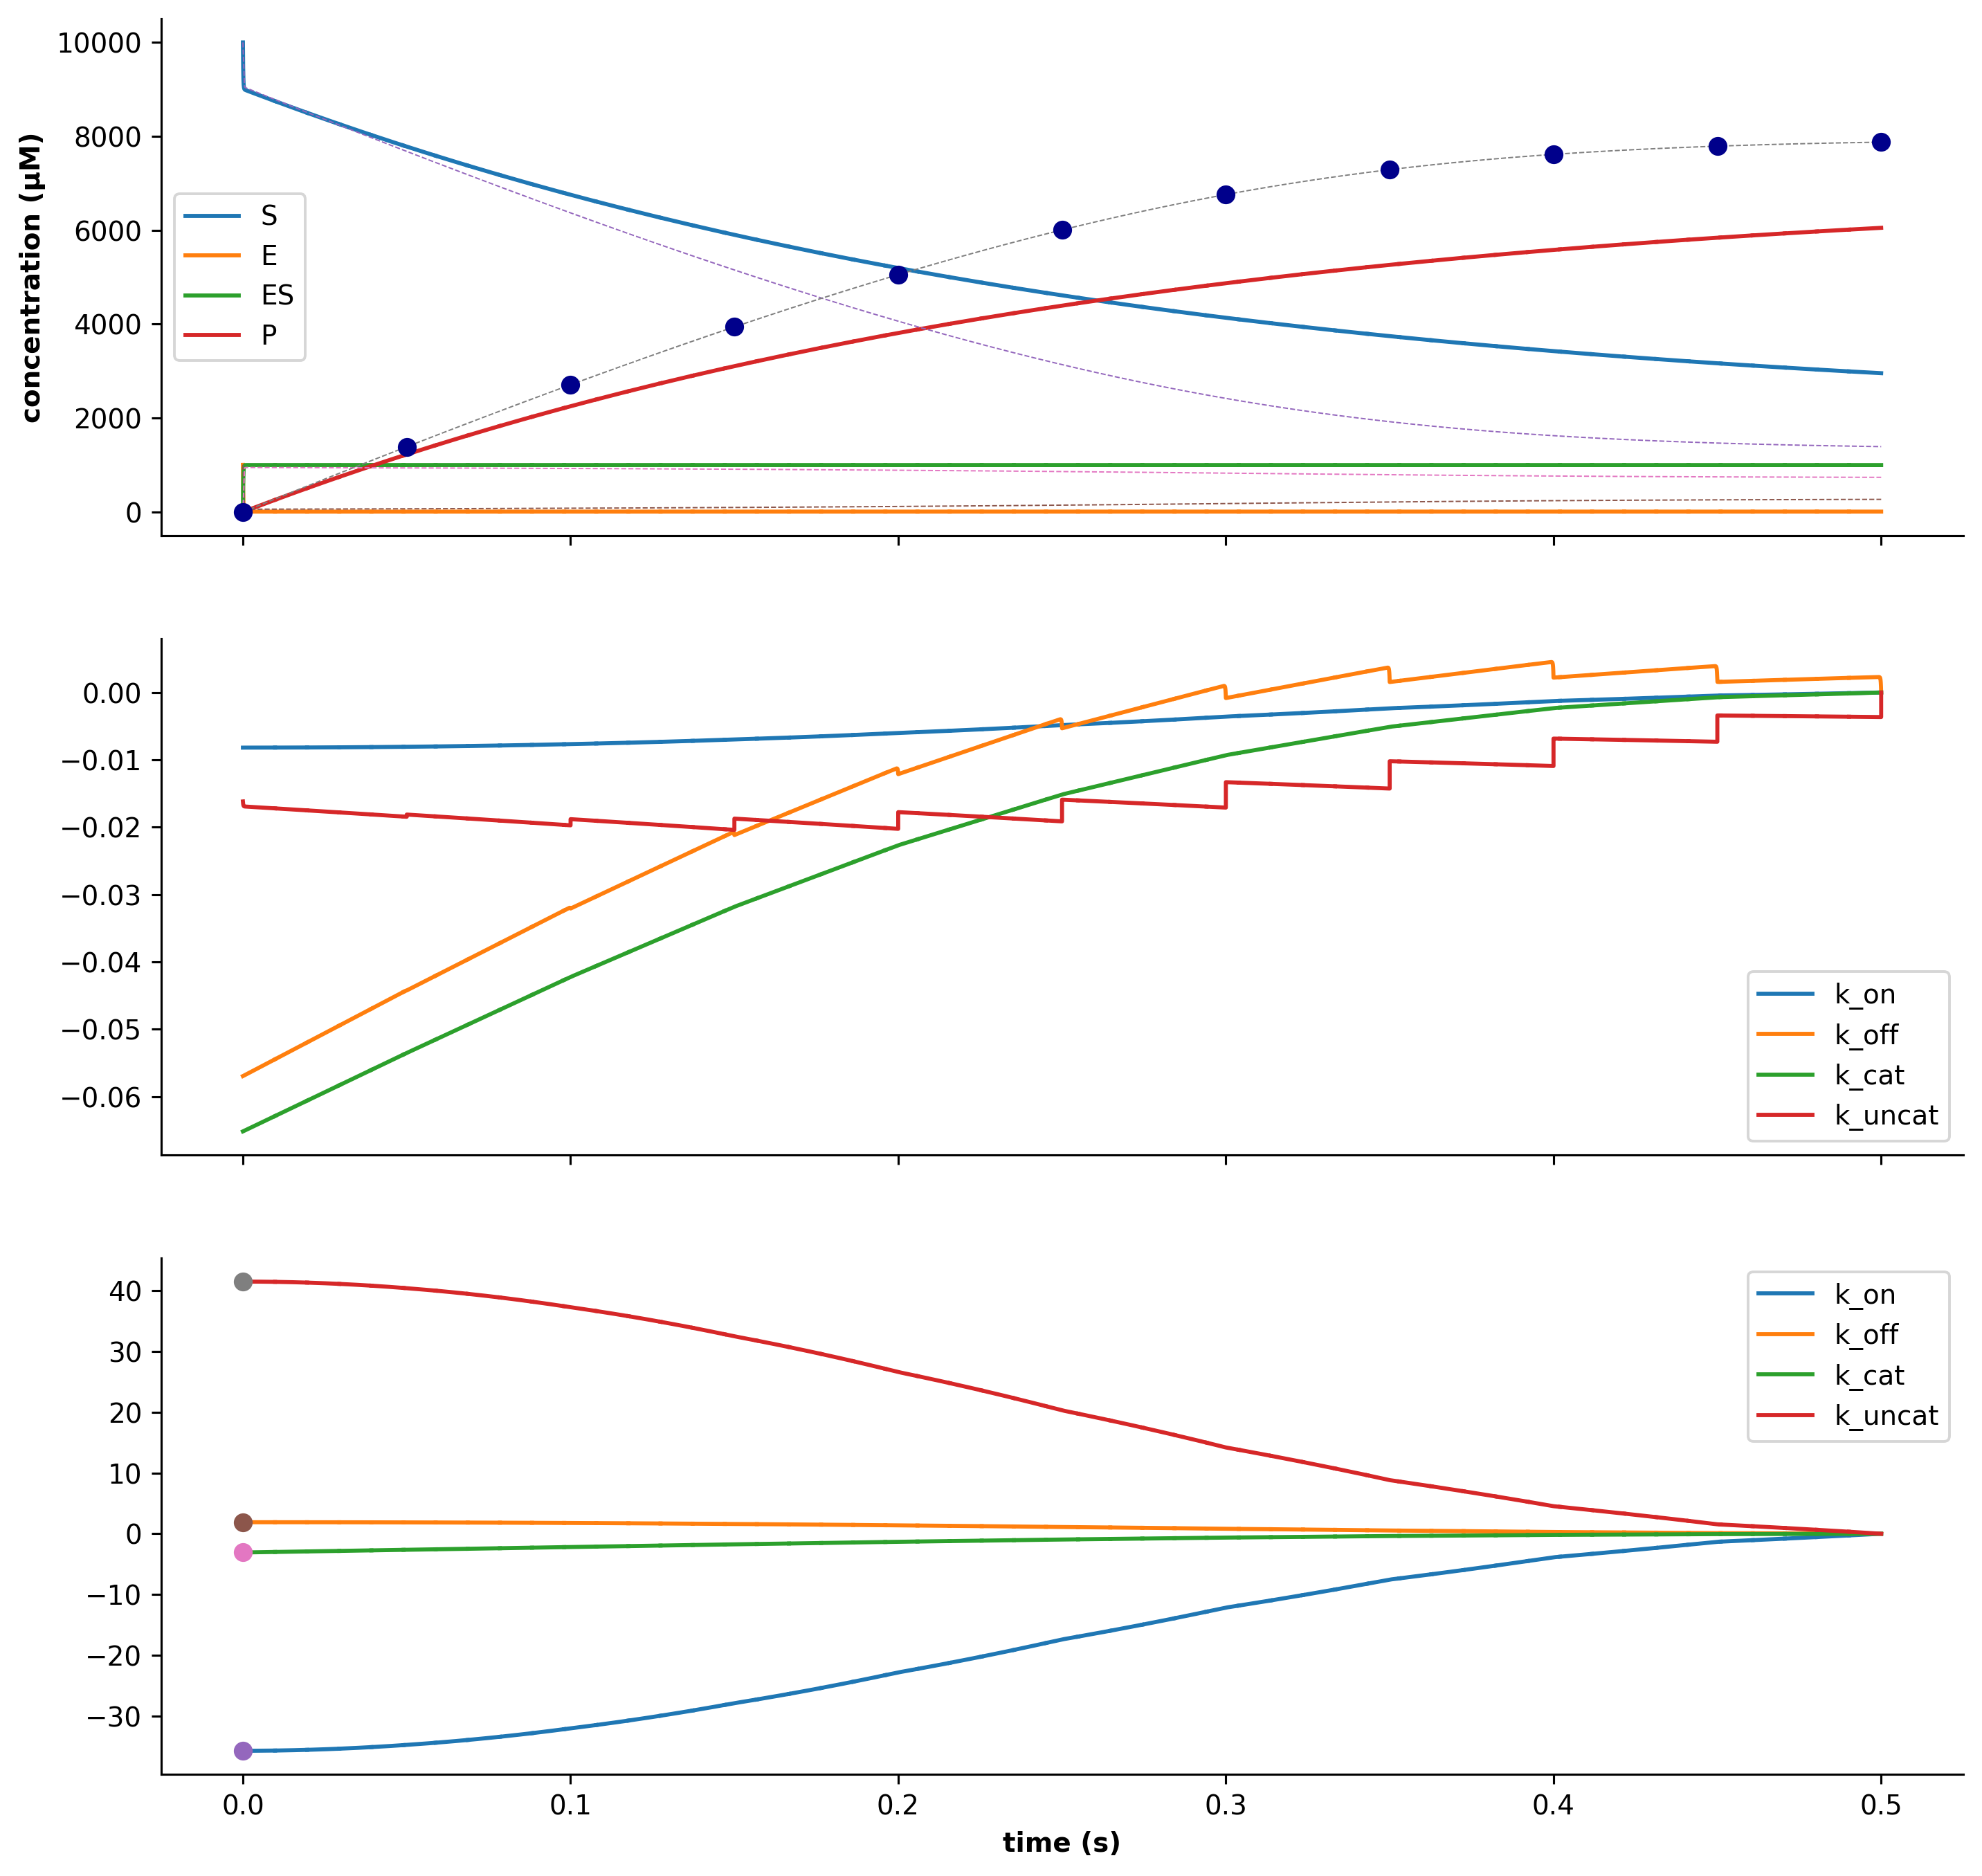

In [526]:
plt.rcParams['figure.figsize'] = [12, 12]

fig, axs = plt.subplots(3, 1, sharex='col')
u_0.plot.line(ax=axs[0])#, c=color(u_0.columns))
traj_scipy_full.plot.line(ax=axs[0], lw=0.5, linestyle='--', legend=False)#, c=color(traj_scipy_full.columns))
observations.plot.line(ax=axs[0], marker='o', lw=0, color=color(['P']), legend=False)
λ_0.plot.line(ax=axs[1])#, c=color(λ_0.columns))
grad_0_traj.plot.line(ax=axs[2])#, c=color(grad_0_traj.columns))
grad_0_traj.iloc[[0]].plot.line(ax=axs[2], marker='o', lw=0, legend=False)#, c=color(grad_0_traj.columns))

for ax in axs: fig_style(ax)

axs[1].set_ylabel('')
axs[2].set_ylabel('')
# plt.tight_layout()
None

We can sanity check that our gradient computation via the Adjoint Method is correct by comparing it to the Finite Differences approximation of the gradient:

In [532]:
def cosine_distance(a, b): return 1 - np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

cosine_distance(pd.Series(finite_differences(θ_0)).iloc[0:4], grad_0)

1.133973482914108e-05

That's good news, however, 

In [528]:
f'A single step of the Adjoint Method with the naïve python Euler method takes {round(euler_time, 2)}s'

'A single step of the Adjoint Method with the naïve python Euler method takes 55.94s'

It's simply untenable to iterate that procedure inside an optimization loop. As before, we'd like to implement our gradient computation via the Adjoint Method in scipy. However, this is not as straightforward as before. 

The reason the scipy <code><a href="https://docs.scipy.org/doc/scipy/reference/integrate.html">integrate</a></code> package's integrators are fast is because they use adaptive timestepping methods. In our Euler Methods, we set out timestep size `dt` at the outset, which remains constant throughout integration, meaning our resulting trajectory $u(t, \theta)$ is defined at uniformly-spaced values of $t$. Adaptive time-stepping integrators yield trajectories supported on non-uniformly-spaced values of $t$, which we won't know beforehand. That means integrating $\frac{du}{dt}$ with scipy, and subsequently integrating $-\frac{d\lambda}{dt}$ will result in trajectories defined on 

In [64]:
# import julia
# julia.install()
# import diffeqpy
# diffeqpy.install()
from diffeqpy import ode
plt.rcParams['figure.figsize'] = [12, 5]

In [73]:
#collapse
# define integrate_julia_full(), integrate_adjoint_scipy_full()

def dy_julia(dy, y, p, t):
    # y ordered S,E,ES,P
    # p is ordered k_on,k_off,k_cat,k_uncat
    dy[0] = p[1] * y[2] - p[0] * y[1] * y[0]
    dy[1] = p[1] * y[2] - p[0] * y[1] * y[0] + p[2] * y[2] - p[3] * y[1] * y[3]
    dy[2] = p[0] * y[1] * y[0] - p[1] * y[2] - p[2] * y[2] + p[3] * y[1] * y[3]
    dy[3] = p[2] * y[2] - p[3] * y[1] * y[3]

def integrate_julia_full(kinetic_params, initial_conditions=default_initial_conditions, dt=dt, steps=steps):

    y0 = list(initial_conditions.values())
    t_span = (0, dt*steps)

    prob = ode.ODEProblem(dy_julia, y0, t_span, [*kinetic_params.values()])

    try:
        sol = ode.solve(prob, ode.Tsit5())
        return pd.DataFrame(sol.u, index=sol.t, columns=['S', 'E', 'ES', 'P'])
    except:
        return pd.DataFrame(columns=['S', 'E', 'ES', 'P'])


def dλ_julia(dλ, λ, p, t):

    t = 0.5-t
    u_t = p[0](t)

    f_u = f_u_Jacobian(*u_t, *p[1:])

    dλ[0:4] = np.dot(f_u, λ[0:4]).flatten() # look for bug here

    if t in observations.index:
        print('here', t)
        g_u_P = 2*(observations.loc[t] - u_t[3])
        dλ[0:4] -= np.array([0, 0, 0, g_u_P])

    dλ[4:8] = np.array([np.dot(λ, f_θ(*u_t)) for f_θ in [f_k_on, f_k_off, f_k_cat, f_k_uncat]]).flatten()


def integrate_adjoint_julia(u_t_interpolant, θ_t, dt=dt, steps=steps):

    y0 = np.zeros(8)
    t_span = (0, dt*steps)
    cols = ['λ_k_on','λ_k_off','λ_k_cat','λ_k_uncat','G_k_on','G_k_off','G_k_cat','G_k_uncat']

    prob = ode.ODEProblem(dλ_julia, y0, t_span, [u_t_interpolant, *θ_t.values()])

    # try:
    sol = ode.solve(prob, ode.Tsit5())
    return pd.DataFrame(sol.u, index=sol.t, columns=cols).iloc[::-1]
    # except:
    #     return pd.DataFrame(columns=cols)


def gradient_of_loss_via_scipy_adjoint_method(θ_t):

    u_t = integrate_julia_full(θ_t)
    u_t_interpolant = scipy.interpolate.interp1d(u_t.index.values, u_t.values, kind='linear', axis=0, copy=False)

    λ_t = integrate_adjoint_julia(u_t_interpolant, θ_t)

    return λ_t, u_t



In [74]:
λ_0

Empty DataFrame
Columns: [λ_k_on, λ_k_off, λ_k_cat, λ_k_uncat, G_k_on, G_k_off, G_k_cat, G_k_uncat]
Index: []

In [75]:
λ_0, u_0 = gradient_of_loss_via_scipy_adjoint_method(θ_0)

TypeError: f_u_Jacobian() takes 8 positional arguments but 10 were given

In [71]:
λ_0[['λ_k_on','λ_k_off','λ_k_cat','λ_k_uncat']].plot.line()

TypeError: no numeric data to plot

In [ ]:
λ_0[['G_k_on', 'G_k_off', 'G_k_cat', 'G_k_uncat']].plot.line()

In [ ]:
optimize_by_gradient_descent(θ_0, gradient=gradient_of_loss_via_euler_adjoint_method)

### why didn't this work? 

In [562]:
def dy_backwards(t, y, k_on, k_off, k_cat, k_uncat, *args):
    # Y ordered S,E,ES,P
    dy = np.zeros(4)
    print(y, end='\r')
    dy[0] = k_off * y[2] - k_on * y[1] * y[0]
    dy[1] = k_off * y[2] - k_on * y[1] * y[0] + k_cat * y[2] - k_uncat * y[1] * y[3]
    dy[2] = k_on * y[1] * y[0] - k_off * y[2] - k_cat * y[2] + k_uncat * y[1] * y[3]
    dy[3] = k_cat * y[2] - k_uncat * y[1] * y[3]
    return -dy


def integrate_scipy_backwards(kinetic_params, initial_conditions=default_initial_conditions, dt=dt, steps=steps):

    t_span = (0, dt*steps)
    t_eval = np.around(np.linspace(t_span[0],t_span[1],1001), decimals=5)
    y0 = traj_scipy_full.loc[0.5].values

    try:
        sol = solve_ivp(dy_backwards, t_span, y0, args=(*kinetic_params.values(),), t_eval=t_eval, first_step=dt, method='LSODA')
        return pd.DataFrame(sol.y.T, index=sol.t, columns=['S', 'E', 'ES', 'P']).iloc[::-1]
    except:
        return pd.DataFrame(columns=['S', 'E', 'ES', 'P'])


In [563]:
traj_scipy_backwards = integrate_scipy_backwards(default_kinetic_params)

[ 1.33095927e+154  1.33095927e+154 -1.33095927e+154  3.43467618e+005]142]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

overflow encountered in double_scalars



Empty DataFrame
Columns: [S, E, ES, P]
Index: []

In [550]:
traj_scipy_full.loc[0.5].values

array([1389.17929479,  265.32463095,  734.67536905, 7876.14533617])

In [566]:
y = traj_scipy_full.loc[0.5].values
k_on, k_off, k_cat, k_uncat = (*kinetic_params.values(),)[:4]

In [567]:
dy_backwards(0, y, k_on, k_off, k_cat, k_uncat)

array([ 3698.2928291 , -3627.56350783,  3627.56350783, -7325.85633693])

In [571]:
dy_full(0, y, 0, 0, 0, 0, k_on, k_off, k_cat, k_uncat)

array([-3698.2928291 ,  3627.56350783, -3627.56350783,  7325.85633693])

### 3.3 More Inference Approaches

#### 3.3.1. Bayesian

- HMC
- Variational Inference, including gradient-based

#### 3.3.2. Frequentist

- Better 1st order optimizers
- 2nd order optimizers
- multiple shooting, collocation 

# 4. Conclusions

Michaelis menten isn't even right, that's why the databases are such a mess. You need the right scheme, and the right equations

[p1](https://www.nature.com/articles/s41589-021-00799-2)
[p2](https://www.sciencedirect.com/science/article/pii/S0955067420301770?via%3Dihub)

> With four parameters I can fit an elephant, and with five I can make him wiggle his trunk.
>
> -- John von Neumann

# 5. References

- [Gradient Descent for ODEs by Demetri Pananos](https://dpananos.github.io/posts/2019/05/blog-post-14/)

- [A Database of Thermodynamic Quantities for the Reactions of Glycolysis and the Tricarboxylic Acid Cycle](https://pubs.acs.org/doi/10.1021/jp911381p)

- [A database of thermodynamic properties of the reactions of glycolysis, the tricarboxylic acid cycle, and the
pentose phosphate pathway](https://academic.oup.com/database/article/doi/10.1093/database/bar005/462082)

- [Thermodynamics of Glycolysis](https://chem.libretexts.org/Bookshelves/General_Chemistry/Book%3A_Structure_and_Reactivity_in_Organic_Biological_and_Inorganic_Chemistry_(Schaller)/III%3A_Reactivity_in_Organic_Biological_and_Inorganic_Chemistry_1/08%3A_Mechanisms_of_Glycolysis/8.08%3A_Thermodynamics_of_Glycolysis)

- [BKMS-React database entry for glycolysis](http://bkms-react.tu-bs.de/pathway.php?pw_id=pw_glycolysis&ecno=1.2.1.12&id=50)

- [Bistability in Glycolysis Pathway as a Physiological Switch in Energy Metabolism](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0098756#pone.0098756.s012)

- [Determination of the rate of hexokinase-glucose dissociation by the isotope-trapping method](https://www.jbc.org/content/249/16/5163.full.pdf)

- [Quantitative Fundamentals of Molecular and Cellular Bioengineering](https://mitpress.mit.edu/books/quantitative-fundamentals-molecular-and-cellular-bioengineering)